In [1]:
#Library

#!pip install plotly --user

import subprocess
import sys
import importlib.util
import psutil



def check_and_install(package):
    """
        This function checks if a package is installed and installs it if not.
    """

    if importlib.util.find_spec(package) is None:
        print(f"{package} not found, installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"{package} has been installed")
    
# List of packages to check, with any special names or setup functions
packages = [
    "pandas",
    "numpy",
    "matplotlib",
    "seaborn",
    "scikit-learn",
    "scipy",
    "xgboost",
    "lightgbm",
    "tqdm",
    "ipywidgets",
    "pandarallel",
    "plotly",
    "unidecode"

]

# Loop through each package, importing and installing if needed
for package in packages:
    check_and_install(package)


import pandas as pd

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

import seaborn
import numpy as np
import warnings
import plotly.graph_objects as go

import re
from unidecode import unidecode

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression


from scipy  import stats



from pandarallel import pandarallel

# Our imports
from data_pred_code.utils import (
    create_prediction_visualizations,
    create_segment_analysis,
    errors_visualization,
    preprocess_helper_imputer,
    preprocess_helper_scaler
)

from data_pred_code.densities_based import predict_feature_density, print_density_info
from data_pred_code.regressors_based import compare_regressors
from data_pred_code.KNNImputer_based import predict_feature_knnimp


pandarallel.initialize(progress_bar=True)
real_cpu_count = psutil.cpu_count(logical=False)



scikit-learn not found, installing...
scikit-learn has been installed
INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
#Dataset import on pandas Data framedict_keys([2, 20, 72, 74, 75, 76, 77])
DatasetCyclists = pd.read_csv("dataset/cyclists.csv")
DatasetRace = pd.read_csv("dataset/races_updated.csv")

# Drop redundant columns
# _url from DatasetCyclist this information is in DatasetRace under the column 'cyclist'
# name from DatasetRace this information is in DatasetCyclist under the column 'name'
MergedDataset = pd.merge(DatasetCyclists, DatasetRace.drop(columns=['name']), left_on='_url', right_on='cyclist', suffixes=('_cyclist', '_race')).drop(columns=['_url_cyclist']) 

MergedDataset.head(3)

name  birth_year  weight  height nationality  \
0  Bruno  Surra      1964.0     NaN     NaN       Italy   
1   Gérard  Rué      1965.0    74.0   182.0      France   
2   Gérard  Rué      1965.0    74.0   182.0      France   

                      _url_race  points  uci_points    length  climb_total  \
0  vuelta-a-espana/1989/stage-1     0.0         NaN   20100.0        588.0   
1   tour-de-france/1997/stage-2     0.0         NaN  262000.0       2808.0   
2   tour-de-france/1990/stage-1     0.0         NaN  138500.0       1232.0   

   ...  average_temperature                 date  position      cyclist  \
0  ...                  NaN  1989-04-24 00:25:33       111  bruno-surra   
1  ...                  NaN  1997-07-07 06:27:47       133   gerard-rue   
2  ...                  NaN  1990-07-01 03:29:36        67   gerard-rue   

   cyclist_age is_tarmac  is_cobbled  is_gravel  cyclist_team  delta  
0         25.0      True       False      False           NaN   15.0  
1         32.0      True       False      False  denmark-1991    0.0  
2         25.0      True       False      False   france-1978  635.0  

[3 rows x 22 columns]

### Plot tools

In [15]:
def PlotMissingUsableData(Dataset, Name):
    
    PlotDataset = pd.DataFrame({
        "Elements": list(Dataset.keys()),
        "Total values": [Dataset.shape[0]]*len(list(Dataset.keys())),
        "Missing values": list(Dataset.isnull().sum()),
        "Usable values": list(Dataset.shape[0] - Dataset.isnull().sum())
    })

    PlotDataset.set_index('Elements', inplace=True)
    PlotDataset.plot(kind='bar', figsize=(10, 6))
    
    print(PlotDataset)

    plt.title(f'Dataset {Name} distribution')
    plt.xlabel('Features')
    plt.ylabel('Valori')
    plt.show()

In [16]:
def PlotDistributionFeatures(Dataset, Features):
    PlotsLambda = [lambda f, ax: ax.hist(Dataset[f], bins=10, alpha=0.7, color="blue")]
    
    # Calculate the number of rows needed based on the feature count
    num_cols = 2
    num_rows = (len(Features) + 1) // num_cols  # This rounds up to ensure enough rows
    
    fig = plt.figure(figsize=(5*len(PlotsLambda), 2*len(Features)))
    gs = gridspec.GridSpec(num_rows, num_cols, figure=fig, wspace=0.4, hspace=0.4)
      
    for i, feature in enumerate(Features):
        ax = fig.add_subplot(gs[i // num_cols, i % num_cols])
        ax.set_title(feature)
        for plot in PlotsLambda:    
            plot(feature, ax)
        

    plt.tight_layout()  # Avoid overlapping plots
    plt.show()
    
    Fs = []
    i = 0
    r = 4

    while i + r < len(Features):
        Fs.append(Features[i: i + r])
        i += r
        
    if i < len(Features) - 1: 
        Fs.append(Features[i:])
    
    # Normalize the dataset for selected features
    Dataset = (Dataset[Features] - Dataset[Features].mean()) / Dataset[Features].std()
    
    for fs in Fs:
        seaborn.boxenplot(data=Dataset[fs], orient="h")
        plt.show()
        
        seaborn.catplot(data=Dataset[fs], kind="box")
        plt.show()

# **Data understanding**

## Dataset cyclists

### Missing values distributions

In [6]:
PlotMissingUsableData(DatasetCyclists, "Cyclists")

NameError: name 'PlotMissingUsableData' is not defined

Si può vedere che:

- La mancanza di dati è importante nelle colonne "weight" e "height".
- Nella colonna "birth_year" manca qualche dato e su "nationality" un solo dato.

### Correct values check (Margherita)

In [ ]:
DatasetCyclists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6134 entries, 0 to 6133
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   _url         6134 non-null   object 
 1   name         6134 non-null   object 
 2   birth_year   6121 non-null   float64
 3   weight       3078 non-null   float64
 4   height       3143 non-null   float64
 5   nationality  6133 non-null   object 
dtypes: float64(3), object(3)
memory usage: 287.7+ KB


In [ ]:
DatasetCyclists.head()

_url                  name  birth_year  weight  height  \
0           bruno-surra          Bruno  Surra      1964.0     NaN     NaN   
1            gerard-rue           Gérard  Rué      1965.0    74.0   182.0   
2              jan-maas             Jan  Maas      1996.0    69.0   189.0   
3  nathan-van-hooydonck  Nathan Van Hooydonck      1995.0    78.0   192.0   
4      jose-felix-parra     José Félix  Parra      1997.0    55.0   171.0   

   nationality  
0        Italy  
1       France  
2  Netherlands  
3      Belgium  
4        Spain

In [ ]:
DatasetCyclists.describe()

birth_year       weight       height
count  6121.000000  3078.000000  3143.000000
mean   1974.071884    68.658739   179.815145
std      15.535834     6.348183     6.443447
min    1933.000000    48.000000   154.000000
25%    1962.000000    64.000000   175.000000
50%    1974.000000    69.000000   180.000000
75%    1987.000000    73.000000   184.000000
max    2004.000000    94.000000   204.000000

Possiamo vedere il valore minimo e massimo di ogni attributo numerico e constatare che sono valori ammissibili

In [ ]:
# Controllo dei valori mancanti
print("Valori mancanti in DatasetCyclists:\n", DatasetCyclists.isnull().sum())

Valori mancanti in DatasetCyclists:
 _url              0
name              0
birth_year       13
weight         3056
height         2991
nationality       1
dtype: int64


In [ ]:
# controllo Duplicati
print("Duplicati in DatasetCyclists:", DatasetCyclists.duplicated().sum())

Duplicati in DatasetCyclists: 0


In [ ]:
# Controllo del formato dei nomi
# Regex che include lettere latine estese e trattini
name_pattern = re.compile(r"^[\wÀ-ÖØ-öø-ÿ\s'-]+$")

invalid_names = DatasetCyclists[~DatasetCyclists['name'].str.match(name_pattern, na=False)]
print("Numero di nomi non validi:", invalid_names[['name']].shape[0])

Numero di nomi non validi: 0


In [ ]:
#controllo dei valori di url
# Crea la colonna 'expected_url' generata dai valori in 'name' senza accenti
DatasetCyclists['expected_url'] = DatasetCyclists['name'].apply(lambda x: unidecode(x.lower()).replace(' ', '-'))

# Trova righe in cui '_url' non coincide con 'expected_url'
invalid_urls = DatasetCyclists[DatasetCyclists['_url'] != DatasetCyclists['expected_url']]

print("Numero di URL non conformi:", len(invalid_urls))
print("Esempi di URL non conformi:\n", invalid_urls[['_url', 'name', 'expected_url']].head(10))

Numero di URL non conformi: 5770
Esempi di URL non conformi:
                           _url                         name  \
0                  bruno-surra                 Bruno  Surra   
1                   gerard-rue                  Gérard  Rué   
2                     jan-maas                    Jan  Maas   
4             jose-felix-parra            José Félix  Parra   
5              manuel-penalver             Manuel  Peñalver   
6                 willy-moonen                Willy  Moonen   
7                    chad-haga                   Chad  Haga   
9                 scott-davies                Scott  Davies   
10                 stian-remme                 Stian  Remme   
11  jose-angel-gomez-marchante  José Ángel  Gómez Marchante   

                   expected_url  
0                  bruno--surra  
1                   gerard--rue  
2                     jan--maas  
4             jose-felix--parra  
5              manuel--penalver  
6                 willy--moonen  
7     

In [ ]:
#controllo dei valori di 'nationality' (non ho altre idee per farlo)

unique_nationalities = DatasetCyclists['nationality'].unique()
print("Nazionalità uniche:\n", unique_nationalities)

Nazionalità uniche:
 ['Italy' 'France' 'Netherlands' 'Belgium' 'Spain' 'United States' nan
 'Norway' 'Russia' 'Poland' 'Germany' 'Australia' 'Switzerland' 'Ireland'
 'Denmark' 'Great Britain' 'Colombia' 'South Africa' 'Argentina'
 'New Zealand' 'Lithuania' 'Portugal' 'Austria' 'Yugoslavia' 'Estonia'
 'Romania' 'Slovenia' 'Canada' 'Latvia' 'Luxembourg' 'Sweden'
 'Czech Republic' 'Slovakia' 'Morocco' 'Ukraine' 'Ethiopia' 'Belarus'
 'Venezuela' 'Japan' 'Mexico' 'Croatia' 'Kazakhstan' 'Uruguay' 'Israel'
 'Namibia' 'Eritrea' 'Costa Rica' 'Taiwan' 'Azerbaijan' 'Hungary'
 'Moldova' 'Panama' 'Finland' 'Bulgaria' 'Serbia' 'Brazil' 'Iran' 'Greece'
 'Chile' 'Ecuador' 'China' 'Albania' 'Guatemala' 'Uzbekistan' 'Algeria'
 'Tunisia' 'Monaco' 'Rwanda' 'Dominican Republic' 'Liechtenstein'
 'Zimbabwe' 'Puerto Rico' 'Hongkong']


### Features distributions

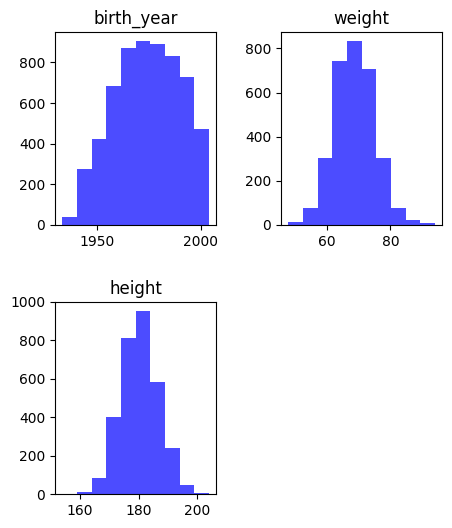

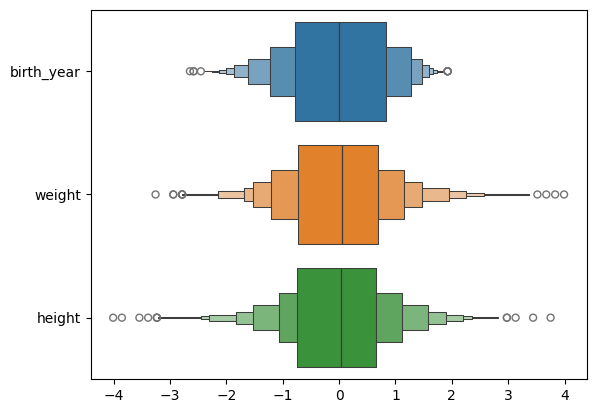

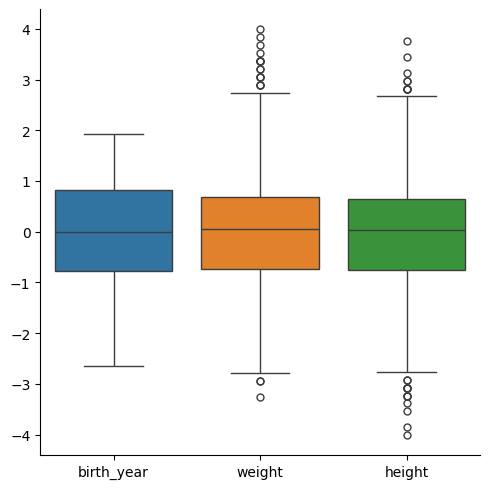

In [ ]:
InterestingFeatures = ["birth_year", "weight", "height"]

PlotDistributionFeatures(DatasetCyclists, InterestingFeatures)

Le distribuzioni seguono tutte una distribuzione gaussiana è la presenza di outlier è più (ma non troppo) presente sulle colonne "weight" e "height".

### Conclusions

Per la prossima fase di data transformation, sono state decise le seguenti decisioni per il dataset **cyclists**:

- 

## Dataset race

### Missing values distributions

In [7]:
PlotMissingUsableData(DatasetRace, "Race")

NameError: name 'PlotMissingUsableData' is not defined

Si può vedere che:

- La mancanza di dati è importante nelle colonne "uci_points", "average_temperature", "cyclists_team", "climb_total" e "profile".

### Correct values check (Margherita)

In [ ]:
DatasetRace.head()

_url            name  points  uci_points    length  \
0  tour-de-france/1978/stage-6  Tour de France   100.0         NaN  162000.0   
1  tour-de-france/1978/stage-6  Tour de France    70.0         NaN  162000.0   
2  tour-de-france/1978/stage-6  Tour de France    50.0         NaN  162000.0   
3  tour-de-france/1978/stage-6  Tour de France    40.0         NaN  162000.0   
4  tour-de-france/1978/stage-6  Tour de France    32.0         NaN  162000.0   

   climb_total  profile  startlist_quality  average_temperature  \
0       1101.0      1.0               1241                  NaN   
1       1101.0      1.0               1241                  NaN   
2       1101.0      1.0               1241                  NaN   
3       1101.0      1.0               1241                  NaN   
4       1101.0      1.0               1241                  NaN   

                  date  position           cyclist  cyclist_age  is_tarmac  \
0  1978-07-05 04:02:24         1        sean-kelly         22.0       True   
1  1978-07-05 04:02:24         2  gerrie-knetemann         27.0       True   
2  1978-07-05 04:02:24         3    rene-bittinger         24.0       True   
3  1978-07-05 04:02:24         4    joseph-bruyere         30.0       True   
4  1978-07-05 04:02:24         5  sven-ake-nilsson         27.0       True   

   is_cobbled  is_gravel                          cyclist_team  delta  
0       False      False  vini-ricordi-pinarello-sidermec-1986    0.0  
1       False      False                           norway-1987    0.0  
2       False      False                                   NaN    0.0  
3       False      False              navigare-blue-storm-1993    0.0  
4       False      False                            spain-1991    0.0

In [ ]:
DatasetRace.describe()

points     uci_points         length    climb_total  \
count  586982.000000  250055.000000  586982.000000  440535.000000   
mean        3.593427       1.945944  166790.230331    2330.140284   
std        15.283975      18.144515   64555.698036    1375.771818   
min         0.000000       0.000000    1000.000000       2.000000   
25%         0.000000       0.000000  152500.000000    1309.000000   
50%         0.000000       0.000000  178200.000000    2255.000000   
75%         0.000000       0.000000  203500.000000    3273.000000   
max       350.000000     800.000000  338000.000000    6974.000000   

             profile  startlist_quality  average_temperature       position  \
count  439353.000000      586982.000000         29861.000000  586982.000000   
mean        2.610778        1100.670499            21.728107      75.216686   
std         1.491247         380.609358             5.883963      48.340121   
min         1.000000         115.000000            10.000000       1.000000   
25%         1.000000         844.000000            17.000000      33.000000   
50%         2.000000         988.000000            22.000000      71.000000   
75%         4.000000        1309.000000            26.000000     113.000000   
max         5.000000        2047.000000            36.000000     210.000000   

         cyclist_age          delta  
count  586870.000000  586982.000000  
mean       28.479443     418.692641  
std         3.855858     844.256415  
min        13.000000   -6906.000000  
25%        26.000000      10.000000  
50%        28.000000     157.000000  
75%        31.000000     625.000000  
max        45.000000   61547.000000

Possiamo vedere il valore minimo e massimo di ogni attributo numerico e constatare che sono valori ammissibili, dobbiamo capire il significato di delta<0

In [ ]:
DatasetRace[DatasetRace["delta"] < 0]

_url             name  points  uci_points  \
70324   vuelta-a-espana/1992/stage-19  Vuelta a España     5.0         NaN   
70325   vuelta-a-espana/1992/stage-19  Vuelta a España     4.0         NaN   
70326   vuelta-a-espana/1992/stage-19  Vuelta a España     3.0         NaN   
70327   vuelta-a-espana/1992/stage-19  Vuelta a España     2.0         NaN   
70328   vuelta-a-espana/1992/stage-19  Vuelta a España     1.0         NaN   
...                               ...              ...     ...         ...   
228591       paris-nice/1990/stage-7a     Paris - Nice     4.0         NaN   
228592       paris-nice/1990/stage-7a     Paris - Nice     3.0         NaN   
228593       paris-nice/1990/stage-7a     Paris - Nice     2.0         NaN   
228594       paris-nice/1990/stage-7a     Paris - Nice     1.0         NaN   
518345    tour-de-suisse/1993/stage-4   Tour de Suisse    30.0         NaN   

          length  climb_total  profile  startlist_quality  \
70324    37900.0        294.0      NaN               1033   
70325    37900.0        294.0      NaN               1033   
70326    37900.0        294.0      NaN               1033   
70327    37900.0        294.0      NaN               1033   
70328    37900.0        294.0      NaN               1033   
...          ...          ...      ...                ...   
228591  102000.0          NaN      NaN                995   
228592  102000.0          NaN      NaN                995   
228593  102000.0          NaN      NaN                995   
228594  102000.0          NaN      NaN                995   
518345  212300.0          NaN      NaN                655   

        average_temperature                 date  position  \
70324                   NaN  1992-05-15 00:02:23        11   
70325                   NaN  1992-05-15 00:02:20        12   
70326                   NaN  1992-05-15 00:03:57        13   
70327                   NaN  1992-05-15 00:03:56        14   
70328                   NaN  1992-05-15 00:03:53        15   
...                     ...                  ...       ...   
228591                  NaN  1990-03-11 00:55:03         7   
228592                  NaN  1990-03-11 00:55:03         8   
228593                  NaN  1990-03-11 00:55:03         9   
228594                  NaN  1990-03-11 00:32:39        10   
518345                  NaN  1993-06-18 00:00:39         2   

                         cyclist  cyclist_age  is_tarmac  is_cobbled  \
70324             johan-bruyneel         28.0       True       False   
70325                raul-alcala         28.0       True       False   
70326          joachim-halupczok         24.0       True       False   
70327   djamolidine-abduzhaparov         28.0       True       False   
70328             guido-bontempi         32.0       True       False   
...                          ...          ...        ...         ...   
228591            francis-moreau         25.0       True       False   
228592          laurent-jalabert         22.0       True       False   
228593        claudio-chiappucci         27.0       True       False   
228594       jean-claude-colotti         29.0       True       False   
518345            marco-saligari         28.0       True       False   

        is_gravel                         cyclist_team   delta  
70324       False  ville-de-charleroi-new-systems-2000 -2635.0  
70325       False                  team-volksbank-2008 -2638.0  
70326       False                                  NaN -2541.0  
70327       False                    south-africa-2022 -2542.0  
70328       False                    south-africa-2022 -2545.0  
...           ...                                  ...     ...  
228591      False                                  NaN -5562.0  
228592      False                      kazakhstan-2022 -5562.0  
228593      False              csf-group-navigare-2008 -5562.0  
228594      False                  jolly-ceramica-1977 -6906.0  
518345      False  ville-de-charleroi-

In [ ]:
#controllo che delta = 0 per position = 0
pos = DatasetRace["position"] == 0
d = DatasetRace["delta"] != 0
print("numero di righe dove la posizione è 0 e delta è diverso da zero: ",DatasetRace[pos & d].shape[0])

numero di righe dove la posizione è 0 e delta è diverso da zero:  0


In [ ]:
DatasetRace[DatasetRace["delta"] < 0]
#controllando su google Tour de France 2003 leonardo bertagnolli squalificato

_url             name  points  uci_points  \
70324   vuelta-a-espana/1992/stage-19  Vuelta a España     5.0         NaN   
70325   vuelta-a-espana/1992/stage-19  Vuelta a España     4.0         NaN   
70326   vuelta-a-espana/1992/stage-19  Vuelta a España     3.0         NaN   
70327   vuelta-a-espana/1992/stage-19  Vuelta a España     2.0         NaN   
70328   vuelta-a-espana/1992/stage-19  Vuelta a España     1.0         NaN   
...                               ...              ...     ...         ...   
228591       paris-nice/1990/stage-7a     Paris - Nice     4.0         NaN   
228592       paris-nice/1990/stage-7a     Paris - Nice     3.0         NaN   
228593       paris-nice/1990/stage-7a     Paris - Nice     2.0         NaN   
228594       paris-nice/1990/stage-7a     Paris - Nice     1.0         NaN   
518345    tour-de-suisse/1993/stage-4   Tour de Suisse    30.0         NaN   

          length  climb_total  profile  startlist_quality  \
70324    37900.0        294.0      NaN               1033   
70325    37900.0        294.0      NaN               1033   
70326    37900.0        294.0      NaN               1033   
70327    37900.0        294.0      NaN               1033   
70328    37900.0        294.0      NaN               1033   
...          ...          ...      ...                ...   
228591  102000.0          NaN      NaN                995   
228592  102000.0          NaN      NaN                995   
228593  102000.0          NaN      NaN                995   
228594  102000.0          NaN      NaN                995   
518345  212300.0          NaN      NaN                655   

        average_temperature                 date  position  \
70324                   NaN  1992-05-15 00:02:23        11   
70325                   NaN  1992-05-15 00:02:20        12   
70326                   NaN  1992-05-15 00:03:57        13   
70327                   NaN  1992-05-15 00:03:56        14   
70328                   NaN  1992-05-15 00:03:53        15   
...                     ...                  ...       ...   
228591                  NaN  1990-03-11 00:55:03         7   
228592                  NaN  1990-03-11 00:55:03         8   
228593                  NaN  1990-03-11 00:55:03         9   
228594                  NaN  1990-03-11 00:32:39        10   
518345                  NaN  1993-06-18 00:00:39         2   

                         cyclist  cyclist_age  is_tarmac  is_cobbled  \
70324             johan-bruyneel         28.0       True       False   
70325                raul-alcala         28.0       True       False   
70326          joachim-halupczok         24.0       True       False   
70327   djamolidine-abduzhaparov         28.0       True       False   
70328             guido-bontempi         32.0       True       False   
...                          ...          ...        ...         ...   
228591            francis-moreau         25.0       True       False   
228592          laurent-jalabert         22.0       True       False   
228593        claudio-chiappucci         27.0       True       False   
228594       jean-claude-colotti         29.0       True       False   
518345            marco-saligari         28.0       True       False   

        is_gravel                         cyclist_team   delta  
70324       False  ville-de-charleroi-new-systems-2000 -2635.0  
70325       False                  team-volksbank-2008 -2638.0  
70326       False                                  NaN -2541.0  
70327       False                    south-africa-2022 -2542.0  
70328       False                    south-africa-2022 -2545.0  
...           ...                                  ...     ...  
228591      False                                  NaN -5562.0  
228592      False                      kazakhstan-2022 -5562.0  
228593      False              csf-group-navigare-2008 -5562.0  
228594      False                  jolly-ceramica-1977 -6906.0  
518345      False  ville-de-charleroi-

In [ ]:
# Controlla che il delta sia crescente all'aumentare della posizione

# Ordinare il dataset per 'position' e 'delta'
tour = DatasetRace[DatasetRace['_url'] == "vuelta-a-espana/1992/stage-19"]
#tour['delta'] = tour['delta'].abs()
print(tour[['_url', 'position', 'delta']])

DatasetRace_sorted = tour.sort_values(by=['position', 'delta'])

invalid_deltas = DatasetRace_sorted[DatasetRace_sorted['delta'].diff() < 0]

# Filtrare per mostrare solo i casi in cui la posizione aumenta
invalid_deltas = invalid_deltas[DatasetRace_sorted['position'].diff() > 0]

print("Numero di righe con delta non coerente rispetto alla posizione:", len(invalid_deltas))
print("Esempi di righe con delta non coerente:\n", invalid_deltas[['_url', 'position', 'delta']].head())


                                _url  position   delta
70314  vuelta-a-espana/1992/stage-19         1     0.0
70315  vuelta-a-espana/1992/stage-19         2    52.0
70316  vuelta-a-espana/1992/stage-19         3    68.0
70317  vuelta-a-espana/1992/stage-19         4    93.0
70318  vuelta-a-espana/1992/stage-19         5   100.0
...                              ...       ...     ...
70394  vuelta-a-espana/1992/stage-19        81 -2385.0
70395  vuelta-a-espana/1992/stage-19        82 -2391.0
70396  vuelta-a-espana/1992/stage-19        83 -2393.0
70397  vuelta-a-espana/1992/stage-19        84 -2394.0
70398  vuelta-a-espana/1992/stage-19        85 -2397.0

[85 rows x 3 columns]
Numero di righe con delta non coerente rispetto alla posizione: 61
Esempi di righe con delta non coerente:
                                 _url  position   delta
70324  vuelta-a-espana/1992/stage-19        11 -2635.0
70325  vuelta-a-espana/1992/stage-19        12 -2638.0
70327  vuelta-a-espana/1992/stage-19        

C:\Users\hp\AppData\Local\Temp\ipykernel_13516\1073456324.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  invalid_deltas = invalid_deltas[DatasetRace_sorted['position'].diff() > 0]


In [ ]:
# Controllo dei valori mancanti
print("Valori mancanti in DatasetRace:\n", DatasetRace.isnull().sum())

Valori mancanti in DatasetRace:
 _url                        0
name                        0
points                      0
uci_points             336927
length                      0
climb_total            146447
profile                147629
startlist_quality           0
average_temperature    557121
date                        0
position                    0
cyclist                     0
cyclist_age               112
is_tarmac                   0
is_cobbled                  0
is_gravel                   0
cyclist_team           158706
delta                       0
dtype: int64


In [ ]:
# controllo dei Duplicati
print("Duplicati in DatasetRace:", DatasetRace.duplicated().sum())

Duplicati in DatasetRace: 43


In [ ]:
# _url
# Controllo che non ci siano spazi o caratteri non validi negli URL
invalid_urls = DatasetRace[~DatasetRace['_url'].str.match(r'^[\w/:.-]+$', na=False)]

# Stampa il numero di URL non validi
print("Numero di URL non validi:", invalid_urls.shape[0])

Numero di URL non validi: 0


In [ ]:
# Controllo nomi 
import re
# Regex che include lettere latine estese, trattini e anche il carattere '/'
name_pattern = re.compile(r"^[\wÀ-ÖØ-öø-ÿ\s'/-]+$")

# Rieffettua il controllo dei nomi
invalid_names_race = DatasetRace[~DatasetRace['name'].str.match(name_pattern, na=False)]
print("Numero di nomi non validi:", invalid_names_race['name'].shape[0])

Numero di nomi non validi: 0


In [ ]:
# Controllo che le date siano valide
invalid_dates = DatasetRace[~DatasetRace['date'].str.match(r'^\d{4}-\d{2}-\d{2}.*$', na=False)]
print("Numero di date non valide:", invalid_dates['date'].shape[0])

Numero di date non valide: 0


In [ ]:
# Controllo cyclist
invalid_cyclists = DatasetRace[~DatasetRace['cyclist'].str.match(r"^[\w-]+$", na=False)]
print("Numero di nomi dei ciclisti non validi:", invalid_cyclists['cyclist'].shape[0])

Numero di nomi dei ciclisti non validi: 0


In [ ]:
# Trova i ciclisti in DatasetRace che non sono presenti in DatasetCyclists
missing_cyclists = DatasetRace[~DatasetRace['cyclist'].isin(DatasetCyclists['_url'])]

print("Numero di ciclisti non presenti in DatasetCyclists:", len(missing_cyclists))

Numero di ciclisti non presenti in DatasetCyclists: 0


In [ ]:
SetCyclistsURL = set(DatasetCyclists["_url"])
SetRaceCyclist = set(DatasetRace["cyclist"])

Intersection = SetCyclistsURL.intersection(SetRaceCyclist)

print(f"Numero di ciclisti che non gareggiano: {len(SetCyclistsURL.difference(Intersection))}")
print(f"Numero di ciclisti che gareggiano ma non sono presenti nel race dataset: {len(SetRaceCyclist.difference(Intersection))}")

#print(f"Numero di ciclisti sia su cyclist che su race dataset {len(Intersection)}")

#for i in SetCyclistsURL.difference(Intersection): print(i)

Numero di ciclisti che non gareggiano: 52
Numero di ciclisti che gareggiano ma non sono presenti nel race dataset: 0


In [ ]:
# Controllo team dei ciclisti
invalid_teams = DatasetRace[DatasetRace['cyclist_team'].notna() & ~DatasetRace['cyclist_team'].str.match(r"^[\w\s\-.&/]+$", na=False)]

print("Numero di team non validi in DatasetRace:", invalid_teams.shape[0])

Numero di team non validi in DatasetRace: 0


In [ ]:
#controllo i che i valori di is_tarmac, is_cobbled e is_gravel siano True o False
print("Valori non booleani in DatasetRace:", DatasetRace[~DatasetRace['is_tarmac'].isin([True, False])].shape[0])
print("Valori non booleani in DatasetRace:", DatasetRace[~DatasetRace['is_cobbled'].isin([True, False])].shape[0])
print("Valori non booleani in DatasetRace:", DatasetRace[~DatasetRace['is_gravel'].isin([True, False])].shape[0])

Valori non booleani in DatasetRace: 0
Valori non booleani in DatasetRace: 0
Valori non booleani in DatasetRace: 0


In [ ]:
# controllo se almeno uno tra is_tarmac(asfalto), is_cobbled(acciottolato) e is_gravel(di ghiaia) è vero
inconsistent_surface = DatasetRace[(~DatasetRace['is_tarmac']) & 
                                  (~DatasetRace['is_cobbled']) & 
                                  (~DatasetRace['is_gravel'])]

print("Numero di gare con tipo di strada inconsistente:", len(inconsistent_surface))
print("Esempi di gare con tipo di strada inconsistente:\n", inconsistent_surface[['name', 'is_tarmac', 'is_cobbled', 'is_gravel']].head(10))

#cercando su google ho trovato che Ronde van Vlaanderen / Tour des Flandres ha una strada "cobbled"

Numero di gare con tipo di strada inconsistente: 53625
Esempi di gare con tipo di strada inconsistente:
                                           name  is_tarmac  is_cobbled  \
1265  Ronde van Vlaanderen / Tour des Flandres      False       False   
1266  Ronde van Vlaanderen / Tour des Flandres      False       False   
1267  Ronde van Vlaanderen / Tour des Flandres      False       False   
1268  Ronde van Vlaanderen / Tour des Flandres      False       False   
1269  Ronde van Vlaanderen / Tour des Flandres      False       False   
1270  Ronde van Vlaanderen / Tour des Flandres      False       False   
1271  Ronde van Vlaanderen / Tour des Flandres      False       False   
1272  Ronde van Vlaanderen / Tour des Flandres      False       False   
1273  Ronde van Vlaanderen / Tour des Flandres      False       False   
1274  Ronde van Vlaanderen / Tour des Flandres      False       False   

      is_gravel  
1265      False  
1266      False  
1267      False  
1268      False  
1

In [ ]:
# controllo se birth_year+cyclist_age=race_year
# Unione dei dataset sulla colonna 'name' e 'cyclist'
merged_data = pd.merge(DatasetRace, DatasetCyclists.rename(columns={'name': 'cyclist_name'}), left_on='cyclist', right_on='cyclist_name', how='inner')

merged_data['race_year'] = pd.to_datetime(merged_data['date']).dt.year

# Calcolo l'anno di nascita previsto (race_year - cyclist_age)
merged_data['expected_birth_year'] = merged_data['race_year'] - merged_data['cyclist_age']

# cercare le righe dove birth_year non corrisponde con l'expected_birth_year
invalid_birth_years = merged_data[merged_data['birth_year'] != merged_data['expected_birth_year']]

print("Numero di righe con discrepanze negli anni di nascita:")
print(invalid_birth_years[['cyclist_name', 'cyclist', 'birth_year', 'cyclist_age', 'race_year', 'expected_birth_year']].shape[0])


Numero di righe con discrepanze negli anni di nascita:
0


### Features distributions

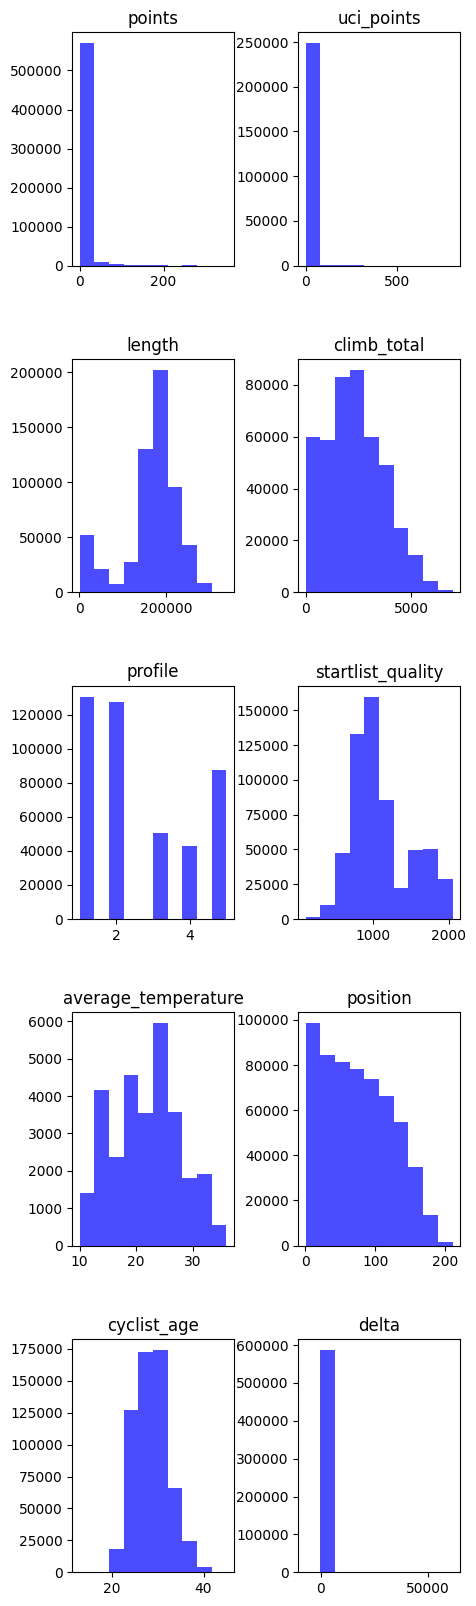

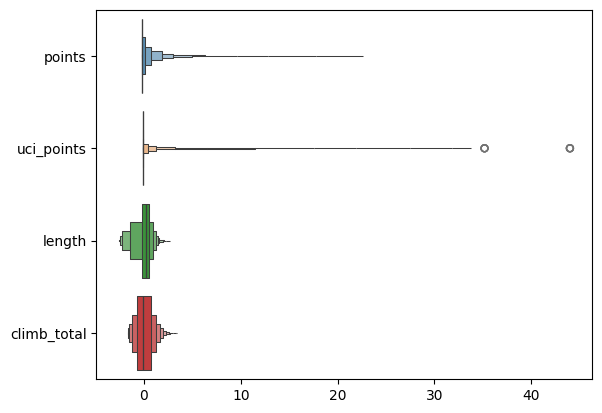

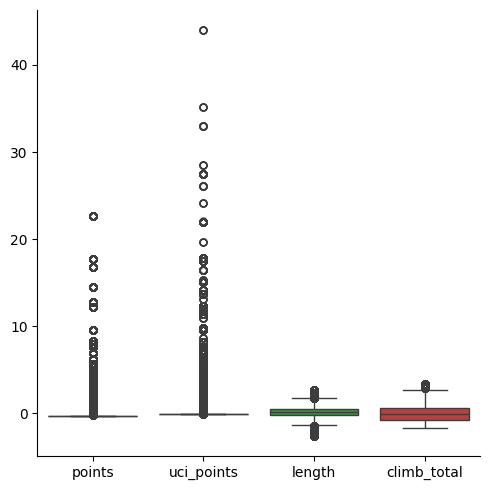

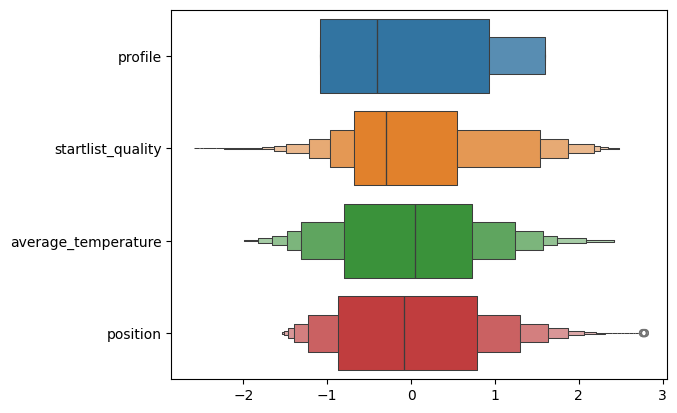

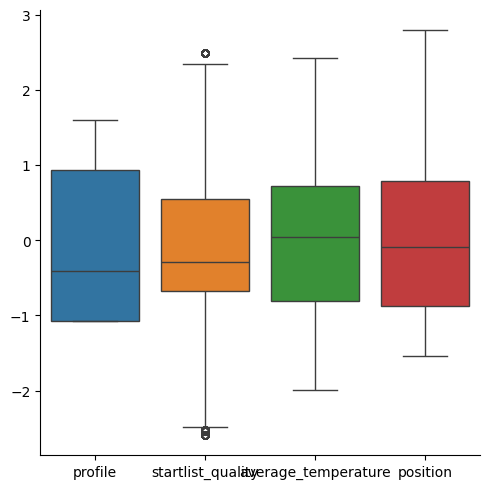

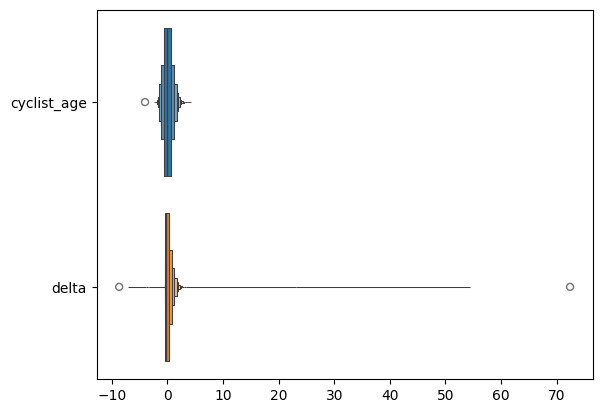

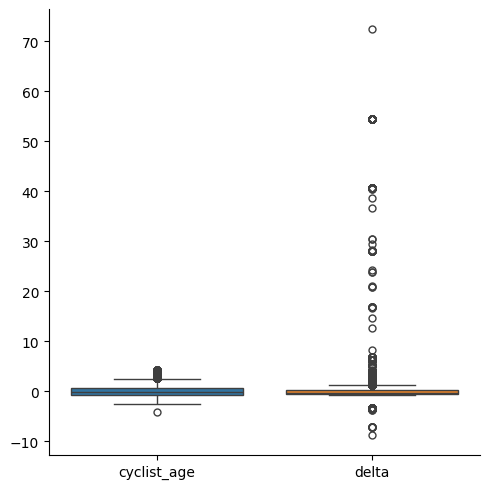

In [ ]:
InterestingFeatures = ["points", "uci_points", "length", "climb_total", "profile",
                       "startlist_quality", "average_temperature", "position", "cyclist_age", "delta"]

PlotDistributionFeatures(DatasetRace, InterestingFeatures)

Nella maggior parte delle colonne ci sono distribuzioni non uniformi e la presenza di outlier è sopratutto su "delta", "cyclists_age" e "climb_total" 

## Relationship Between Features

What follows are the most important relationships between features, in my opinion, to show.
To see a complete analysis go to file [OleksiyRelFeature.ipynb](extra_notebooks/OleksiyRelFeature.ipynb)

### Begin the analysis with a correlation matrix

Let's begin the analysis with a big correlation matrix that contains all the significant features from the `DatasetCyclists` and `DatasetRaces` frames.


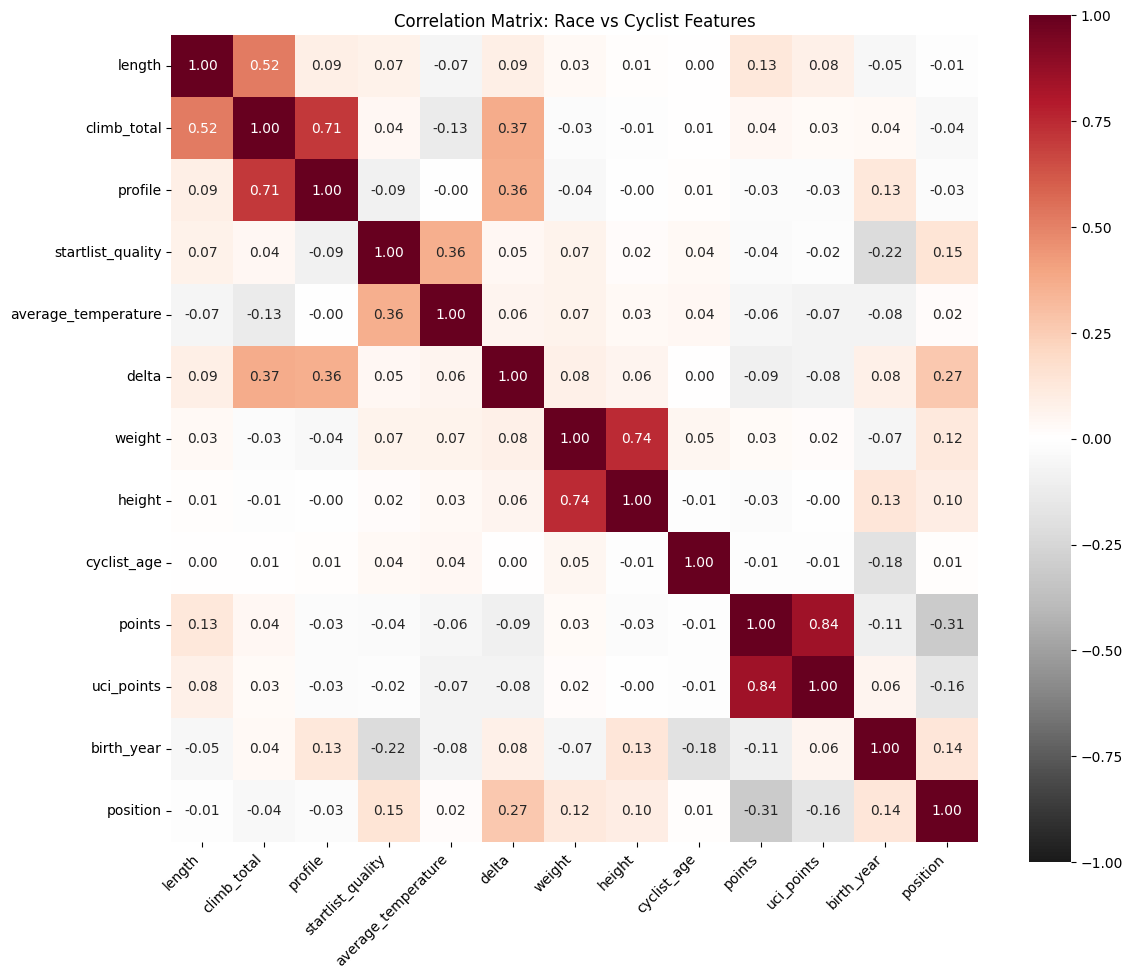

In [ ]:
from correl_code import create_correlation_matrix

columns_of_interest = [
        'length', 'climb_total', 'profile', 'startlist_quality', 
        'average_temperature', 'delta', 'weight', 'height', 
        'cyclist_age', 'points', 'uci_points', 'birth_year', 'position'
]


fig,corr_matrix = create_correlation_matrix(merged_df=MergedDataset, columns_of_interest=columns_of_interest)
plt.show()
plt.close(fig)


#### Since the best correlations might be hard to see, I will show below the top 6 positive and negative ones.


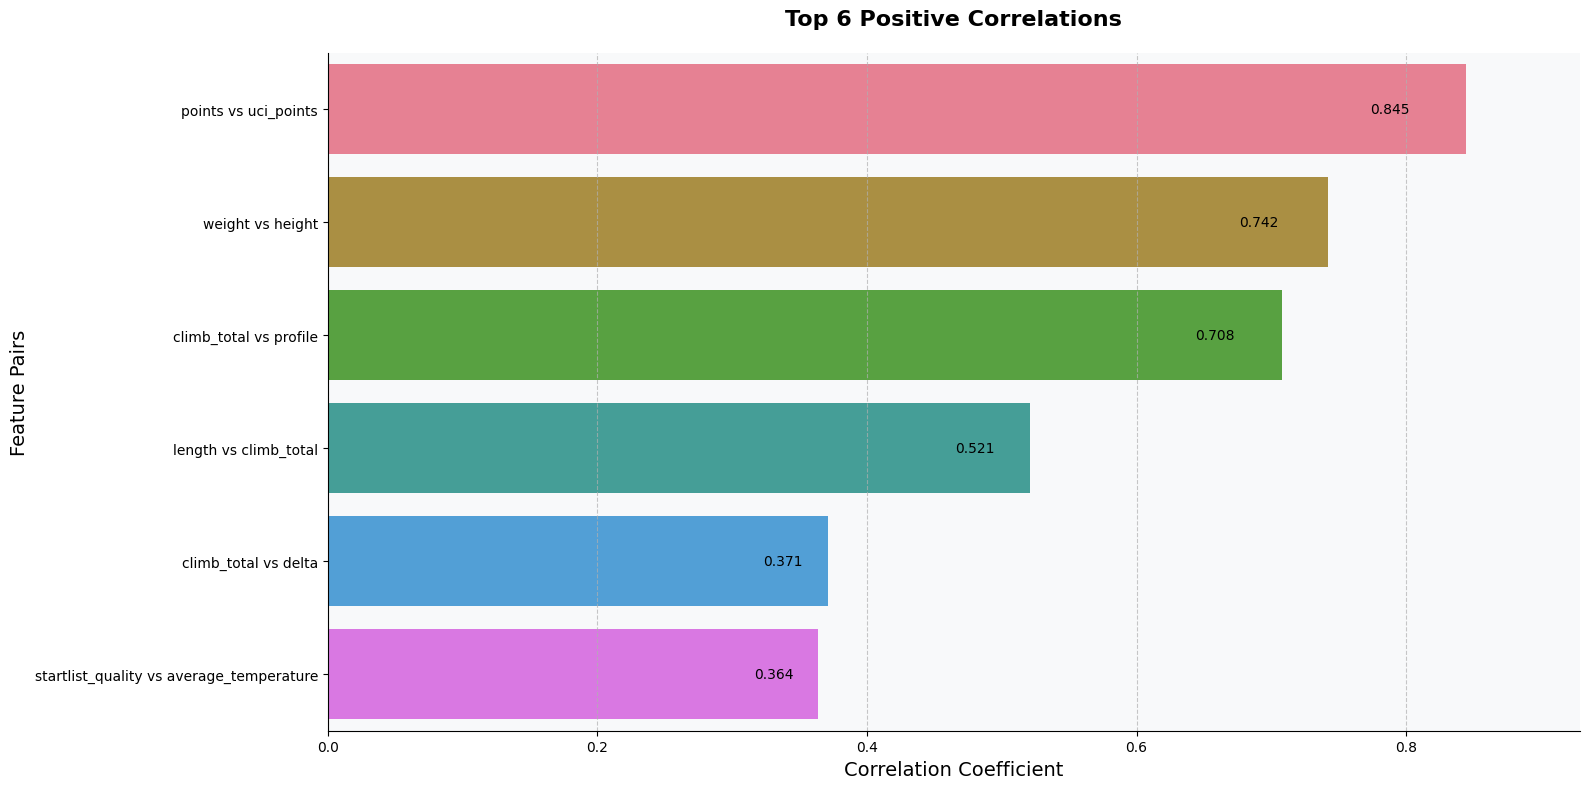

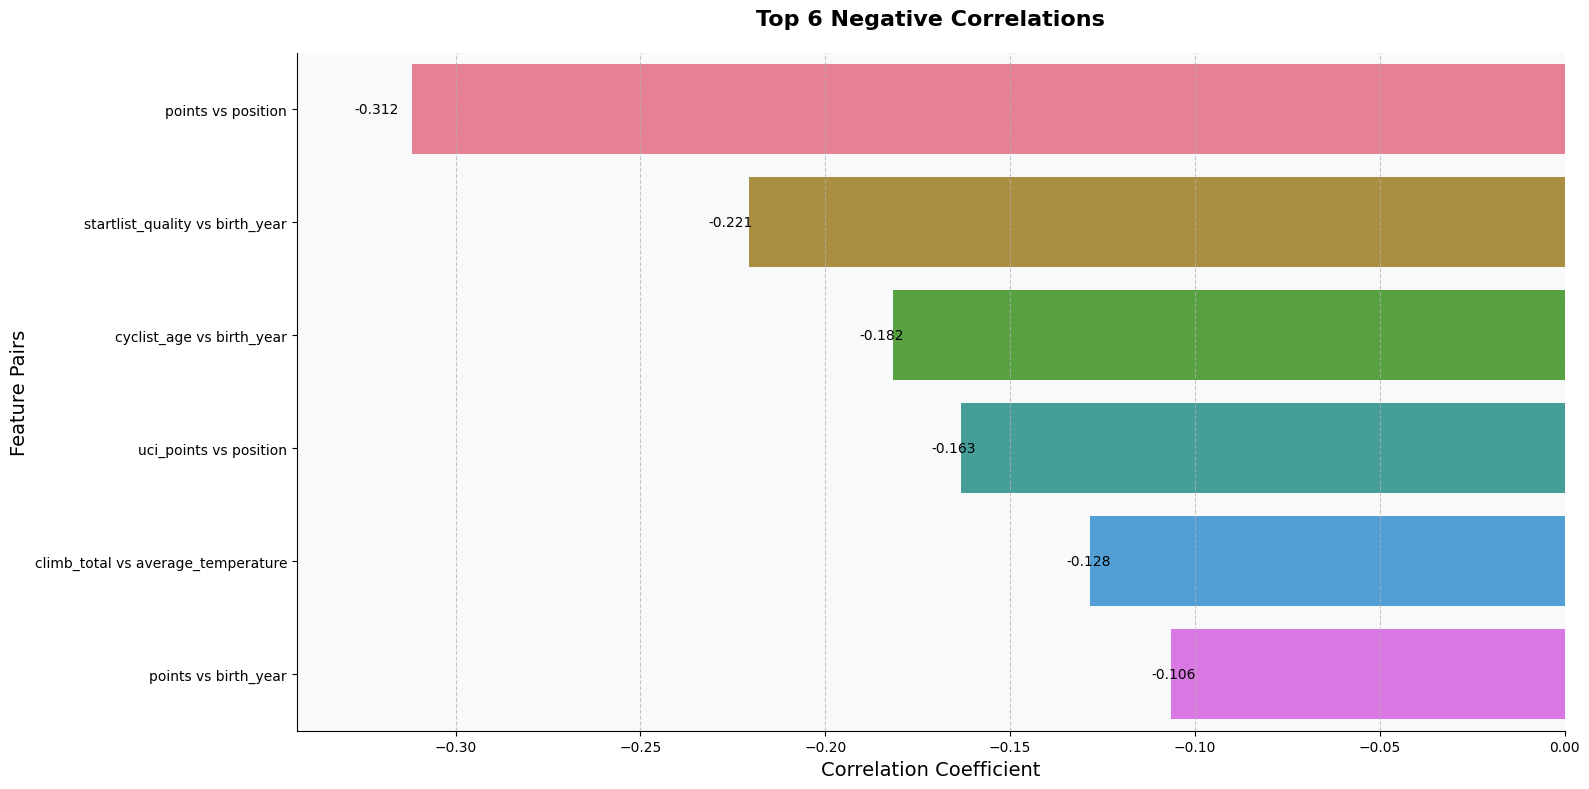

In [ ]:
from correl_code import display_top_correlations, print_top_positive_correlations, print_top_negative_correlations
dfs = display_top_correlations(corr_matrix)

# Create the figure and axis with a specific size
print_top_positive_correlations(dfs[0], "Top 6 Positive Correlations")
print_top_negative_correlations(dfs[1], "Top 6 Negative Correlations")


#### Comments on the positive correlations
There are expected positive correlations like `weight` and `height`. Something that might be of interest is the correlation between `points` and `uci_points`. What is surprising is the small correlation between `climb_total` and `delta`, but it probably makes sense since the bigger the climb, the further cyclists will arrive from the first one.There are expected positive correlations like `weight` and `height`. Something that might be of interest is the correlation between `points` and `uci_points`. What is surprising is the small correlation between `climb_total` and `delta`, but it probably makes sense since the bigger the climb, the further cyclists will arrive from the first one.There are expected positive correlations like `weight` and `height`. Something that might be of interest is the correlation between `points` and `uci_points`. What is surprising is the small correlation between `climb_total` and `delta`, but it probably makes sense since the bigger the climb, the further cyclists will arrive from the first one.

#### Comments on the negative correlations

There is a small correlation between the ```startlist_quality``` feature and the birth_year, which might suggest that if the race has many young riders, it will have lower `startlist_quality`. The negative correlation between points and `birth_year` makes sense since younger cyclists tend to have fewer `points`.

There is a slightly negative correlation between the `average_temperature` and `uci_points` that can be further investigated.


#### `weight`, `height` and race `profile` influence the `position`? 

Let's see if the `weight` and `height` of the riders, coupled with the race `profile`, influence the position of the cyclist.

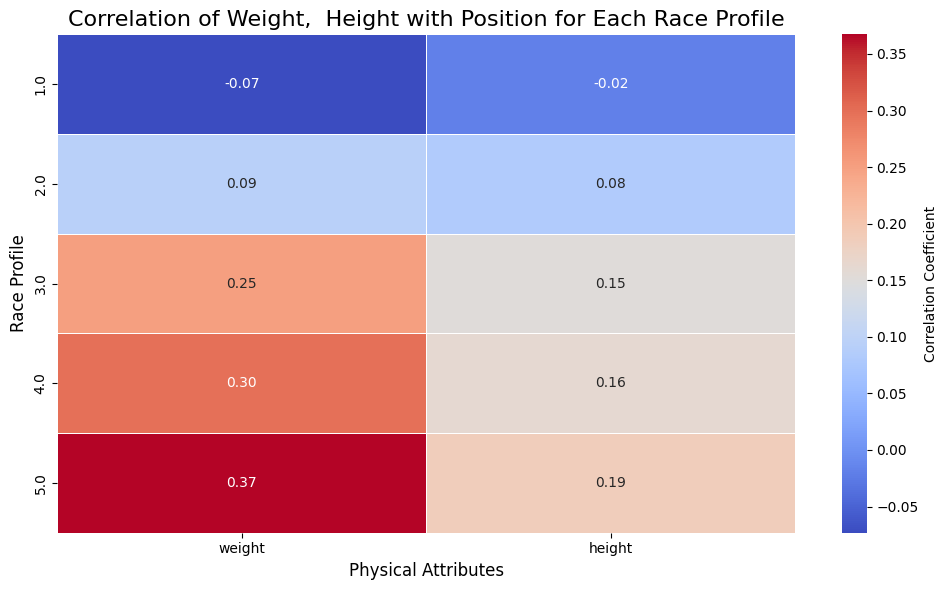

In [ ]:
whpp_cor_feat = ['weight', 'height', 'position', 'profile']
whpp_cor_df = MergedDataset[whpp_cor_feat].copy()

correlations = whpp_cor_df.groupby('profile')[['weight', 'height', 'position']].corr()

correlations = correlations.xs('position', level=1).drop('position', axis=1)

# Plotting the heatmap
plt.figure(figsize=(10, 6))
heatmap = seaborn.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})

# Customize the heatmap
heatmap.set_title('Correlation of Weight,  Height with Position for Each Race Profile', fontsize=16)
heatmap.set_xlabel('Physical Attributes', fontsize=12)
heatmap.set_ylabel('Race Profile', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()
plt.close()
del whpp_cor_df

It clearly shows that lighter riders tend to finish in better positions when the climbing is significant, which makes perfect sense. The height has a smaller correlation, but we can still say that height might influence the final position of the rider if the race has a high profile.

### Correlation between `average_temperature`, `nationality`, and `age_group`

Even though the `average_temperature` column has many `NaN` values, it is interesting to examine the mentioned correlations.



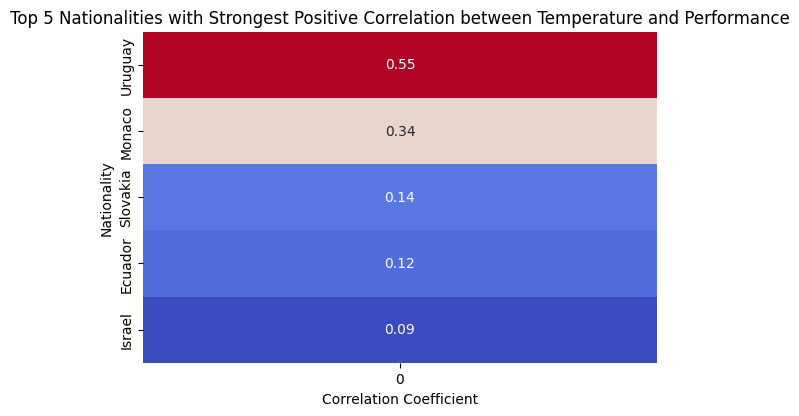

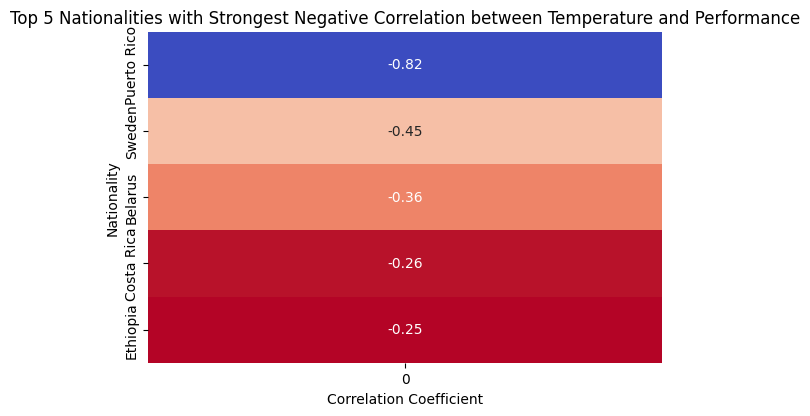

In [ ]:
from correl_code import calc_group_correlations

ana_cor_feat = ['average_temperature', 'points', 'uci_points', 'position', 'nationality', 'cyclist_age']
ana_cor_df = MergedDataset[ana_cor_feat].copy()

# where uci_points is not null and position is null insert insert uci_points in position
ana_cor_df['position'] = ana_cor_df['position'].fillna(ana_cor_df['uci_points'])
ana_cor_df.dropna(subset=['points', 'average_temperature'], inplace=True)

nationality_correlations = calc_group_correlations(ana_cor_df, 'nationality')

heatmap_data = nationality_correlations.nlargest(5).to_frame()


heatmap = seaborn.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
heatmap.set_title('Top 5 Nationalities with Strongest Positive Correlation between Temperature and Performance')
heatmap.set_xlabel('Correlation Coefficient')
heatmap.set_ylabel('Nationality')

plt.tight_layout(pad=3.0, w_pad=1.0, h_pad=1.0)
plt.show()
plt.close()

heatmap = seaborn.heatmap(nationality_correlations.nsmallest(5).to_frame(), annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
heatmap.set_title('Top 5 Nationalities with Strongest Negative Correlation between Temperature and Performance')
heatmap.set_xlabel('Correlation Coefficient')
heatmap.set_ylabel('Nationality')

plt.tight_layout(pad=3.0, w_pad=1.0, h_pad=1.0)
plt.show()
plt.close()


As the correlation shows, riders coming from warmer countries may perform better in higher temperatures. In contrast, athletes from colder countries might struggle as temperatures rise. The outlier here is Puerto Rico, which could be interesting to investigate further.

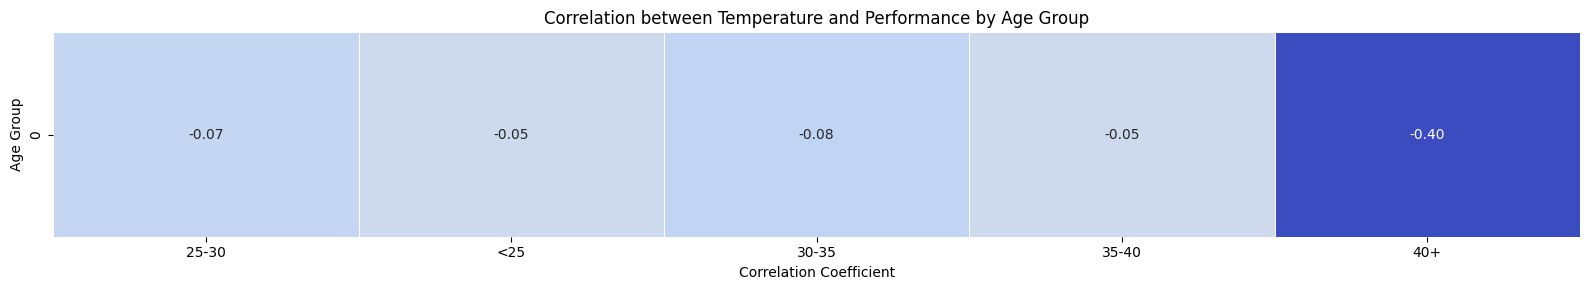

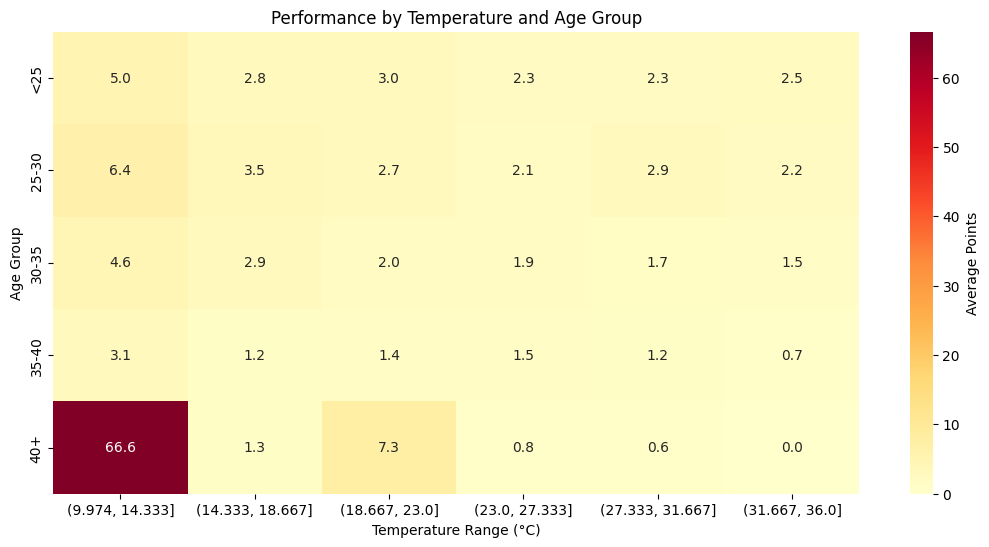

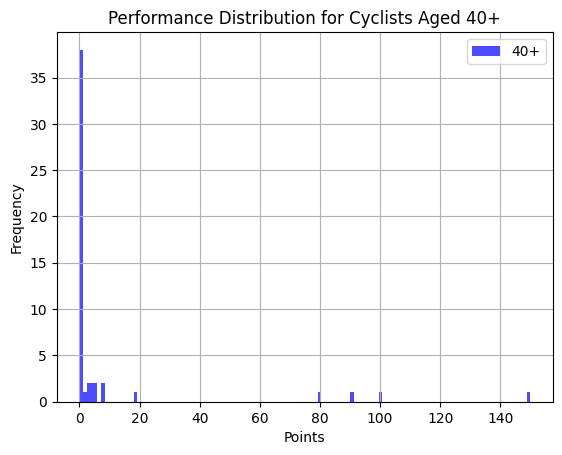

In [ ]:
plt.figure(figsize=(16, 3))
ana_cor_df['age_group'] = pd.cut(ana_cor_df['cyclist_age'], bins=[0, 25, 30, 35, 40, 100], labels=['<25', '25-30', '30-35', '35-40', '40+'])
pivot = ana_cor_df.pivot_table(values='points', index='age_group', observed=True, columns=pd.cut(ana_cor_df['average_temperature'], bins=6), aggfunc='mean')
age_group_correlations = calc_group_correlations(ana_cor_df, 'age_group')

heatmap = seaborn.heatmap(age_group_correlations.to_frame().T, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt=".2f", cbar=False)
heatmap.set_title('Correlation between Temperature and Performance by Age Group')
heatmap.set_xlabel('Correlation Coefficient')
heatmap.set_ylabel('Age Group')

plt.tight_layout()
plt.show()
plt.close()

plt.figure(figsize=(13, 6))
pivot = ana_cor_df.pivot_table(values='points', index='age_group', observed=True, columns=pd.cut(ana_cor_df['average_temperature'], bins=6), aggfunc='mean')
seaborn.heatmap(pivot, cmap='YlOrRd', annot=True, fmt='.1f', cbar_kws={'label': 'Average Points'})
plt.title('Performance by Temperature and Age Group')
plt.xlabel('Temperature Range (°C)')
plt.ylabel('Age Group')
plt.show()
plt.close()
ana_cor_df[ana_cor_df['age_group'] == '40+']['points'].hist(bins='auto', alpha=0.7, color='blue', label='40+')
plt.title('Performance Distribution for Cyclists Aged 40+')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.legend()
plt.show()
plt.close()

del ana_cor_df


The correlation between temperature and age groups might suggest that the older the rider, the stronger the temperature influences the rider's performance. However, as we can see in the second figure, there is an anomalously high average points in the colder temperature range for the 40+ age group, which might indicate outliers. Moreover, the histogram clearly shows that these are outliers due to their frequency.

### Cyclist's Career Span

Next, we will see the career span of top cyclists and how age influences their performance.


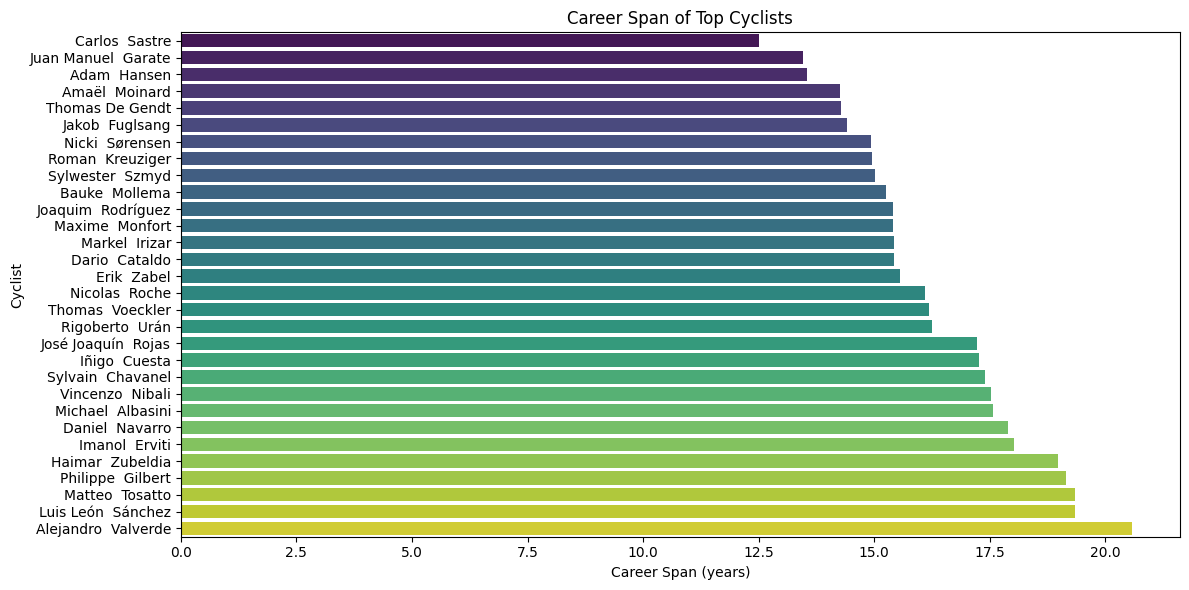

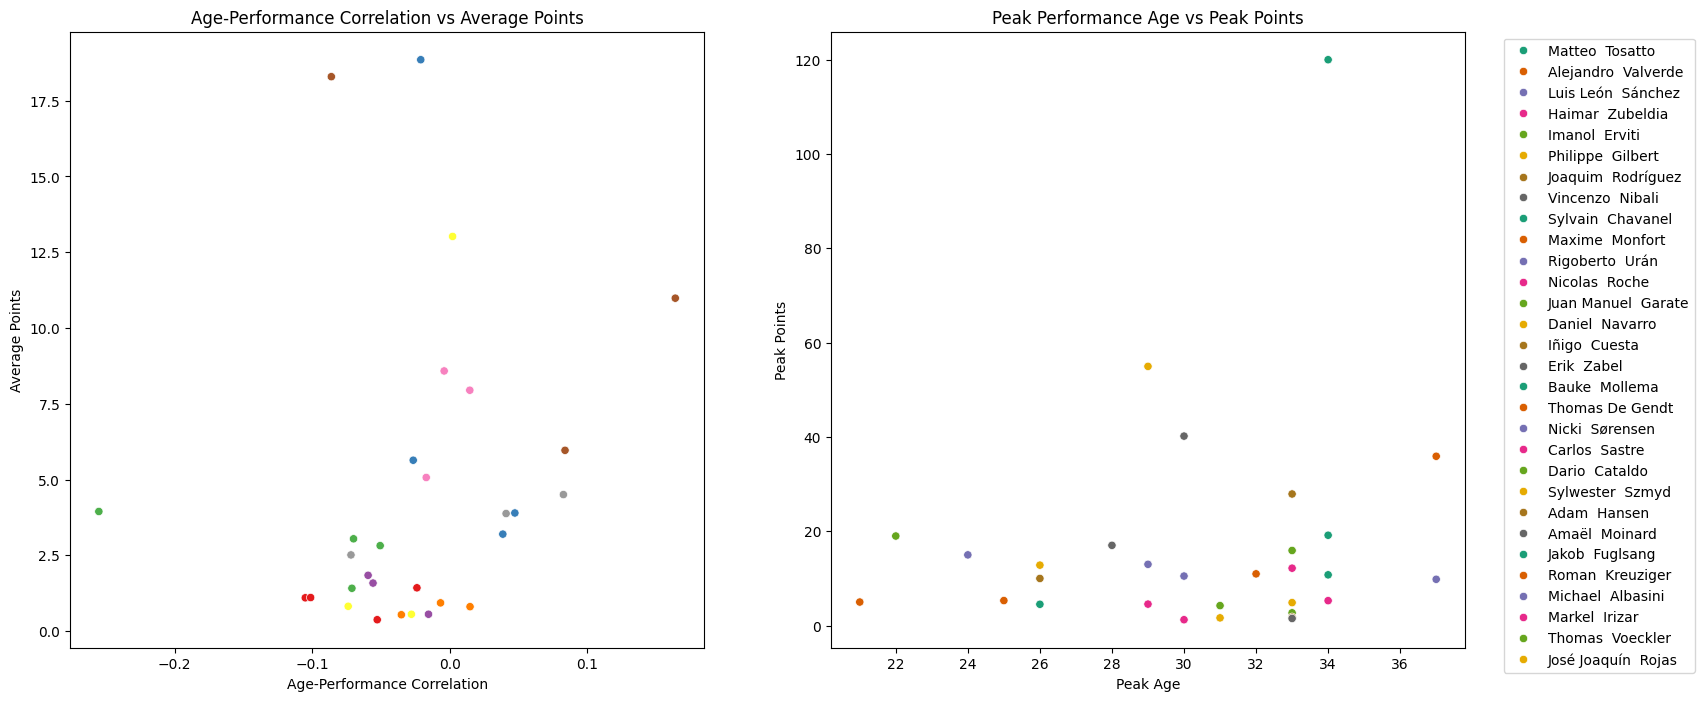

In [ ]:
from correl_code import analyze_cyclist_progression, analyze_performance_peaks

cs_cor_feat = ['points', 'uci_points', 'position', 'date', 'name', 'cyclist_age', 'cyclist', 'birth_year']
cs_cor_dr = MergedDataset[cs_cor_feat].copy()
cs_cor_dr['date'] = pd.to_datetime(cs_cor_dr['date'])
cs_cor_dr['year'] = cs_cor_dr['date'].dt.year
top_cyclists = cs_cor_dr['cyclist'].value_counts().index[:30]
progression_data = [analyze_cyclist_progression(cyclist, cs_cor_dr, plot=False) for cyclist in top_cyclists]

progression_df = pd.DataFrame([data for data in progression_data if data is not None])

plt.figure(figsize=(12, 6))
seaborn.barplot(
    x='career_span', 
    y='name', 
    data=progression_df.sort_values('career_span'), 
    hue='name', 
    dodge=False,  # This avoids separating bars by hue
    palette='viridis', 
    legend=False
)
plt.title('Career Span of Top Cyclists')
plt.xlabel('Career Span (years)')
plt.ylabel('Cyclist')
plt.tight_layout()
plt.show()
plt.close()




# Visualize age-performance correlation
fig = plt.figure(figsize=(18, 8))
gs = plt.GridSpec(1, 2, figure=fig, wspace=0.2, hspace=0.2)

ax1 = fig.add_subplot(gs[0, 0])
seaborn.scatterplot(x='age_performance_correlation', y='avg_points', data=progression_df, hue='name', palette='Set1')
ax1.set_title('Age-Performance Correlation vs Average Points')
ax1.set_xlabel('Age-Performance Correlation')
ax1.set_ylabel('Average Points')
ax1.get_legend().remove()

peak_df = pd.DataFrame([analyze_performance_peaks(cyclist, cs_cor_dr) for cyclist in top_cyclists])

ax2 = fig.add_subplot(gs[0, 1])
# Visualize peak ages with annotations
seaborn.scatterplot(x='peak_age', y='peak_points', data=peak_df, hue='name', palette='Dark2')
ax2.set_title('Peak Performance Age vs Peak Points')
ax2.set_xlabel('Peak Age')
ax2.set_ylabel('Peak Points')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.tight_layout()
plt.show()
plt.close()


del peak_df 
del progression_df


We can see that there aren't many cyclists with long careers. We can also see that for some, age has a negative effect, while for others, it has a slightly positive one. The peak performance, for the majority, occurs in the span between 25 and 35 years. Some outliers are noticeable for peak performance and peak age.

#### Let's plot the age-performance correlation for each rider.

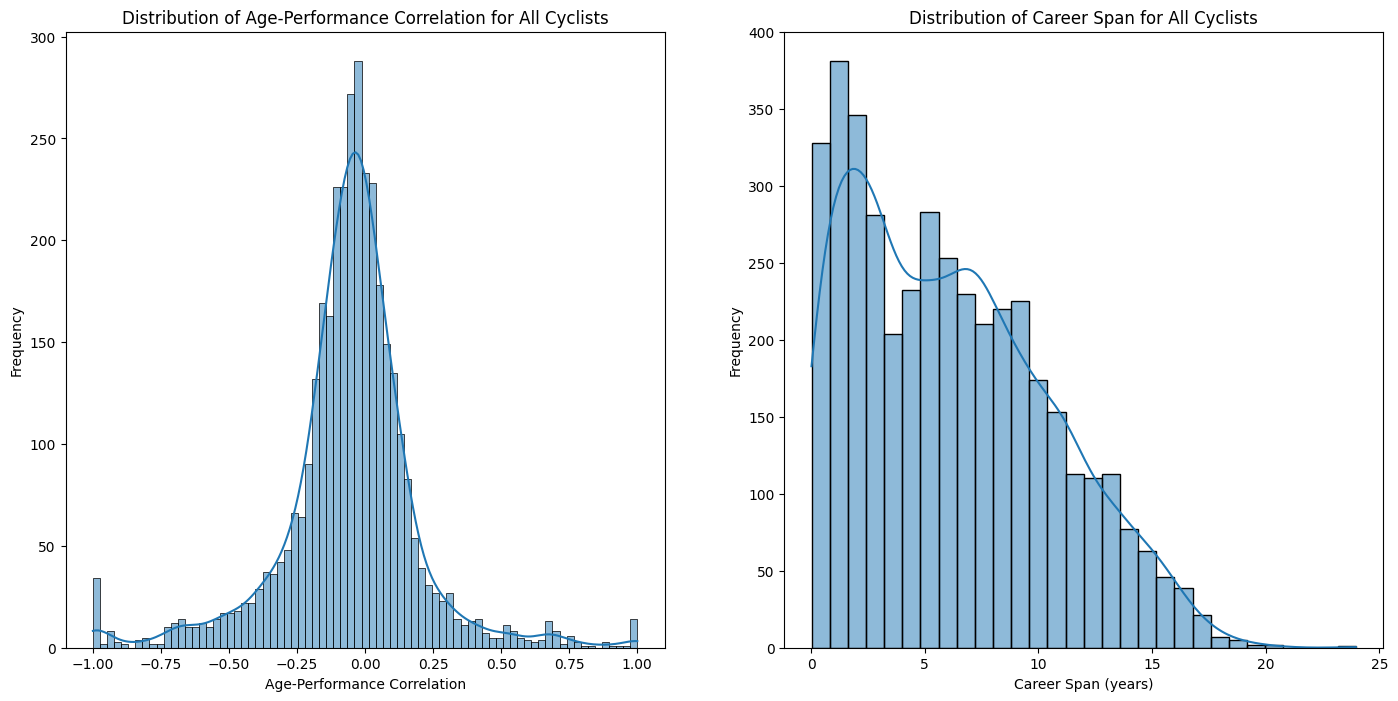

In [ ]:
all_cyclists = cs_cor_dr['cyclist'].unique()
progression_data_all_cyclists = [analyze_cyclist_progression(cyclist, cs_cor_dr, plot=False) for cyclist in all_cyclists]
progression_data_all_cyclists = [data for data in progression_data_all_cyclists if data is not None]

prog_df = pd.DataFrame(progression_data_all_cyclists)


# Visualize age-performance correlation for all cyclists
fig = plt.figure(figsize=(17, 8))
gs = plt.GridSpec(1, 2, figure=fig, wspace=0.2, hspace=0.2)

ax1 = plt.subplot(gs[0, 0])
seaborn.histplot([data['age_performance_correlation'] for data in progression_data_all_cyclists], bins="auto", kde=True)
ax1.set_title('Distribution of Age-Performance Correlation for All Cyclists')
ax1.set_xlabel('Age-Performance Correlation')
ax1.set_ylabel('Frequency')

ax2 = plt.subplot(gs[0, 1])
seaborn.histplot(prog_df['career_span'], bins=30, kde=True)
ax2.set_title('Distribution of Career Span for All Cyclists')
ax2.set_xlabel('Career Span (years)')
ax2.set_ylabel('Frequency')
plt.show()
plt.close(fig)
del prog_df
del cs_cor_dr

The results show a clearly bell-shaped distribution, which isn't surprising. For some, age does hinder performance, but for most, it doesn't.

As regards the histogram of career span, we can see that the distribution is right-skewed, meaning there are very few cyclists with long careers. Surprisingly, the number of riders that have a cycling span between 0 and 3 years is high, which might mean that cycling is a very physically demanding sport.

### Physical Attributes of Top Performers by Race Type


In [ ]:
from correl_code import radar_plot

tprt_rad_feat = ['name', 'height', 'weight', 'date', 'profile', 'points', 'cyclist_age']

tprt_rad_df = MergedDataset[tprt_rad_feat].copy().dropna(subset=['height', 'weight', 'points'])

# Calculate BMI
tprt_rad_df['bmi'] = tprt_rad_df['weight'] / ((tprt_rad_df['height'] / 100) ** 2)

# Calculate years of experience
tprt_rad_df['career_start'] = tprt_rad_df.groupby('name')['date'].transform('min')
tprt_rad_df['experience'] = (pd.to_datetime(tprt_rad_df['date']) - pd.to_datetime(tprt_rad_df['career_start'])).dt.days / 365.25

# Function to categorize race profile
def categorize_profile(profile):
    if profile < 1.5:
        return 'Flat'
    elif profile < 3:
        return 'Hilly'
    elif profile < 4:
        return 'Mountainous'
    elif profile < 5:
        return 'High Mountainous'
    else:
        return 'Really High Mountainous'

# Add race category to the dataframe
tprt_rad_df['race_category'] = tprt_rad_df['profile'].apply(categorize_profile)

# Function to get top performer for each race category
def get_top_performer(category):
    category_data = tprt_rad_df[tprt_rad_df['race_category'] == category]
    top_cyclist = category_data.groupby('name')['points'].mean().idxmax()
    return category_data[category_data['name'] == top_cyclist].iloc[0]

# Get top performers
top_performers = {
    'Flat': get_top_performer('Flat'),
    'Hilly': get_top_performer('Hilly'),
    'Mountainous': get_top_performer('Mountainous'),
    'High Mountainous': get_top_performer('High Mountainous'),
    'Really High Mountainous': get_top_performer('Really High Mountainous')
}

# Prepare data for radar plot
attributes = ['height', 'weight', 'bmi', 'cyclist_age', 'experience']
data = {category: [cyclist[attr] for attr in attributes] for category, cyclist in top_performers.items()}

# Normalize the data separately for each attribute
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(pd.DataFrame(data, index=attributes).T).T



# Create the plot with normalized data and cyclist names
cyclist_names = {category: cyclist['name'] for category, cyclist in top_performers.items()}
fig = radar_plot(dict(zip(top_performers.keys(), normalized_data)), 
                 "Physical Attributes of Top Performers by Race Type", cyclist_names, attributes)

# Show the plot
fig.show()
del tprt_rad_feat

We can see that there is a relationship between terrain difficulty and the rider's BMI, which in some cases has a positive impact. It can be said that the more extreme the terrain is, the more tactical experience matters.

### Relationship Between Race Property and (UCI) Points

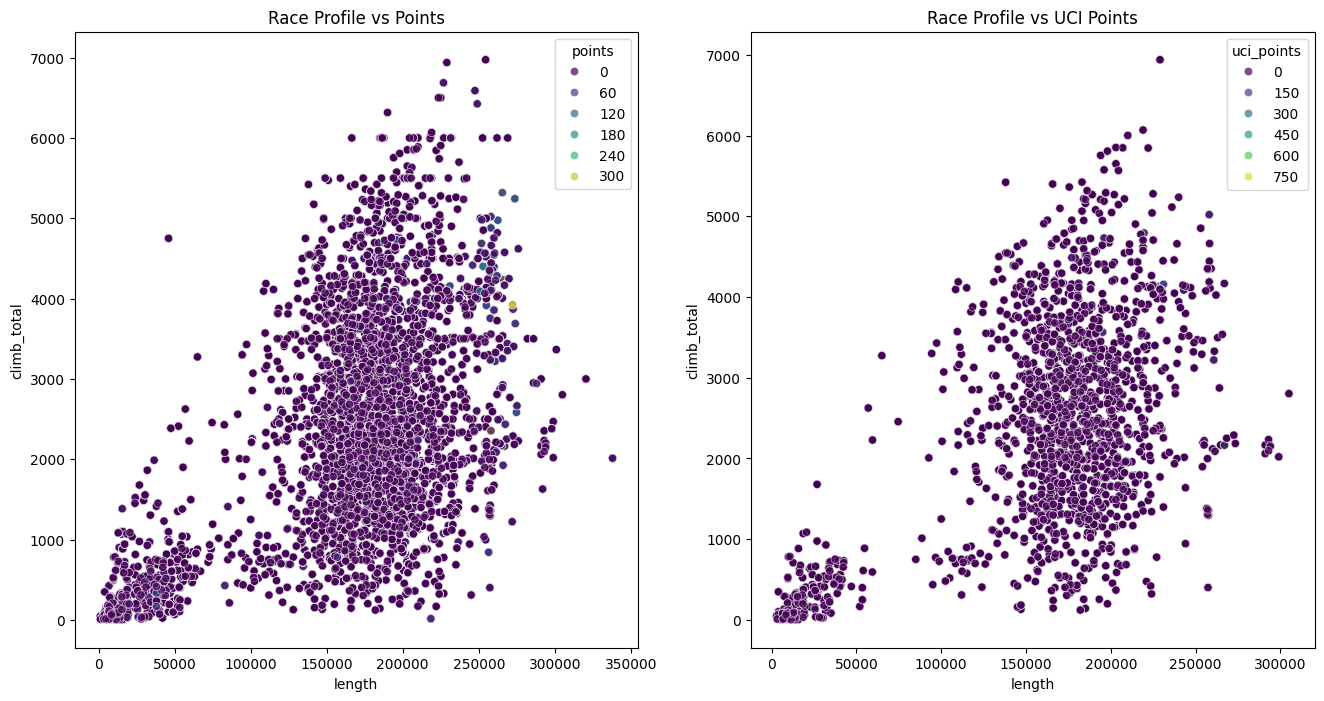

In [ ]:
rppu_scat_feat = ['length', 'climb_total', 'points', 'uci_points', 'profile']
rppu_scat_df = MergedDataset[rppu_scat_feat].copy()

# 3.1 Race Profile vs Cyclist Performance
fig = plt.figure(figsize=(16, 8))
gs = plt.GridSpec(1, 2, figure=fig, wspace=0.2, hspace=0.2)

ax1 = fig.add_subplot(gs[0, 0])
seaborn.scatterplot(x='length', y='climb_total', hue='points', data=rppu_scat_df, palette='viridis', alpha=0.7)
ax1.set_title('Race Profile vs Points')


# 3.2 Race Profile vs Cyclist UCI Points
ax2 = fig.add_subplot(gs[0, 1])
seaborn.scatterplot(x='length', y='climb_total', hue='uci_points', data=rppu_scat_df, palette='viridis', alpha=0.7)
ax2.set_title('Race Profile vs UCI Points')


plt.show()
plt.close()
del rppu_scat_feat

We can see the correlation between `points` and `uci_points`, as the scatter plots are very similar. The only notable difference is that `uci_points` tend to have higher values. Additionally, `uci_points` are more selective, with fewer high-point races compared to the general point system. However, this might be due to the fact that we have fewer `uci_points` values.

We can observe a trend where longer races with more climbing tend to award more points. These plots show that to earn high points, cyclists need to excel in both endurance and climbing ability. Riders in very short flat races have fewer opportunities for high point gains.

#### Tarmac vs Points/UCI Points and Profiles vs Points/UCI points box plots

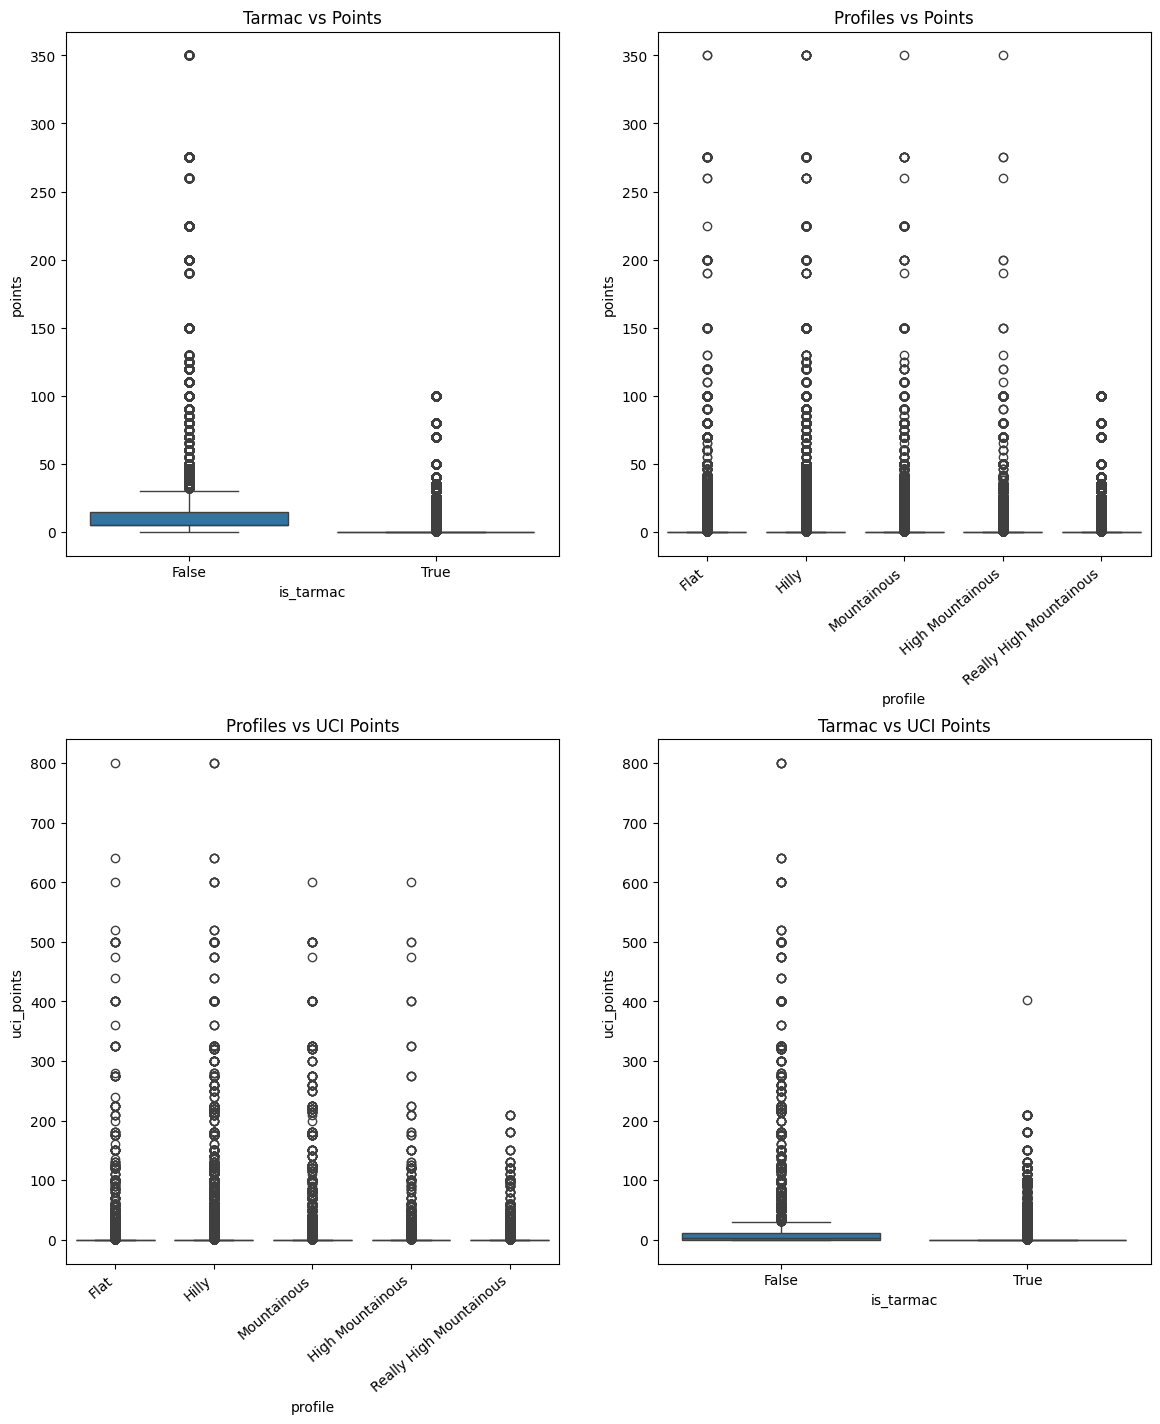

In [ ]:
seaborn.color_palette("pastel")

tpu_box_feat = ['is_tarmac', 'profile', 'points', 'uci_points']
tpu_box_dr = MergedDataset[tpu_box_feat].copy()


fig = plt.figure(figsize=(14, 16))
gs = plt.GridSpec(2, 2, figure=fig, wspace=0.2, hspace=0.35)

ax1 = fig.add_subplot(gs[0, 0])
profiles = seaborn.boxplot(x='is_tarmac', y='points', data=tpu_box_dr, ax=ax1)
ax1.set_title('Tarmac vs Points')


ax2 = fig.add_subplot(gs[0, 1])
profiles = seaborn.boxplot(x='profile', y='points', data=tpu_box_dr, ax=ax2)
profiles.set_xticks(profiles.get_xticks())
profiles.set_xticklabels(['Flat', 'Hilly', 'Mountainous', 'High Mountainous', 'Really High Mountainous'])
ax2.set_title('Profiles vs Points')
plt.xticks(rotation=40, ha='right',horizontalalignment='right')



# 5.2 Race Surface vs Cyclist UCI Points

ax3 = fig.add_subplot(gs[1, 1])
profiles = seaborn.boxplot(x='is_tarmac', y='uci_points', data=tpu_box_dr, ax=ax3)
ax3.set_title('Tarmac vs UCI Points')

ax4 = fig.add_subplot(gs[1, 0])
profiles = seaborn.boxplot(x='profile', y='uci_points', data=tpu_box_dr, ax=ax4)
ax4.set_xticks(profiles.get_xticks())
ax4.set_xticklabels(['Flat', 'Hilly', 'Mountainous', 'High Mountainous', 'Really High Mountainous'])
ax4.set_title('Profiles vs UCI Points')


plt.xticks(rotation=40, ha='right',horizontalalignment='right')
# plt.tight_layout()
plt.show()
plt.close()



The analysis of box plots comparing points and UCI points across tarmac, non-tarmac, and race profiles reveals a structured scoring system that values versatility across terrains and disciplines. In both systems, non-tarmac events—likely off-road or mountain bike races—award significantly higher points, with medians around 225 and 450 for points and UCI points, respectively, compared to lower values for tarmac races. This indicates a greater emphasis on non-tarmac disciplines, potentially to encourage participation. 

Across profiles, points are fairly similar, with medians generally between 75-100 points, though flat and extreme mountainous profiles (like "Really High Mountainous") show slightly higher medians. Outliers with much higher points in each category likely represent prestigious events, such as key stages in Grand Tours or significant classics. 

The variability within profiles, especially in hilly and mountainous categories, suggests a range of race difficulties. Flat races, although often standardized, still hold a respectable median value, while high mountainous profiles don’t always award the highest average points, yet include notable outliers. The scoring structure encourages cyclists to compete across various race types, with specialization still possible in specific profiles or terrains. 

For the UCI points specifically, the balanced distribution across race profiles on tarmac suggests an effort to value different road racing profiles equally, while the prominent role of non-tarmac events highlights a focus on promoting diverse cycling disciplines. Overall, both systems seem aimed at fostering well-rounded cyclists capable of excelling across different terrains, while also highlighting prestigious events within each category.

### Conclusions

Per la prossima fase di data transformation, sono state decise le seguenti decisioni per il dataset **race**:

- 

# **Data cleaning**

## Dataset cyclists

### Fill nationality data missing

Si va a riempire il dato mancante nella colonna "nationality", il valore è stato cercato su Google.

In [11]:
ScottDavisIndex = DatasetCyclists[DatasetCyclists["nationality"].isnull()].index[0]
DatasetCyclists.loc[ScottDavisIndex, "nationality"] = "Great Britain"

### Fill data of weight and height columns

Si va a riempire le colonne di "height" e "weight" sfruttando i dati tra loro. Si è scoperto che hanno un alta correlazione.

/tmp/ipykernel_53830/56667317.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Avoid overlapping plots


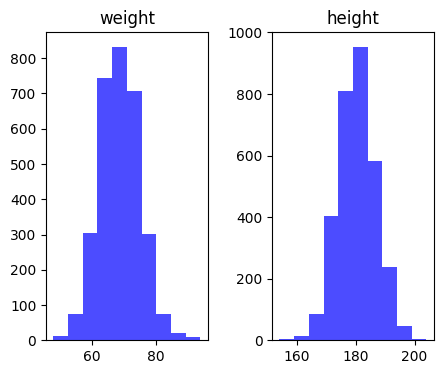

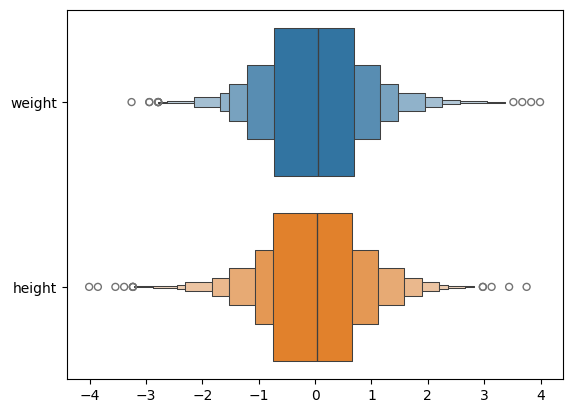

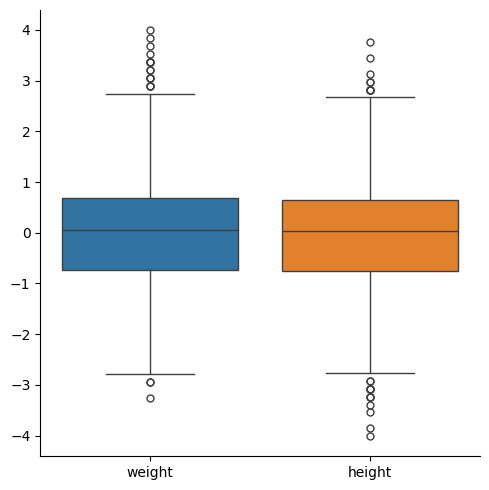

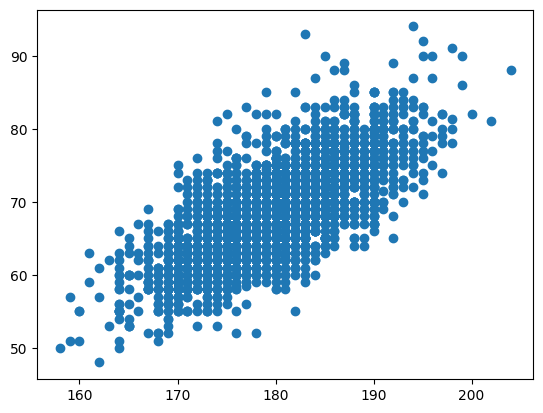

In [7]:
#Inferenza sulle colonne weight ed height
PlotDistributionFeatures(DatasetCyclists, ["weight", "height"])
plt.scatter(DatasetCyclists["height"], DatasetCyclists["weight"])

Si mostrano le distribuzioni e correlazioni delle 2 colonne tra loro.

In [ ]:
TrainData = DatasetCyclists.dropna(subset=['weight', 'height'])

#Predizione dei valori sulle righe dove height c'è e weight manca (regressore lineare) e viceversa (con un altro regressore lineare)
HeightPredictor = LinearRegression()
WeightPredictor = LinearRegression()

#Allenamento dei regressori
for _ in range(1):
    HeightPredictor.fit(TrainData[['weight']], TrainData[['height']])
    WeightPredictor.fit(TrainData[['height']], TrainData[['weight']])

#Calcolo degl' indici dove andare a riempire i valori
HeightSlot = DatasetCyclists[DatasetCyclists['height'].isna() & DatasetCyclists['weight'].notna()]
WeightSlot = DatasetCyclists[DatasetCyclists['weight'].isna() & DatasetCyclists['height'].notna()]

#Calcolo dei valori mancanti
DatasetCyclists.loc[WeightSlot.index, 'weight'] = WeightPredictor.predict(WeightSlot[['height']])
DatasetCyclists.loc[HeightSlot.index, 'height'] = HeightPredictor.predict(HeightSlot[['weight']])

#Predizione dei valori sulle righe dove manca sia height che weight (distribuzione)
ColumnsCleaned = DatasetCyclists[["weight", "height"]].dropna()

#Creazione della distribuzione multivariata (2 dimensioni)
Distribution = stats.multivariate_normal([ColumnsCleaned["weight"].mean(), ColumnsCleaned["height"].mean()],
                                   np.cov(ColumnsCleaned["weight"], ColumnsCleaned["height"]))

#Calcolo degl' indici dei valori missing
MissingIndex = DatasetCyclists[DatasetCyclists[['weight', 'height']].isna().any(axis=1)].index

#Riempimento dei valori mancanti con la distribuzione multivariata
DatasetCyclists.loc[MissingIndex, ['weight', 'height']] = Distribution.rvs(size=len(MissingIndex))


Si allena un regressore lineare per inferire sui dati "weight".
Si allena un regressore lineare per inferire sui dati "height".

Per i regressori si prepara un insieme di dati che sono le coppie dove ci sono entrambi i valori.

Si costruisce una distribuzione multivariata (2 dimensioni) usando i dati a disposizione + i dati inferiti con i regressori, dopodichè si campionano dei dati per poter inferire sui dati mancanti.

/tmp/ipykernel_18961/56667317.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Avoid overlapping plots


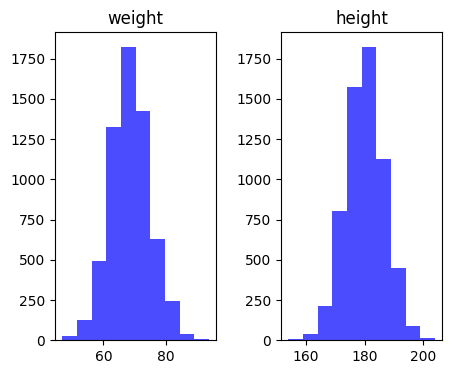

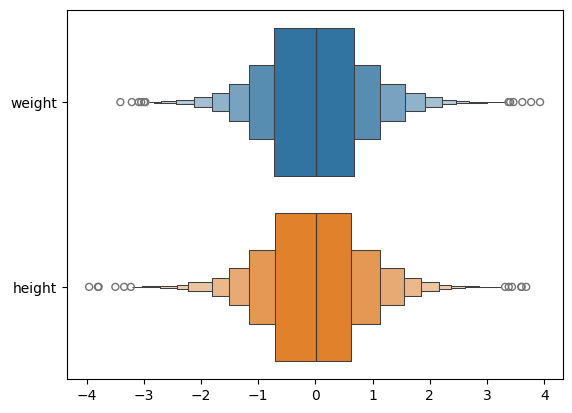

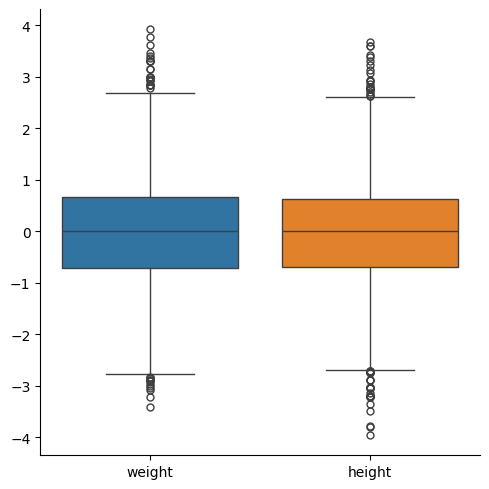

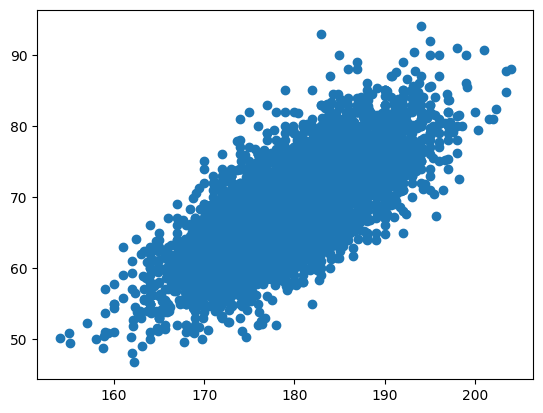

In [7]:
PlotDistributionFeatures(DatasetCyclists, ["weight", "height"])
plt.scatter(DatasetCyclists["height"], DatasetCyclists["weight"])

Si mostrano le distribuzioni e correlazioni delle colonne tra loro dopo il riempimento dei dati mancanti.

### Fill data of birth_year column (Riccardo)

In [11]:
PreProcessing = DatasetRace.dropna(subset=["cyclist", "date", "cyclist_age"])

PreparedDatasetRace = pd.DataFrame({
    'name': PreProcessing["cyclist"],
    'date': list(map(lambda x, y: float(x.split("-")[0]) - y, PreProcessing["date"], PreProcessing["cyclist_age"]))
})

#Serve per vedere se per ogni ciclista ci sono più date di nascita calcolate, se si c'è un problema
GroupByCyclist = PreparedDatasetRace.groupby("name")
Counts = GroupByCyclist["date"].nunique()

for name in Counts.keys():
    if(Counts[name] != 1): print(f"Risulta che l' atleta {name} non abbia una sola data ma: [{', '.join(list(set(GroupByCyclist['date'])))}]")

Non si sono presentati problemi, per ogni atleta si è calcolata una sola data di nascita considerando tutte le sue corse, quindi i dati interessati (date e cyclist_age) non sono sbagliati. Ora si usano questi dati per metterli dentro le date di nascita del dataset cyclists.

In [14]:
Association = {name: date for date, name in zip(GroupByCyclist["date"].mean(), Counts.keys())}

DatasetCyclists["birth_year"] = DatasetCyclists["birth_year"].fillna(DatasetCyclists["_url"].map(Association))

print(f"Ciclisti con anno di nascita disponibile dentro la ricerca: {len(list(set(Association.keys()).intersection(set(DatasetCyclists.dropna(subset=['birth_year'])['_url']))))}")

Ciclisti con anno di nascita disponibile dentro la ricerca: 6070


La ricerca non è servita a niente per riempire i valori mancanti (ma è servita per ricalcolare tutte le date di nascite giuste, visto che sono tutte del 1970), perchè tutti i ciclisti di cui si è calcolate le età già avevano l' eta disponibile, quindi si prova con la ricerca su google

In [9]:
DatasetCyclists.loc[DatasetCyclists["_url"] == "scott-davies", "birth_year"] = 1995
DatasetCyclists.loc[DatasetCyclists["_url"] == "vladimir-malakov", "birth_year"] = 1958
DatasetCyclists.loc[DatasetCyclists["_url"] == "antonio-zanini", "birth_year"] = 1965
DatasetCyclists.loc[DatasetCyclists["_url"] == "filippo-simonetti", "birth_year"] = 1971
DatasetCyclists.loc[DatasetCyclists["_url"] == "carlos-garcia", "birth_year"] = 1964
DatasetCyclists.loc[DatasetCyclists["_url"] == "alexandr-osipov", "birth_year"] = 1961
DatasetCyclists.loc[DatasetCyclists["_url"] == "nicolai-kosyakov", "birth_year"] = 1960
DatasetCyclists.loc[DatasetCyclists["_url"] == "nevens-guy", "birth_year"] = 1958
DatasetCyclists.loc[DatasetCyclists["_url"] == "oscar-pumar", "birth_year"] = 1970
DatasetCyclists.loc[DatasetCyclists["_url"] == "javier-luquin", "birth_year"] = 1963
DatasetCyclists.loc[DatasetCyclists["_url"] == "thierry-lauder", "birth_year"] = 1974
DatasetCyclists.loc[DatasetCyclists["_url"] == "batik-odriozola", "birth_year"] = 1970
DatasetCyclists.loc[DatasetCyclists["_url"] == "sergei-jermachenko", "birth_year"] = 1961

### View final dataset cleaned

             Total values  Missing values  Usable values
Elements                                                
_url                 6134               0           6134
name                 6134               0           6134
birth_year           6134               0           6134
weight               6134               0           6134
height               6134               0           6134
nationality          6134               0           6134


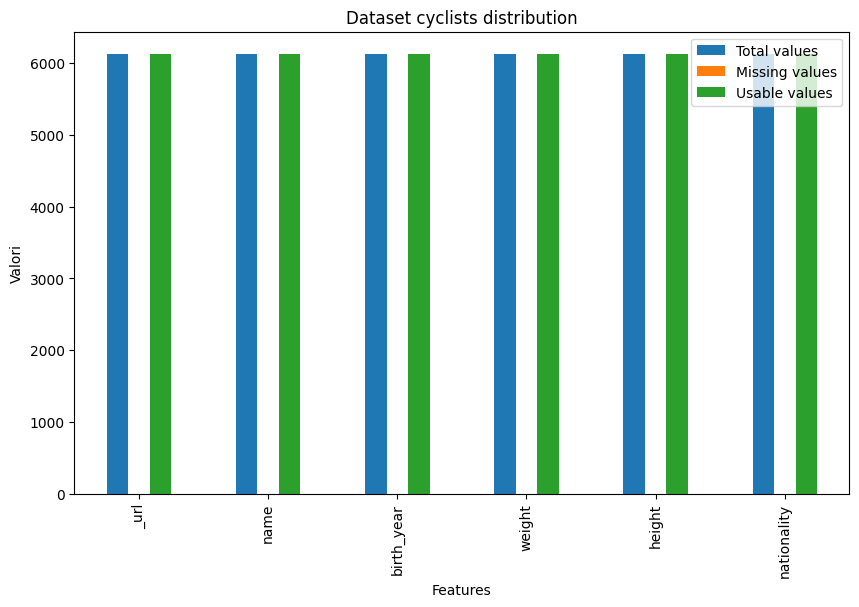

In [12]:
PlotMissingUsableData(DatasetCyclists, "cyclists")

## Dataset race

We discovered two main issues in the dataset:

1. Points Duplication Issue

   - The points and uci_points columns contained identical values across all cyclists within each race
   - These values appeared to be copied from the first-place finisher's point allocation
   - This error likely occurred during the web scraping process
   - Position Recording Issue

2. Position Recording Issue

   - Disqualified cyclists retained their original positions in the dataset
   - Subsequent riders were incorrectly shifted down one position
   - Example: If a cyclist in 15th place was disqualified, the replacement rider was incorrectly listed in 16th place

Based on our investigation, we identified [ProCyclingStats](https://www.procyclingstats.com/index.php) as the likely source of the original data scraping. To ensure data accuracy, we decided to perform a new scraping of this website. The code implementing this improved scraping process is available in our data scraping notebook [OleksiyDataScraping.ipynb](extra_notebooks/OleksiyDataScraping.ipynb).

### Delete average_temperature feature

Si toglie la tabella "average_temperature", è irrilevante e non ha nessuna correlazione con altre tabelle.

In [3]:
#Tolgo la feautres average_temperature
del DatasetRace["average_temperature"]

### Replace `nan` values of cyclists_age column (Riccardo)

In [4]:
DatasetRace['date'] = pd.to_datetime(DatasetRace['date'])
DatasetRace['race_year'] = DatasetRace['date'].dt.year

MergeDataset = DatasetRace.merge(DatasetCyclists[['_url', 'birth_year']], left_on='cyclist', right_on='_url', how='left')
MergeDataset['aged_at_race'] = MergeDataset['race_year'] - MergeDataset['birth_year']

DatasetRace['cyclist_age'] = MergeDataset['aged_at_race']



### Restore delta values (Race dataset)

In [ ]:
Races = [i for i in DatasetRace.sort_values(by=["_url", "position"]).groupby('_url')]

for NameRace, Race in Races:

    # Creare una colonna per identificare dove i valori sono uguali o negativi rispetto al precedente
    Race['Candidate'] = (Race['delta'].le(Race['delta'].shift().fillna(Race['delta'])) | (Race['delta'] < 0))

    # Identificare le sotto-sequenze con un identificatore unico
    Race['index_seq'] = (Race['Candidate'] == False).cumsum()
    
    Indexes = list(set(Race["index_seq"]))
    
    for i in range(len(Indexes[:-1])):

        if(Race[Race['index_seq'] == Indexes[i]].shape[0] > 4):
            
            PredictedValues = np.random.uniform(Race[Race["index_seq"] == Indexes[i]].iloc[0]["delta"],
                                  Race[Race["index_seq"] == Indexes[i+1]].iloc[0]["delta"],
                                  Race[Race["index_seq"] == Indexes[i]]["delta"].count() - 1).astype(int)
            
            PredictedValues.sort()
            
            DatasetRace.loc[Race[Race["index_seq"] == Indexes[i]].iloc[1:].index, "delta"] = PredictedValues
            
    PredictedValues = np.random.uniform(Race[Race["index_seq"] == Indexes[-1]].iloc[0]["delta"],
                                Race[Race["index_seq"] == Indexes[-1]].iloc[0]["delta"] + 2*(Race[Race["index_seq"] == Indexes[-1]]["delta"].count() - 1),
                                Race[Race["index_seq"] == Indexes[-1]]["delta"].count() - 1).astype(int)
            
    PredictedValues.sort()
            
    DatasetRace.loc[Race[Race["index_seq"] == Indexes[-1]].iloc[1:].index, "delta"] = PredictedValues
    
    del Race["Candidate"]
    del Race["index_seq"] 


### Replace `nan` values of `climb_total`, `profile` and `uci_points`  columns (Oleskiy)

#### Introduction

* Our approach to filling the `nan` data involved comparing three possible methods. The first was to implement an algorithm that runs multiple regressors, both linear and non-linear, and selects the best one based on specified metrics. 

* The second was to cluster the the races based on features most correlated with the predicted column, fit multiple probability distribution  (e.g., `stats.gamma`. `stats.lognorm`), and select the optimal one based on  `kstest` + `momemtum_score` + `density_score` overall metric. 
  
* The third and final method was to fit a `KNNImputer`. 

To predicte the  `climb_total`, `profile` was used the first approach, since it it the most flexible, since it gave different best regressor, based on `RMSE` metric.

What follows is the code of the three methods. But before, we need to preper the dataframe.

#### Regressors comparing algorithm

This code compares and evaluates multiple machine learning regression models (including Random Forest, XGBoost, Linear Regression, etc.) for predicting a specific feature. It:

- Takes a dataset and trains multiple regression models
- Evaluates each model using metrics (RMSE, R², cross-validation)
- Creates visualizations comparing model performance
- Generates residual plots for the best performing model
- Returns the trained models, performance summary, and predictions for missing values

It's essentially a model evaluation and selection pipeline that helps identify the best regression model for a specific prediction task.

#### Density based approach

This code compares different fitted distribution on a cluster of similar points, e.g. `stats.burr`, `stats.gaussian_mix`, and choose the best one based on the weighted sum of scores (see [densities_based.py:125](data_pred_code/densities_based.py)).

- Segments data into clusters based on similar features
- Fits statistical distributions to each segment
- Predicts missing values using the best-fitted distributions
- Provides confidence scores for predictions

It's essentially fits a statistical distribution for each cluster of points obtained with `KMeans`.

#### K-Nearest Neighbor imputation approach


- Takes a dataframe, feature definitions, and a target feature to predict
- Uses KNN imputation to fill in missing values by finding similar data points
- If requested, calculates prediction accuracy metrics (RMSE, R², MAE, MSE)
- Creates error visualizations

It's essentially a specialized imputation function that uses KNN to fill missing values by looking at similar samples in the dataset, with built-in error checking and performance validation.


#### Relevant features picking

We notice that the regressors perform better if we add derived features

In [7]:
def engineering_features_t1(df) -> tuple[pd.DataFrame, dict]:
    
    engineered_features = {
        'points_per_km': {
            'type': 'numeric',
            'agg': pd.Series.mean
        },
        'season_score': {
            'type': 'numeric',
            'agg': pd.Series.mean
        },
        'season': {
            'type': 'categorical',
            'agg': pd.Series.mode
        },
        'team_presents': {
            'type': 'numeric',
            'agg': pd.Series.sum
        },
        'adjusted_delta': {
            'type': 'numeric',
            'agg': pd.Series.mean
        },

        'startlist_score_per_km': {
            'type': 'numeric',
            'agg': pd.Series.mean
        }
    }
            
    # Process date features
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month
    df['day_of_year'] = df['date'].dt.dayofyear

    # Calculate derived features
    df['points_per_km'] = (df['points'] / df['length']* 0.001).fillna(0)


    # Create seasonal feature
    df['season_score'] = np.sin(2 * np.pi * df['day_of_year'] / 365)

    temp = df['month'].apply(lambda x: 'spring' if x in [3, 4, 5] else 'summer' if x in [6, 7, 8] else 'fall' if x in [9, 10, 11] else 'winter')
    label_enc = LabelEncoder().fit_transform(temp.to_numpy())
    df['season'] = pd.Series(label_enc, index=df.index)
    df['team_presents'] = df['cyclist_team'].notnull().astype(int)
    df['startlist_score_per_km'] = df['startlist_quality'] / df['length']

    df['adjusted_delta'] = df['delta'] / df['length']

    return df, engineered_features


In [8]:
# Define features with their properties and aggregation methods
normal_features = {
    'length': {
        'type': 'numeric',
        'agg': pd.Series.mean
    },
    'points': {
        'type': 'numeric',
        'agg': pd.Series.mean
    },
    'startlist_quality': {
        'type': 'numeric',
        'agg': pd.Series.mean
    },
    'is_tarmac': {
        'type': 'boolean',
        'agg': 'first'
    },
    'profile': {
        'type': 'categorical',
        'agg': pd.Series.mode
    },
    'position': {
        'type': 'numeric',
        'agg': pd.Series.mean
    },
    'cyclist_age': {
        'type': 'numeric',
        'agg': pd.Series.median
    }
    
}

DatasetRace_temp = DatasetRace[list(normal_features.keys()) + ['climb_total', 'date', 'cyclist', 'cyclist_team', 'delta', '_url']].copy()


preprocess_helper_imputer(DatasetRace_temp, normal_features)
_, engineered_features = engineering_features_t1(DatasetRace_temp)


FEATURES = {**normal_features, **engineered_features}
preprocess_helper_scaler(DatasetRace_temp, FEATURES)


# Generate pred_features dictionary
pred_features = {name: {'type': props['type']} for name, props in FEATURES.items()}

# Generate aggregation dictionary
agg_dict = {name: props['agg'] for name, props in FEATURES.items()}
agg_dict['climb_total'] = pd.Series.mean
agg_dict['date'] = 'first'

# Perform groupby with generated aggregation dictionary
GroupedRaces = DatasetRace_temp.groupby(["_url"]).agg(agg_dict)

GroupedRaces.sample(frac=0.4).head(5)


length    points  startlist_quality  \
_url                                                                   
giro-d-italia/2001/stage-20    0.220117 -0.103293          -0.474688   
giro-d-italia/1993/stage-8    -0.414994  1.459476          -0.030663   
vuelta-a-espana/1992/stage-12  0.515985  1.459476          -0.177795   
gp-quebec/2018/result          0.539221  0.679286          -0.942359   
tour-de-france/1985/stage-11   0.436984 -0.071338           0.970365   

                               is_tarmac  profile  position  cyclist_age  \
_url                                                                       
giro-d-italia/2001/stage-20          1.0      3.0 -0.138947    -0.124354   
giro-d-italia/1993/stage-8           1.0      5.0 -1.442213    -0.902465   
vuelta-a-espana/1992/stage-12        1.0      5.0 -1.442213    -0.643095   
gp-quebec/2018/result                0.0      2.0 -0.273411    -0.124354   
tour-de-france/1985/stage-11         1.0      4.0  0.119638    -0.643095   

                               points_per_km  season_score  season  \
_url                                                                 
giro-d-italia/2001/stage-20        -0.071562      0.272121       2   
giro-d-italia/1993/stage-8          0.423415      0.496124       1   
vuelta-a-espana/1992/stage-12       0.265231      0.884709       1   
gp-quebec/2018/result               0.094103     -1.624001       0   
tour-de-france/1985/stage-11       -0.066707     -0.469258       2   

                               team_presents  adjusted_delta  \
_url                                                           
giro-d-italia/2001/stage-20       -95.076957        0.263529   
giro-d-italia/1993/stage-8         -0.666970       -0.331967   
vuelta-a-espana/1992/stage-12      -5.169910       -0.326934   
gp-quebec/2018/result              50.109357       -0.269923   
tour-de-france/1985/stage-11     -109.127468        0.181033   

                               startlist_score_per_km  climb_total  \
_url                                                                 
giro-d-italia/2001/stage-20                 -0.266814       3331.0   
giro-d-italia/1993/stage-8                  -0.200864          NaN   
vuelta-a-espana/1992/stage-12               -0.264868       2036.0   
gp-quebec/2018/result                       -0.301122       2508.0   
tour-de-france/1985/stage-11                -0.206738       3500.0   

                                             date  
_url                                               
giro-d-italia/2001/stage-20   2001-06-09 05:03:38  
giro-d-italia/1993/stage-8    1993-05-30 03:28:35  
vuelta-a-espana/1992/stage-12 1992-05-08 04:48:03  
gp-quebec/2018/result         2018-09-07 05:04:17  
tour-de-france/1985/stage-11  1985-07-09 05:19:04

#### Predicting  `climb_total` `nan` values

##### Using Regressors


Training Random Forest...

Training Gradient Boosting...

Training XGBoost...

Training Huber...

Training Linear Regression...

Training Ridge...

Training Lasso...

Training KNeighborsRegressor...

Training HistGradientBoostingRegressor...

Training VotingRegressor...


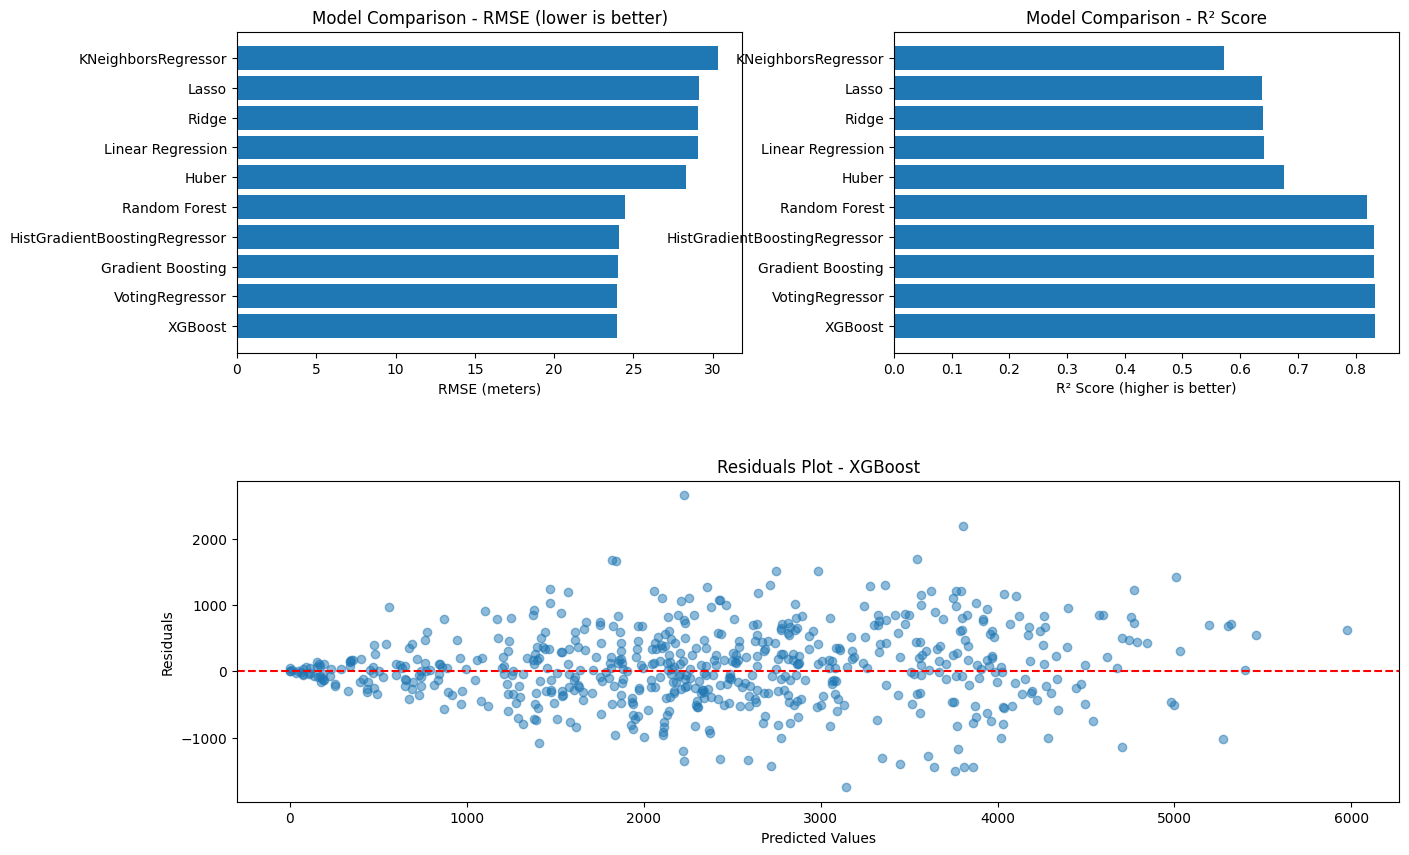


Summary of all models:
                                    RMSE        R²      CV RMSE  CV RMSE Std
XGBoost                        23.947564  0.834064   699.032352    75.151515
VotingRegressor                23.991513  0.832843   693.385186    69.830089
Gradient Boosting              24.002064  0.832548   703.692566    74.135665
HistGradientBoostingRegressor  24.057125  0.831007   693.323963    66.347181
Random Forest                  24.473862  0.818989   717.523717    63.263436
Huber                          28.295873  0.676565  1051.044270   178.997951
Linear Regression              29.047124  0.640824  1060.749858   152.307921
Ridge                          29.058585  0.640257  1059.344065   150.690124
Lasso                          29.109392  0.637734  1056.703837   142.754100
KNeighborsRegressor            30.339997  0.572479  1069.981892   112.327634
Visualizations for the best model:


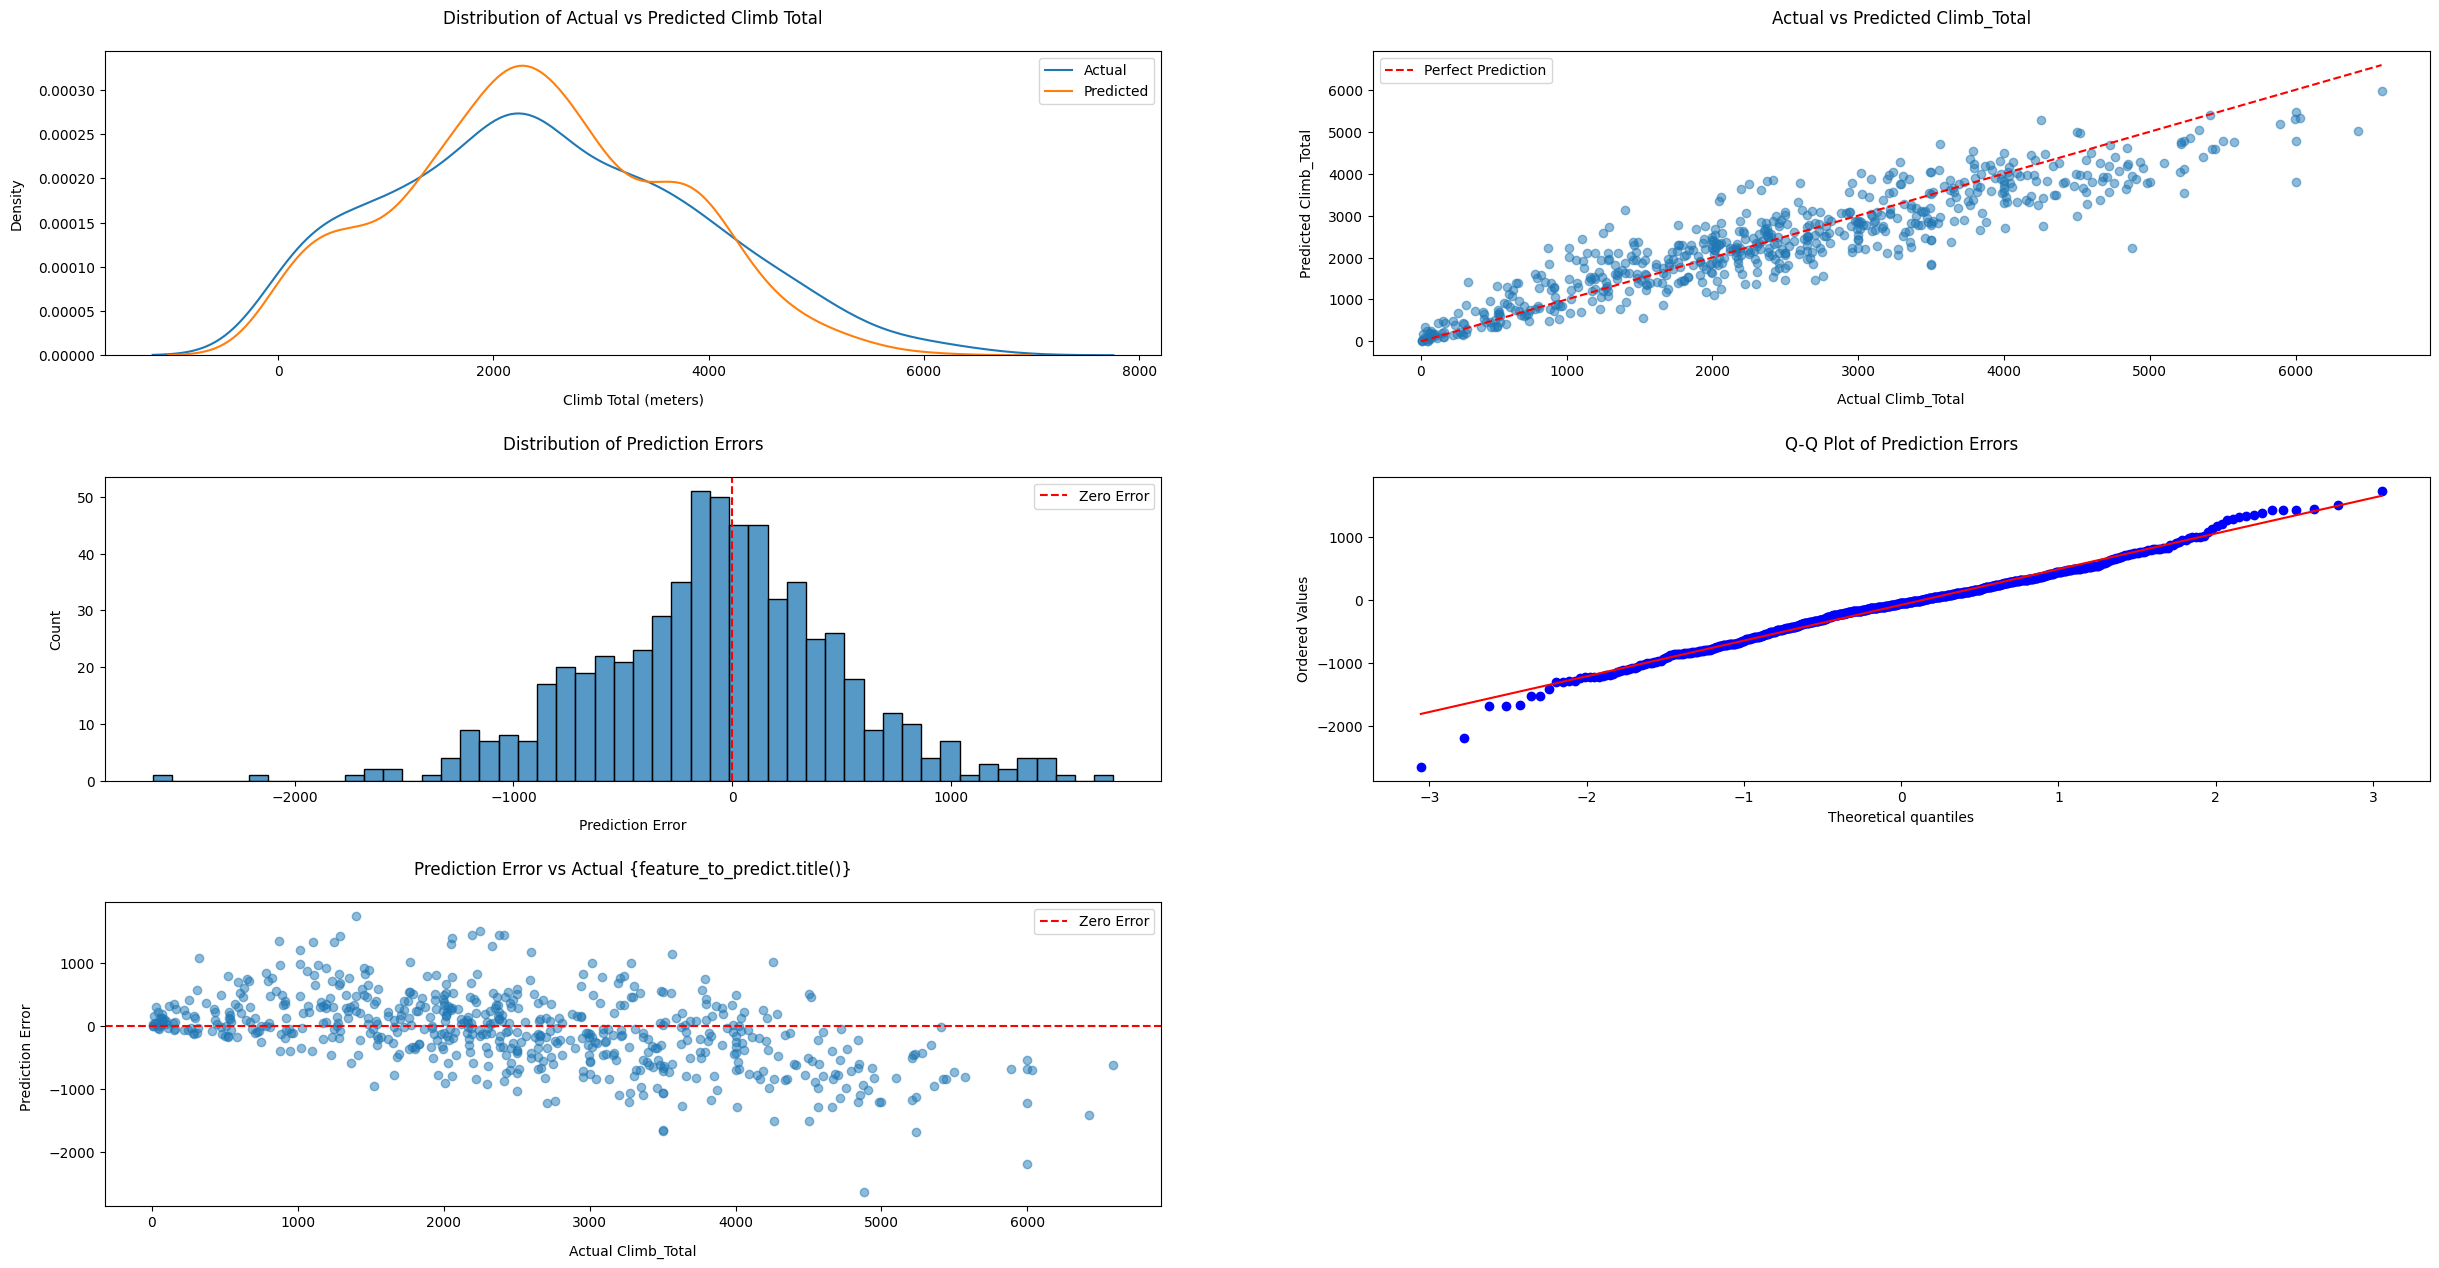

In [9]:
results, summary, climb_total_pred = compare_regressors(GroupedRaces, "climb_total", features=pred_features)

##### Using Segmentation and Density Approach

Now we will execute the above segmentation and density approach code to predict the missing values in the dataset. Since the engineered features don't provide extra information, we don't use them with the density based approach.


/home/lesi-nedo/miniforge3/envs/DM/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=51195) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()



 Feature statistics before imputation:
length: 0 missing (0.00%)
points: 0 missing (0.00%)
startlist_quality: 0 missing (0.00%)
profile: 0 missing (0.00%)
position: 0 missing (0.00%)
cyclist_age: 0 missing (0.00%)


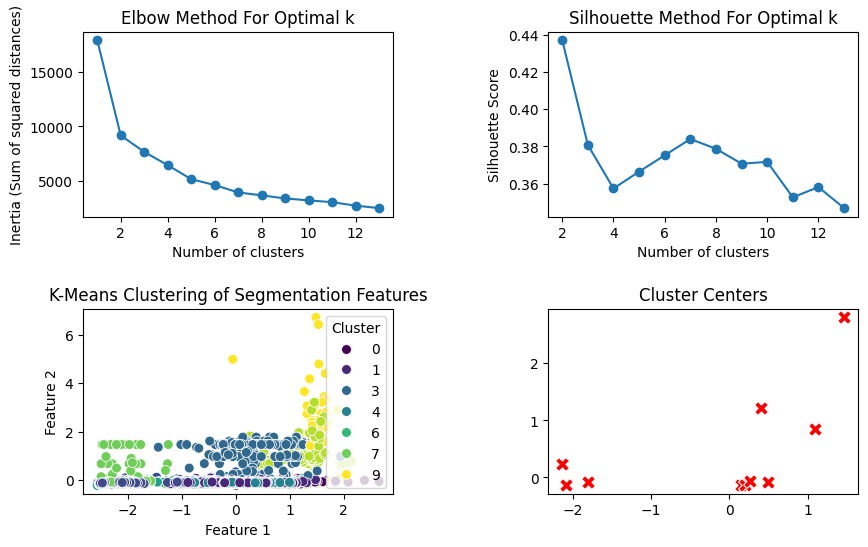

Fitting distributions:   0%|          | 0/33 [00:00<?, ?it/s]

number of segments: 133


Fitting distributions: 100%|██████████| 33/33 [00:01<00:00, 19.37it/s]
/home/lesi-nedo/miniforge3/envs/DM/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


number of chunks: 766


100%|██████████| 3066/3066 [00:00<00:00, 152761.11it/s]



Metrics:
RMSE: 34.39 meters
R²: 0.316
MAE: 892.31 meters
MSE: 1182.77
Length true data: 613
Length predicted data: 613
Mean true data: 2392.424143556281
Mean predicted data: 2370.9510603588906
STD of true data: 1431.4270461451201
STD of predicted data: 1169.8074058929717


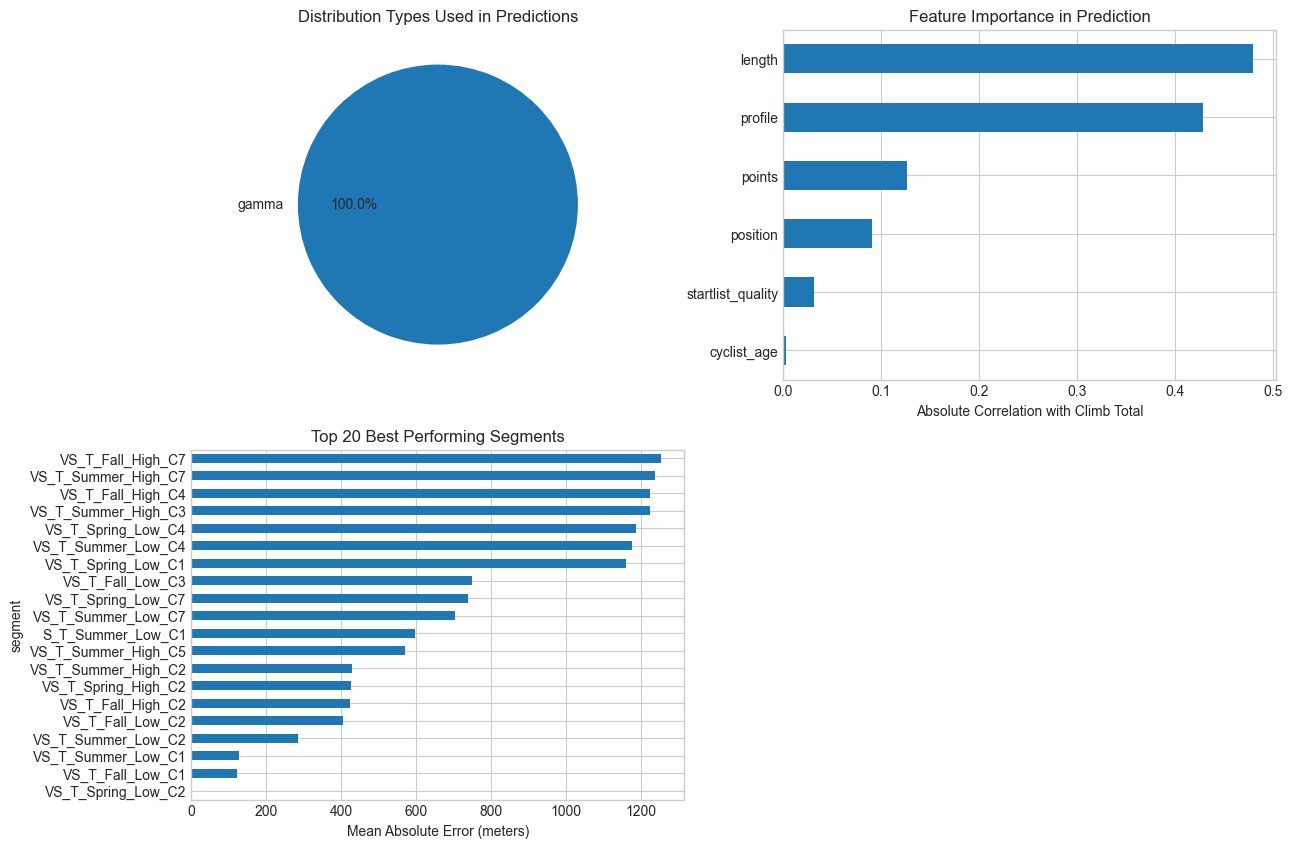

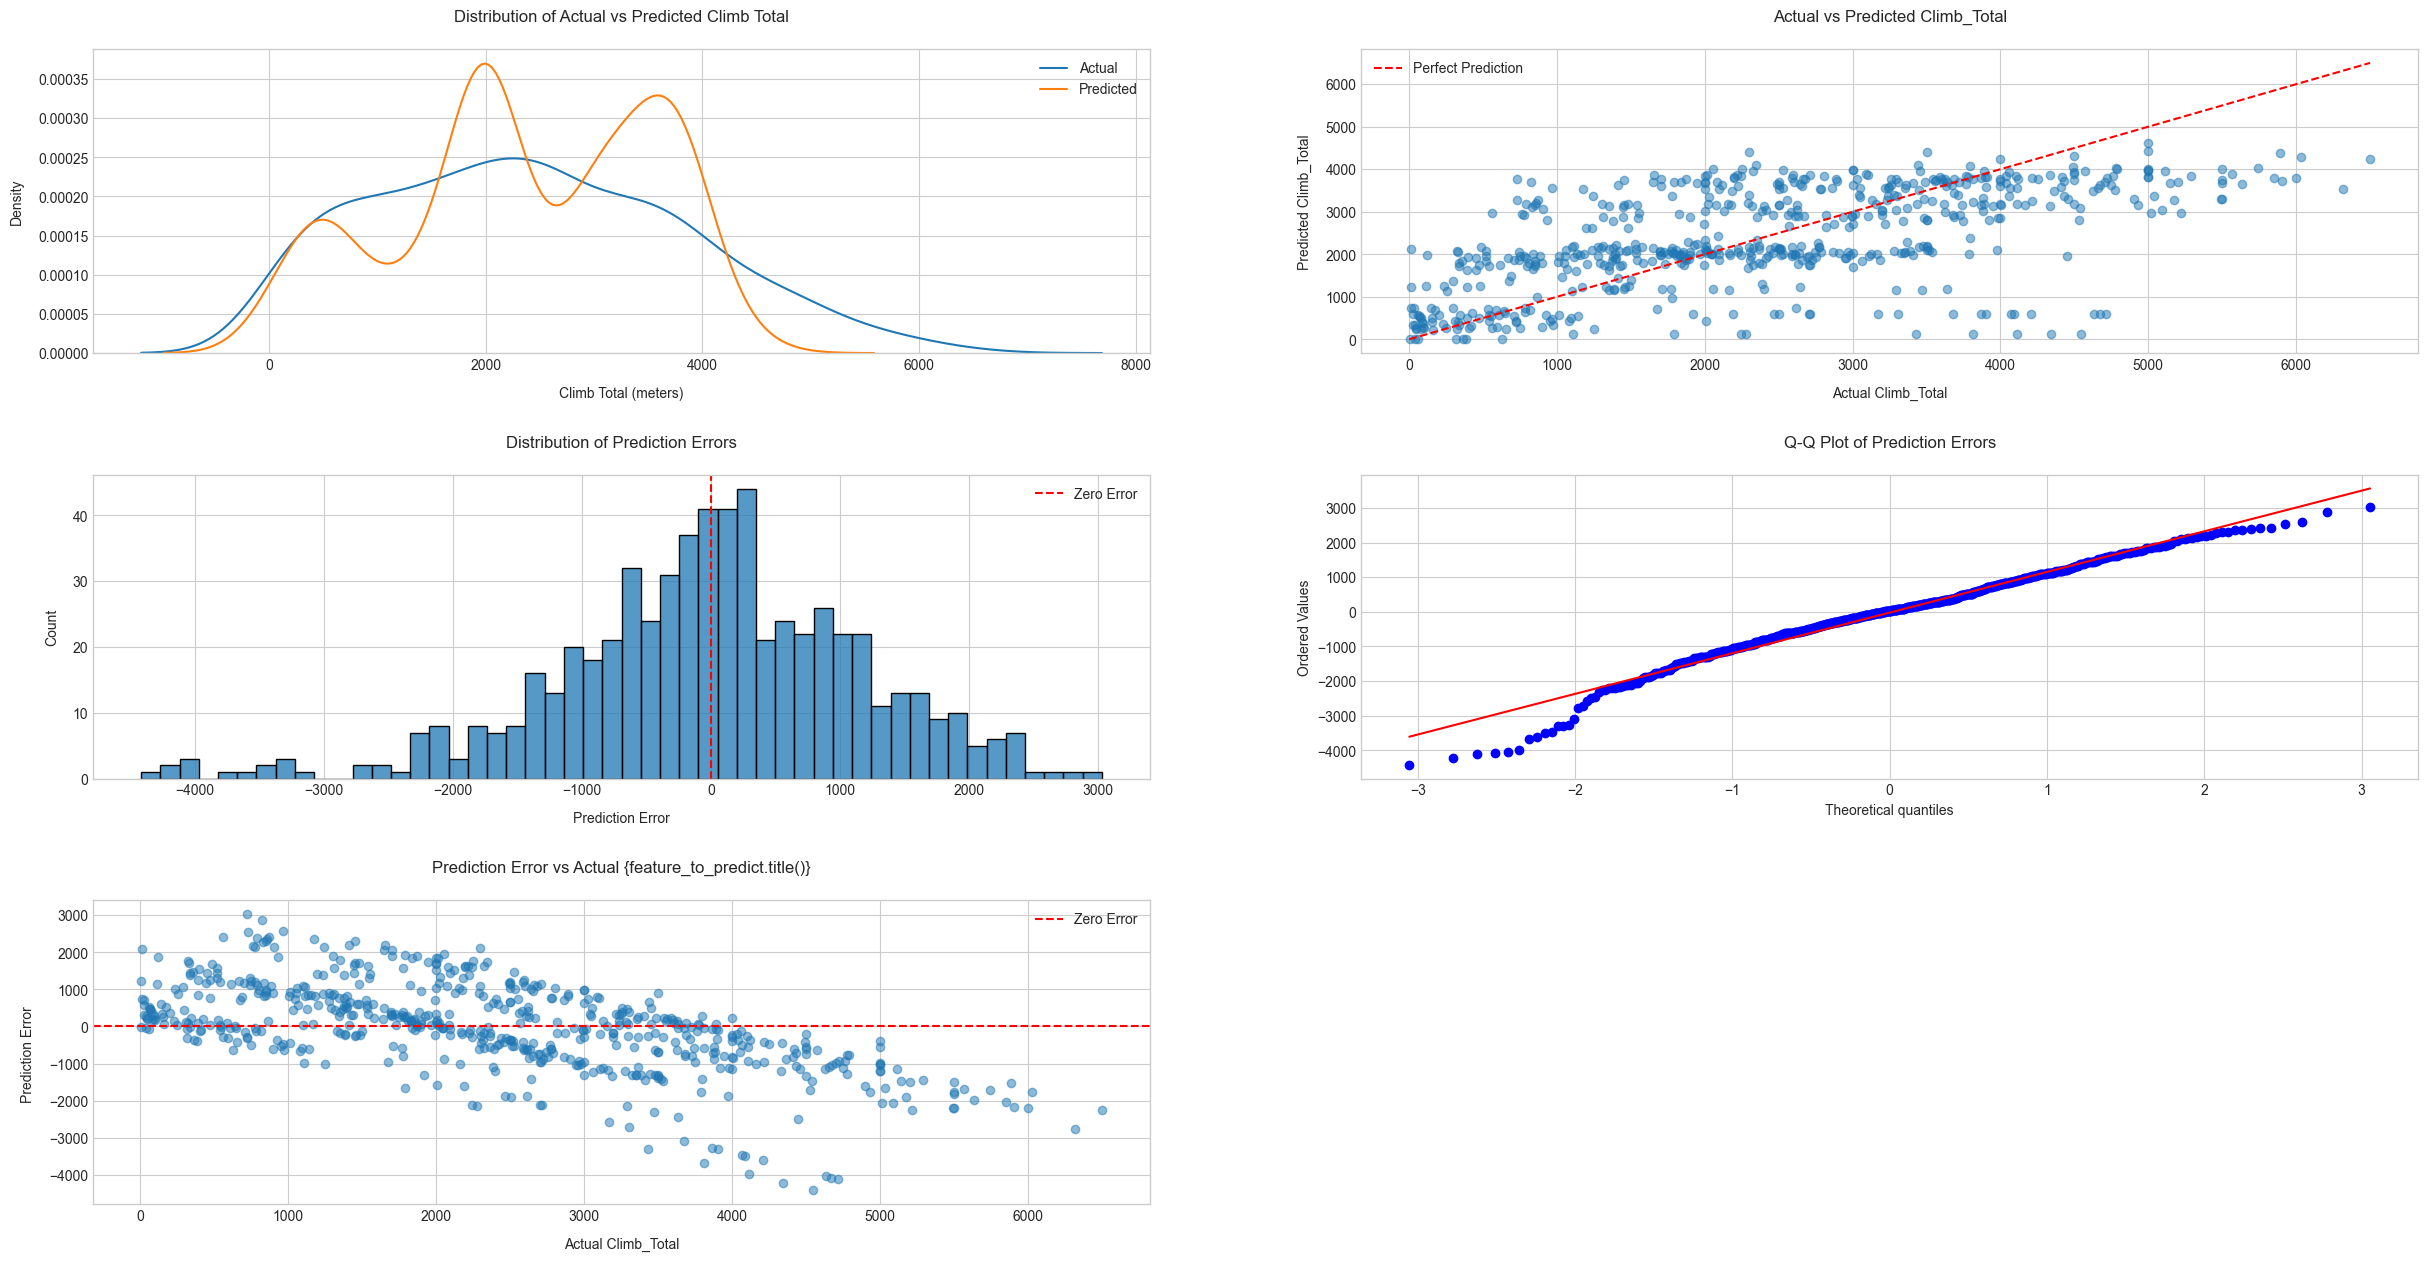

In [10]:
df_test = GroupedRaces[GroupedRaces['climb_total'].notna()].copy()
random_indices = df_test.sample(frac=0.2).index
y_test = df_test.loc[random_indices, 'climb_total']
df_test.loc[random_indices, 'climb_total'] = np.nan


local_normal_features = normal_features.copy()
# del local_normal_features['points']
# del local_normal_features['cyclist_age']
# del local_normal_features['startlist_quality']
# del local_normal_features['position']
# del local_normal_features['profile']
del local_normal_features['is_tarmac']



predictions, stats_races = predict_feature_density(
    df_test, segmentation_features=local_normal_features, n_clusters_final=2, feature_to_predict='climb_total'
)


print_density_info(stats_races, predictions, y_test, 'climb_total')
create_prediction_visualizations(predictions, y_test, stats_races, feature_name="climb_total")


del df_test

##### Using KNNImputer.


INFO:data_pred_code.KNNImputer_based:Starting prediction process...
INFO:data_pred_code.KNNImputer_based:Applying KNN imputation...
INFO:data_pred_code.KNNImputer_based:Calculating validation metrics...
INFO:data_pred_code.KNNImputer_based:y_pred shape: (613,), y_true shape: (613,)
INFO:data_pred_code.KNNImputer_based:Validation metrics: RMSE=28.00, R2=0.69



Metrics:
MSE: 783.75
RMSE: 28.0
MAE: 588.46
R2: 0.69
SAMPLES_USED: 613


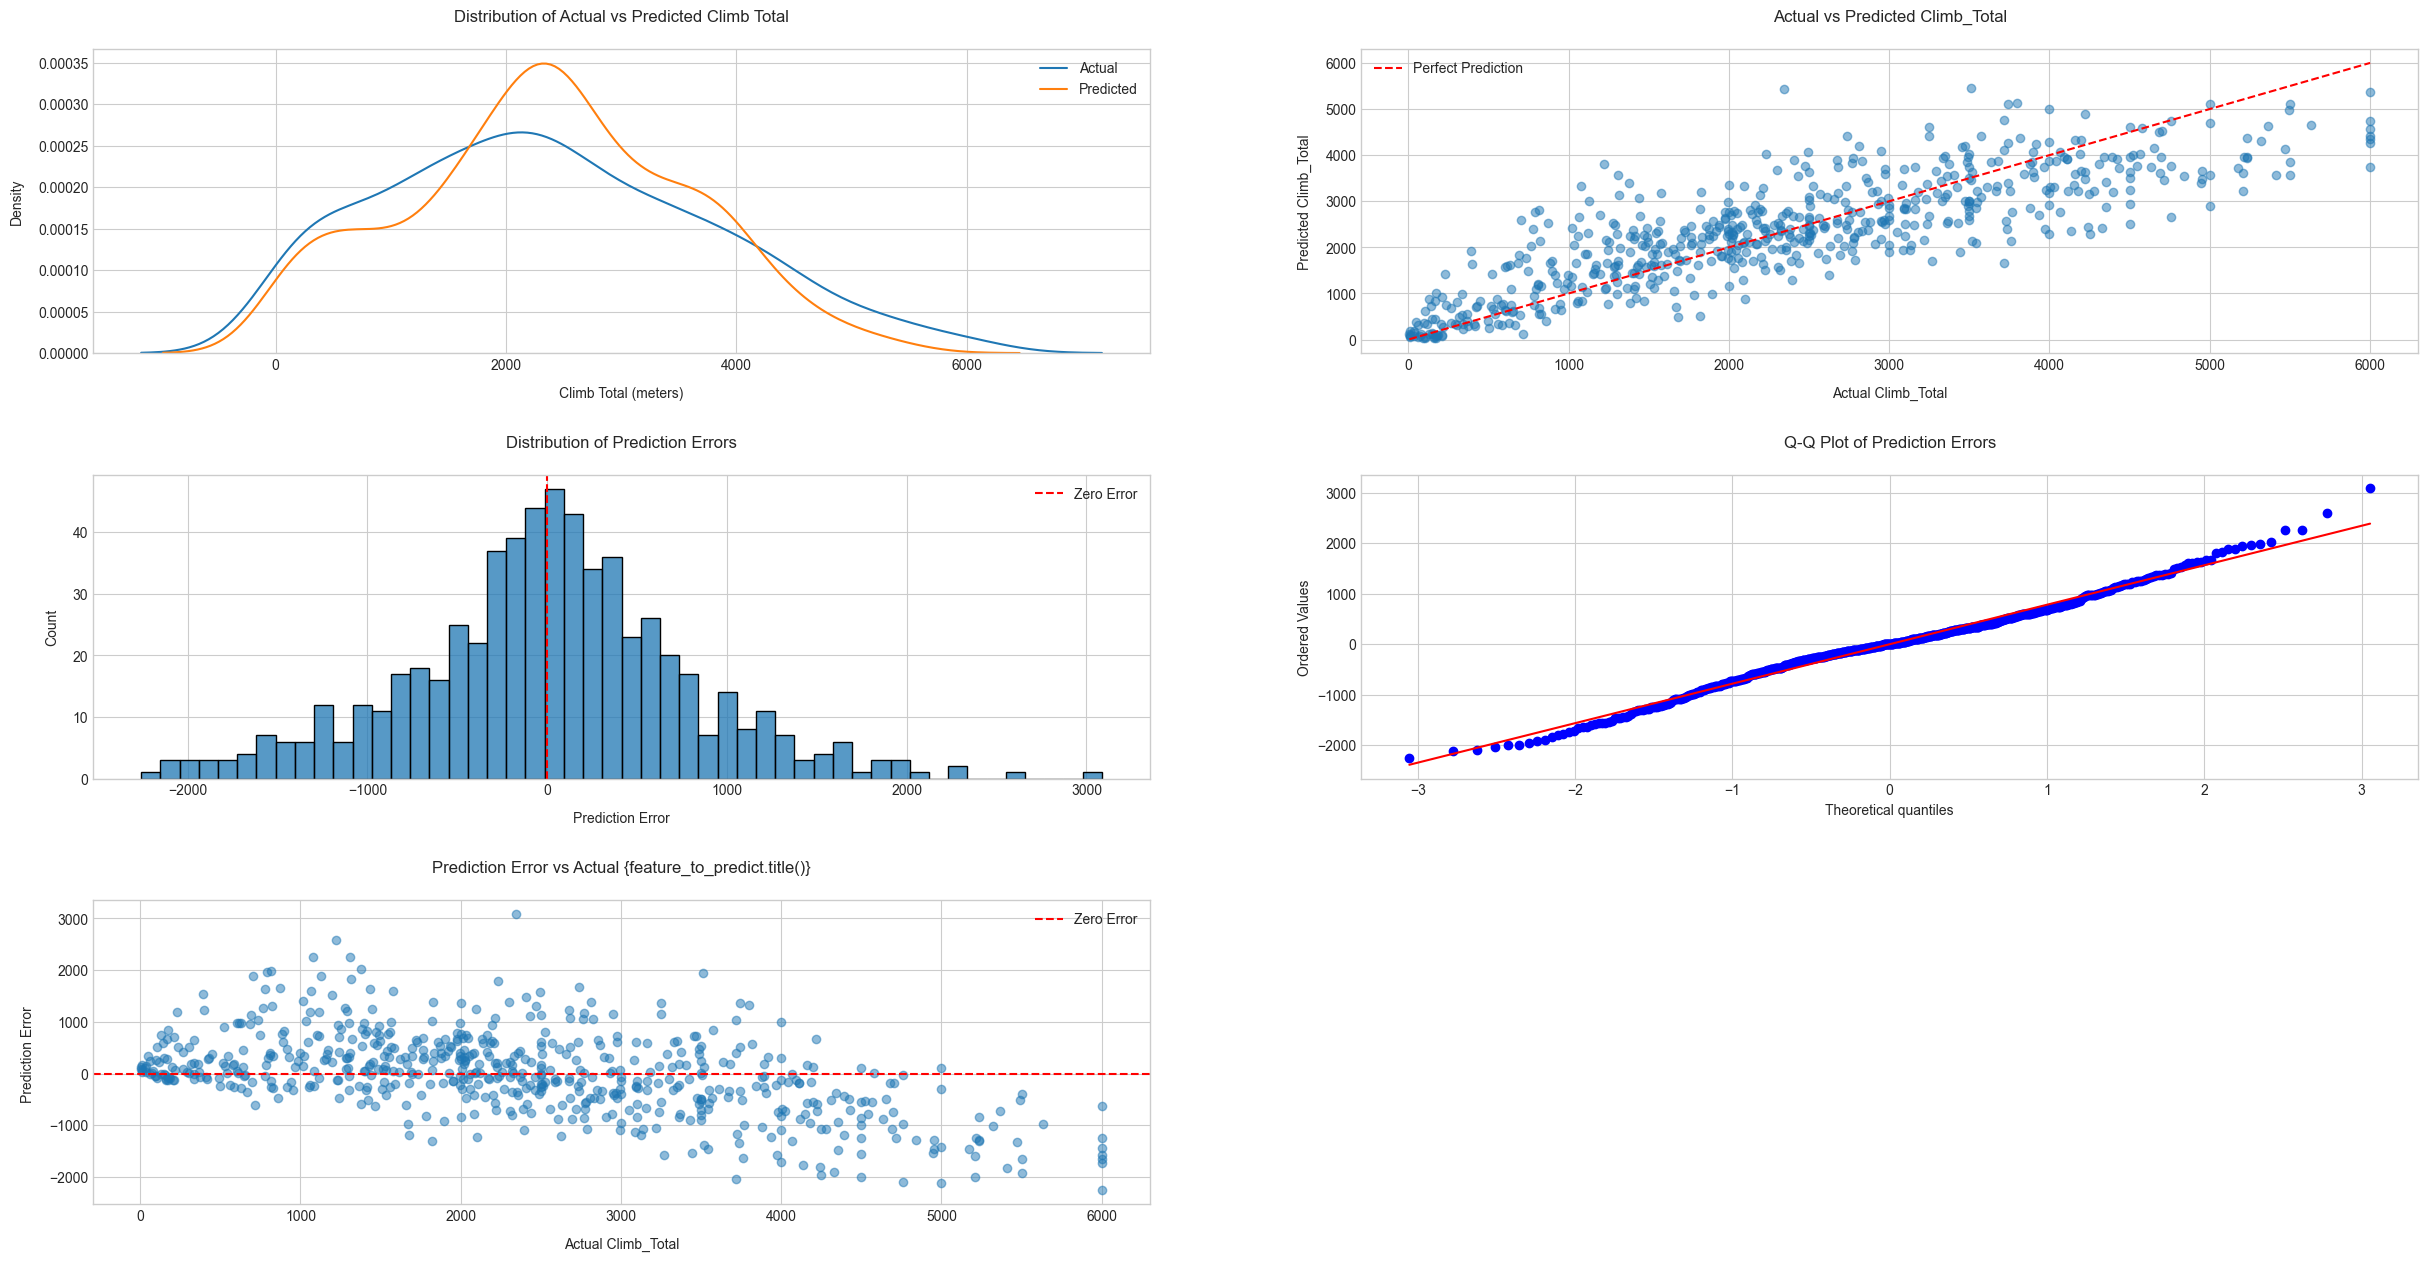

In [12]:

df_test = GroupedRaces[GroupedRaces['climb_total'].notna()].copy()
random_indices = df_test.sample(frac=0.2).index
y_test = df_test.loc[random_indices, 'climb_total']

df_test.loc[random_indices, 'climb_total'] = np.nan
local_pred_features = normal_features.copy()
# del local_pred_features['points']


metrics = predict_feature_knnimp(df_test, n_neighbors=7, feature_to_predict='climb_total', type='numeric', y_true=y_test, features=local_pred_features)

metrics

# print the metrics
print("\nMetrics:")
for key, value in metrics.items():
    print(f"{key.upper()}: {value}")

del df_test

##### Conclusion on  `climb_total` `nan` values prediction 

Based on the comparison between the `RMSE` and `R²` values of the previous approaches, we decide to use the Voting Regressor to fill the missing values in `climb_total`.

In [37]:
climb_total_pred_v1 = climb_total_pred.apply(lambda x: round(x, 0))

temp_obj = DatasetRace.loc[DatasetRace['climb_total'].isna(), '_url'].map(climb_total_pred_v1)

# Update the 'climb_total' column in races_v1 only for NaN entries
DatasetRace.loc[temp_obj.index, 'climb_total'] = temp_obj
print(f"Number of missing values in climb_total: {DatasetRace['climb_total'].isna().sum()}")

Number of missing values in climb_total: 0


#### Predicting `profile` `nan` values

Since the best approach for predicting the `profile` NaN values was the regressors comparing approach, we will only show the results of running the `compare_regressor` algorithm and skip the other two. For more in depth analysis, refer to the file [OleksiyDataTrans.ipynb](extra_notebooks/OleksiyDataTrans.ipynb).


##### Dataset preparation

In [38]:
DatasetRace_profile = DatasetRace_temp.drop(columns=['profile']).copy()

# Update the 'climb_total' column with true values and predicted values for NaN entries
DatasetRace_profile['climb_total'] = DatasetRace['climb_total']

# Updating the profile column with the original  values
DatasetRace_profile['profile'] = DatasetRace['profile']
print(f"Number of missing values in profile column: {DatasetRace['profile'].isna().sum()}")

# scaling the 'climb_total' column
preprocess_helper_scaler(DatasetRace_profile, {'climb_total': {'type': 'numeric'}})

DatasetRace_profile.sample(frac=0.3).head(10)

del DatasetRace_temp
del GroupedRaces

Number of missing values in profile column: 147629


In [39]:
normal_features_prof = normal_features.copy()
del normal_features_prof['profile']
normal_features_prof['climb_total'] = {'type': 'numeric', 'agg': 'first'}
FEATURES_PROF = {**normal_features_prof, **engineered_features}

pred_features_prof = {name: {'type': props['type']} for name, props in FEATURES_PROF.items()}

agg_dict_prof = {name: props['agg'] for name, props in FEATURES_PROF.items()}
agg_dict_prof['date'] = 'first'
agg_dict_prof['profile'] = 'first'

DatasetRace_profile_grouped = DatasetRace_profile.groupby(["_url"]).agg(agg_dict_prof)

DatasetRace_profile_grouped.sample(frac=0.4).head(5)

length    points  startlist_quality  \
_url                                                                     
tour-de-suisse/1982/stage-9      0.498946  1.160688          -1.165686   
tour-de-suisse/2006/stage-3      0.351786 -0.179718          -0.338065   
giro-d-italia/2008/stage-19      0.948171 -0.109745          -0.112111   
volta-a-catalunya/1984/stage-4b -1.158539  0.667796          -2.053736   
vuelta-a-espana/2022/stage-14   -0.100537 -0.109745          -0.348574   

                                 is_tarmac  position  cyclist_age  \
_url                                                                
tour-de-suisse/1982/stage-9            1.0 -1.483586    -1.031866   
tour-de-suisse/2006/stage-3            1.0  0.157585    -0.124164   
giro-d-italia/2008/stage-19            1.0 -0.066543    -0.124164   
volta-a-catalunya/1984/stage-4b        1.0 -1.442213    -0.124164   
vuelta-a-espana/2022/stage-14          1.0 -0.066543    -0.124164   

                                 climb_total  points_per_km  season_score  \
_url                                                                        
tour-de-suisse/1982/stage-9         0.780284       0.201939     -0.117337   
tour-de-suisse/2006/stage-3         0.202000      -0.090531      0.201418   
giro-d-italia/2008/stage-19         0.887747      -0.079326      0.474652   
volta-a-catalunya/1984/stage-4b    -0.135076       0.323776     -1.652250   
vuelta-a-espana/2022/stage-14       0.757864      -0.069221     -1.580779   

                                 season  team_presents  adjusted_delta  \
_url                                                                     
tour-de-suisse/1982/stage-9           2      -0.850476       -0.326695   
tour-de-suisse/2006/stage-3           2       2.412070       -0.145036   
giro-d-italia/2008/stage-19           1       5.997480       13.585004   
volta-a-catalunya/1984/stage-4b       0       3.835971       -0.322617   
vuelta-a-espana/2022/stage-14         0      69.038651        0.254770   

                                 startlist_score_per_km                date  \
_url                                                                          
tour-de-suisse/1982/stage-9                   -0.310395 1982-06-25 05:09:43   
tour-de-suisse/2006/stage-3                   -0.265679 2006-06-12 04:36:52   
giro-d-italia/2008/stage-19                   -0.277640 2008-05-30 06:37:32   
volta-a-catalunya/1984/stage-4b               -0.306337 1984-09-09 02:25:28   
vuelta-a-espana/2022/stage-14                 -0.243430 2022-09-03 04:09:27   

                                 profile  
_url                                      
tour-de-suisse/1982/stage-9          NaN  
tour-de-suisse/2006/stage-3          NaN  
giro-d-italia/2008/stage-19          5.0  
volta-a-catalunya/1984/stage-4b      NaN  
vuelta-a-espana/2022/stage-14        5.0

##### Using `comapare_regressors` (only) 


Training Random Forest...

Training Gradient Boosting...

Training XGBoost...

Training Huber...

Training Linear Regression...

Training Ridge...

Training Lasso...

Training KNeighborsRegressor...

Training HistGradientBoostingRegressor...

Training VotingRegressor...


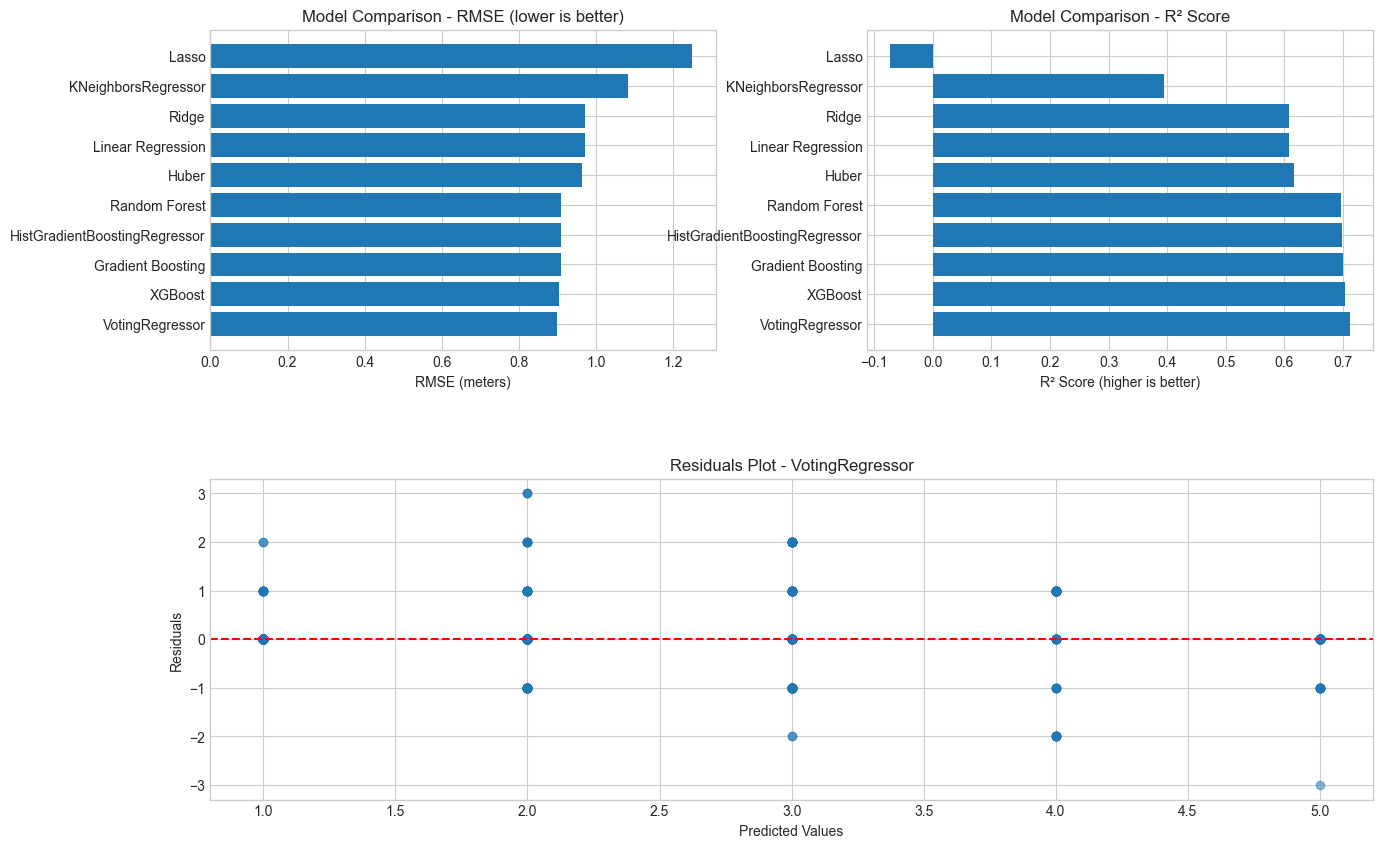


Summary of all models:
                                   RMSE        R²   CV RMSE  CV RMSE Std
VotingRegressor                0.898051  0.712028  0.848060     0.034656
XGBoost                        0.903995  0.704328  0.851207     0.033333
Gradient Boosting              0.907505  0.699708  0.853471     0.035207
HistGradientBoostingRegressor  0.908087  0.698938  0.871456     0.035779
Random Forest                  0.909823  0.696628  0.859723     0.047131
Huber                          0.964211  0.617321  0.971695     0.128414
Linear Regression              0.970455  0.607311  0.983868     0.116893
Ridge                          0.970455  0.607311  0.976747     0.115354
KNeighborsRegressor            1.081281  0.394797  1.209173     0.088851
Lasso                          1.247587 -0.072580  1.479354     0.133662
Visualizations for the best model:


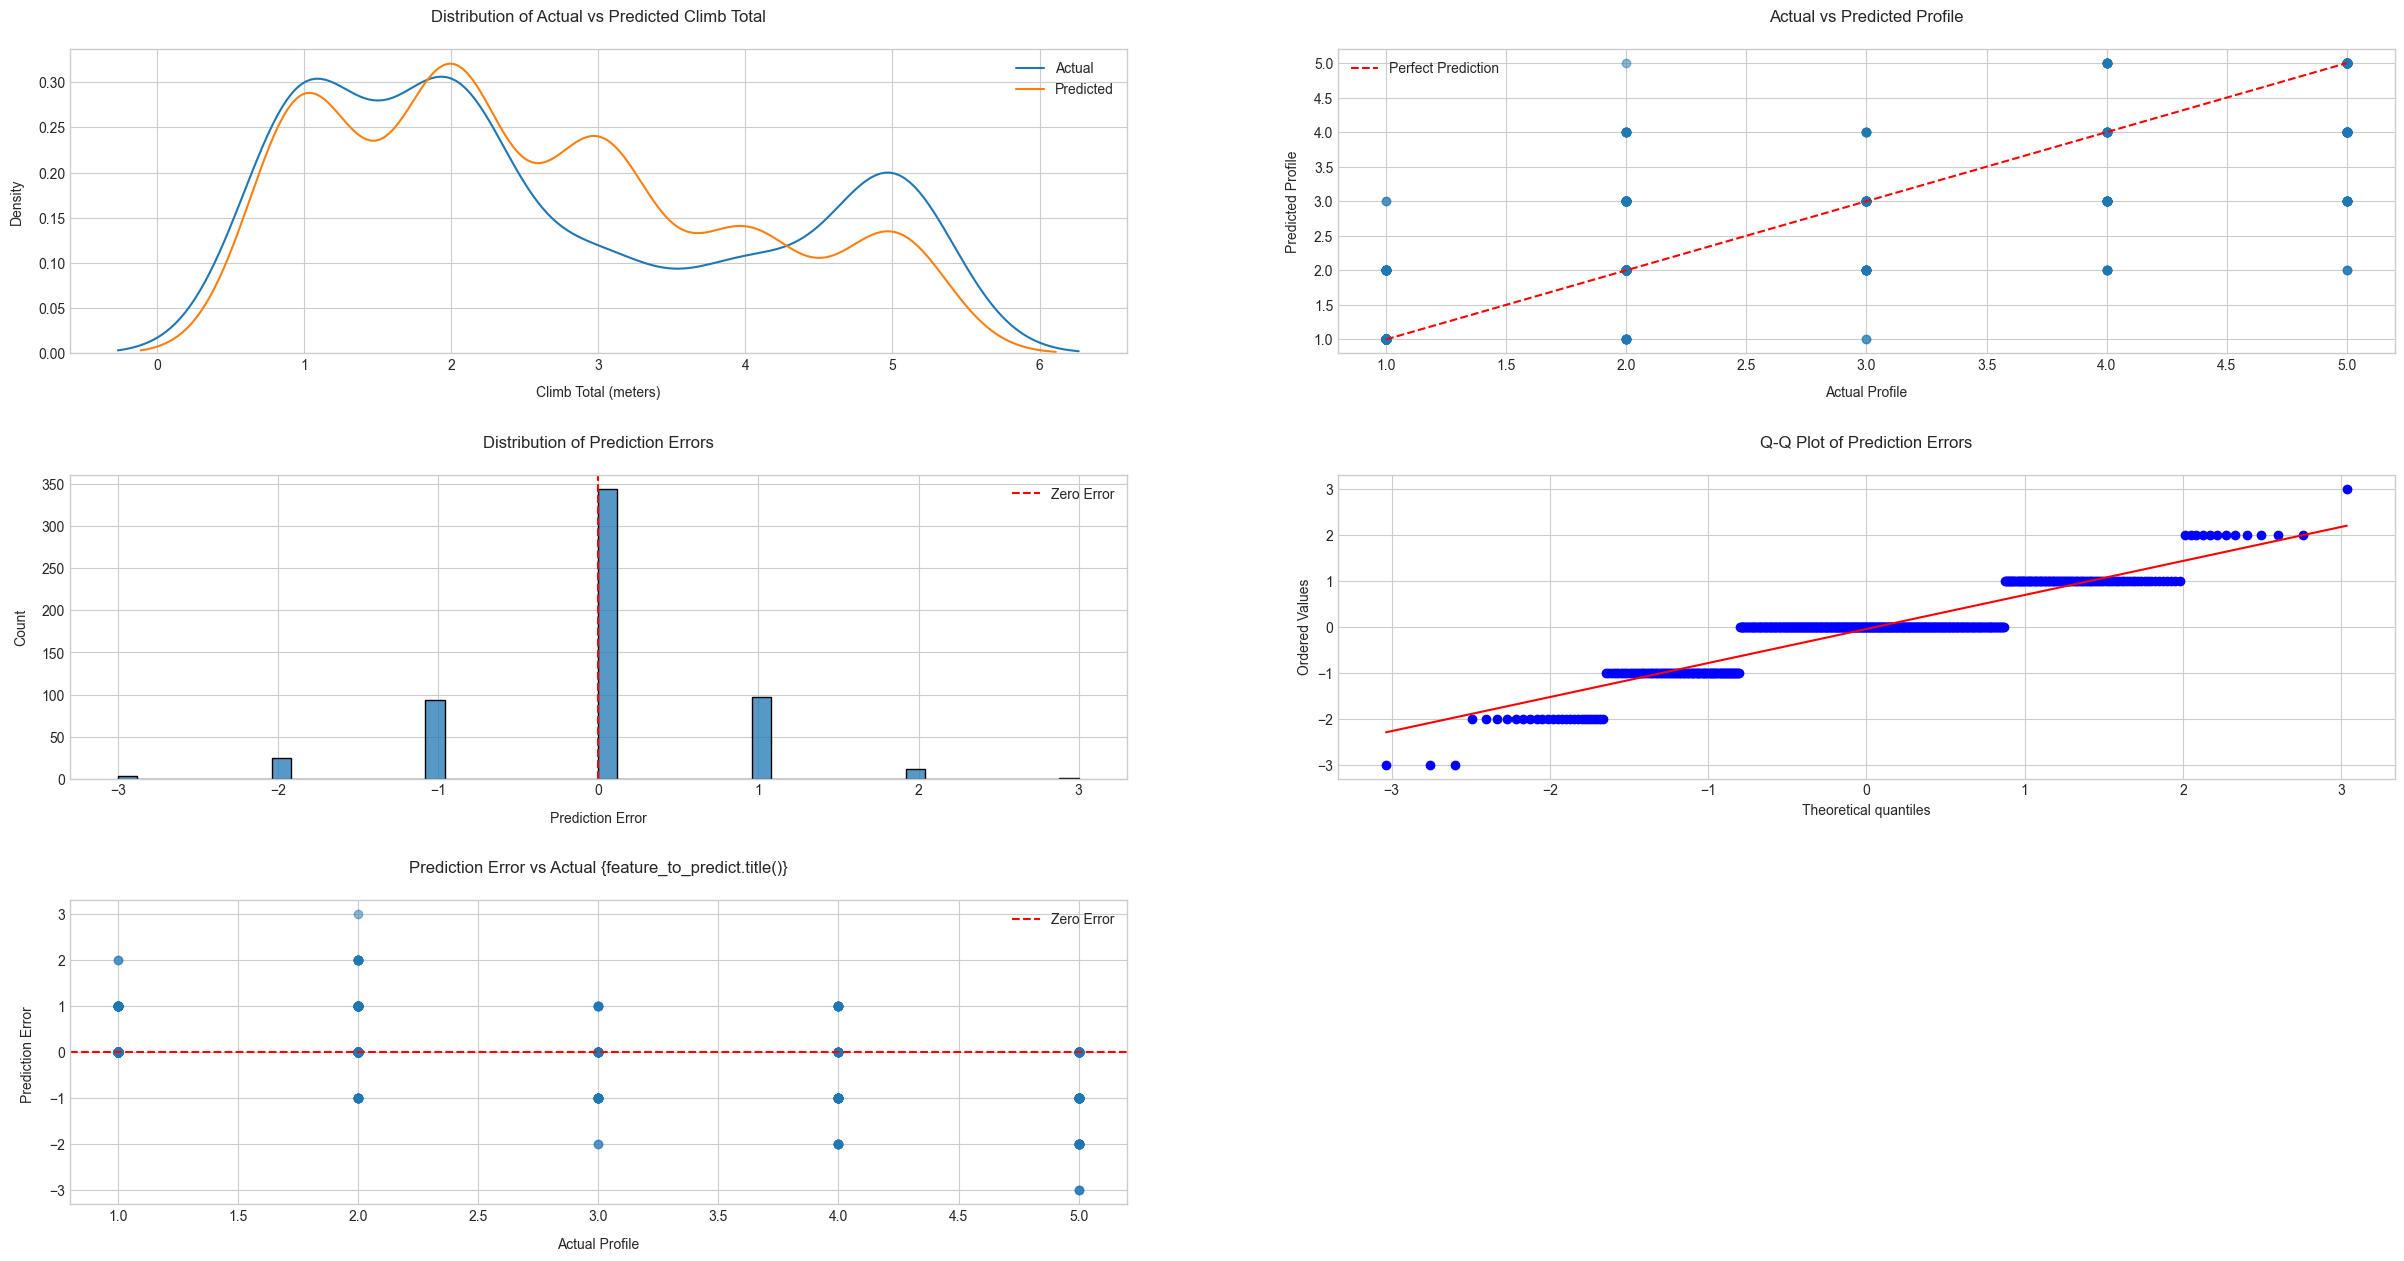

In [40]:
results_profile, summary_prof, profile_pred =  compare_regressors(DatasetRace_profile_grouped, "profile", features=pred_features_prof)

##### Conclusion on  `profile` `nan` values prediction 

In [41]:
profile_pred_v1 = profile_pred.apply(lambda x: round(x, 0))

temp_obj_profile = DatasetRace.loc[DatasetRace['profile'].isna(), '_url'].map(profile_pred_v1)

# Update the 'profile' column
DatasetRace.loc[temp_obj_profile.index, 'profile'] = temp_obj_profile

DatasetRace['profile'].isna().sum()

np.int64(0)

#### Predicting `uci_points` `nan` values

Now we will proceed to predict the `uci_points`. Since the best approach to predict the `nan` values was the regressors comparing one, we are showing only its results.

Warning: might take some minutes to run.

#### Executing on `uci_points`

In [42]:
DatasetRace_uci_points = DatasetRace_profile.copy()

DatasetRace_uci_points['uci_points'] = DatasetRace['uci_points']

noraml_features_uci_points = normal_features_prof.copy()

FEATURES_UCI_POINTS = {**noraml_features_uci_points, **engineered_features}

pred_features_uci_points = {name: {'type': props['type']} for name, props in FEATURES_UCI_POINTS.items()}

agg_dict_uci_points = {name: props['agg'] for name, props in FEATURES_UCI_POINTS.items()}
agg_dict_uci_points['date'] = 'first'
agg_dict_uci_points['uci_points'] = 'mean'

DatasetRace_uci_points_groupd = DatasetRace_uci_points.groupby(["_url", "cyclist"]).agg(agg_dict_uci_points)


DatasetRace_uci_points_groupd.sample(frac=0.4).head(5)

# del DatasetRace_points
# del DatasetRace_points_groupd

length    points  \
_url                                cyclist                                
tour-de-france/2002/prologue        nico-mattan      -2.475233 -0.235111   
tour-de-france/1995/prologue        eros-poli        -2.470585 -0.235111   
e3-harelbeke/2004/result            hans-de-clercq    0.436984 -0.235111   
itzulia-basque-country/2021/stage-5 emanuel-buchmann -0.102086 -0.235111   
milano-sanremo/1999/result          vladislav-bobrik  1.970545  0.092029   

                                                      startlist_quality  \
_url                                cyclist                               
tour-de-france/2002/prologue        nico-mattan                1.020285   
tour-de-france/1995/prologue        eros-poli                  2.023939   
e3-harelbeke/2004/result            hans-de-clercq            -1.412658   
itzulia-basque-country/2021/stage-5 emanuel-buchmann          -0.432650   
milano-sanremo/1999/result          vladislav-bobrik           1.272512   

                                                      is_tarmac  position  \
_url                                cyclist                                 
tour-de-france/2002/prologue        nico-mattan             1.0  0.885048   
tour-de-france/1995/prologue        eros-poli               1.0  1.753893   
e3-harelbeke/2004/result            hans-de-clercq          0.0 -0.604399   
itzulia-basque-country/2021/stage-5 emanuel-buchmann        1.0 -0.707833   
milano-sanremo/1999/result          vladislav-bobrik        0.0  0.181698   

                                                      cyclist_age  \
_url                                cyclist                         
tour-de-france/2002/prologue        nico-mattan          0.653867   
tour-de-france/1995/prologue        eros-poli            0.913211   
e3-harelbeke/2004/result            hans-de-clercq       1.691242   
itzulia-basque-country/2021/stage-5 emanuel-buchmann     0.135180   
milano-sanremo/1999/result          vladislav-bobrik    -0.124164   

                                                      climb_total  \
_url                                cyclist                         
tour-de-france/2002/prologue        nico-mattan         -1.642637   
tour-de-france/1995/prologue        eros-poli           -1.586200   
e3-harelbeke/2004/result            hans-de-clercq      -0.047714   
itzulia-basque-country/2021/stage-5 emanuel-buchmann    -0.056992   
milano-sanremo/1999/result          vladislav-bobrik     0.114638   

                                                      points_per_km  \
_url                                cyclist                           
tour-de-france/2002/prologue        nico-mattan           -0.103250   
tour-de-france/1995/prologue        eros-poli             -0.103250   
e3-harelbeke/2004/result            hans-de-clercq        -0.103250   
itzulia-basque-country/2021/stage-5 emanuel-buchmann      -0.103250   
milano-sanremo/1999/result          vladislav-bobrik      -0.054834   

                                                      season_score  season  \
_url                                cyclist                                  
tour-de-france/2002/prologue        nico-mattan          -0.394072       2   
tour-de-france/1995/prologue        eros-poli            -0.268190       2   
e3-harelbeke/2004/result            hans-de-clercq        1.179152       1   
itzulia-basque-country/2021/stage-5 emanuel-buchmann      1.170060       1   
milano-sanremo/1999/result          vladislav-bobrik      1.150641       1   

                                                      team_presents  \
_url                                cyclist                           
tour-de-france/2002/prologue        nico-mattan            0.608744   
tour-de-france/1995/prologue        eros-poli             -1.642726   
e3-harelbeke/2004/result            hans-de-clercq        -1.642726   
itzulia-basque-country/2021/stage-5 emanuel-buchmann       0.608744   
milano-sanremo/199

#### Executing the `compare_regressors` algorithm (will slightly long)


Training Random Forest...

Training Gradient Boosting...

Training XGBoost...

Training Huber...

Training Linear Regression...

Training Ridge...

Training Lasso...

Training KNeighborsRegressor...

Training HistGradientBoostingRegressor...

Training VotingRegressor...


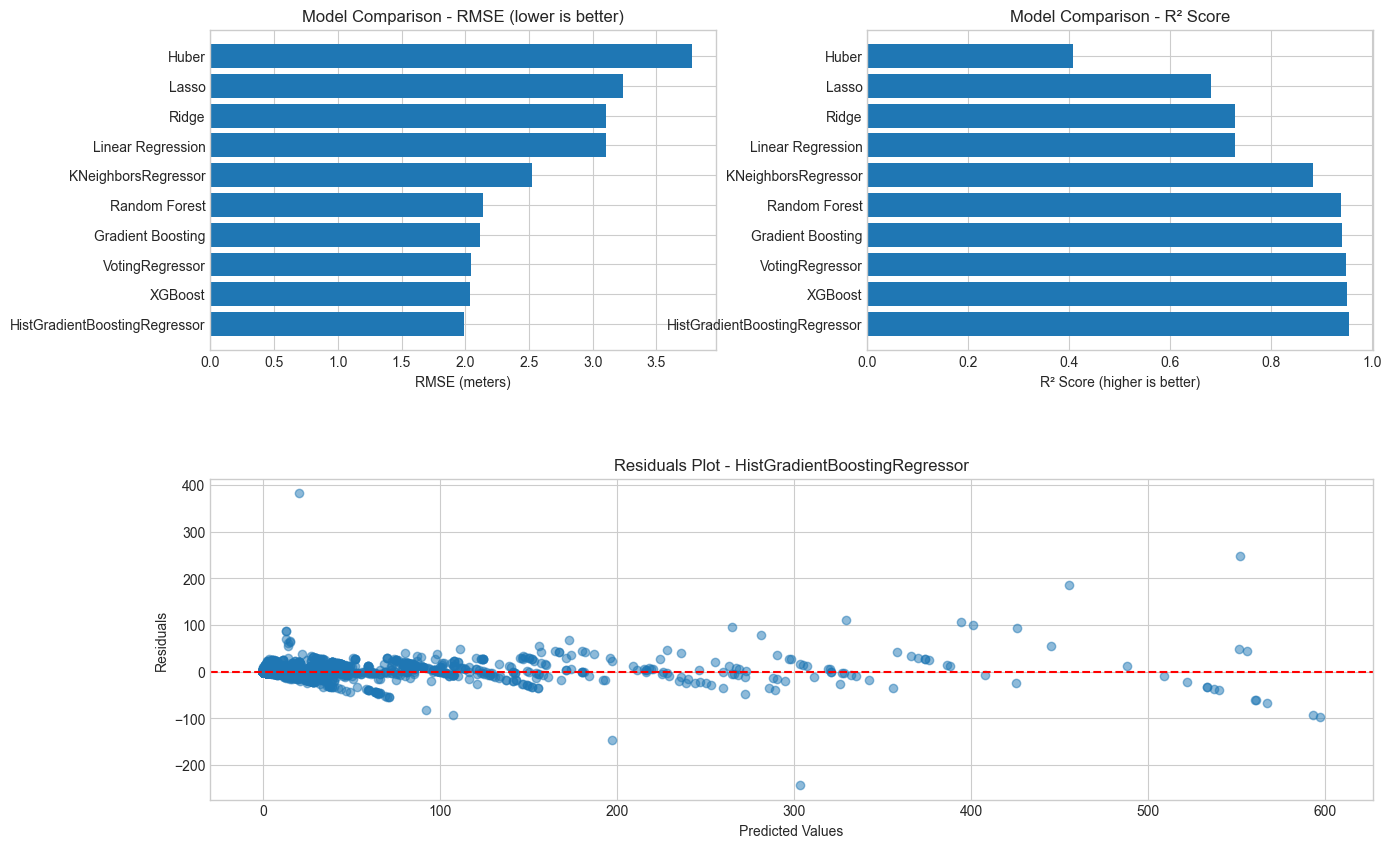


Summary of all models:
                                   RMSE        R²    CV RMSE  CV RMSE Std
HistGradientBoostingRegressor  1.994211  0.954033   7.069115     1.310290
XGBoost                        2.040934  0.949571   7.081499     1.529958
VotingRegressor                2.047230  0.948946   6.753939     1.473777
Gradient Boosting              2.118026  0.941509   6.921747     1.897113
Random Forest                  2.140499  0.938987   6.795415     1.246148
KNeighborsRegressor            2.520594  0.882679   8.497064     1.311848
Linear Regression              3.106617  0.729284   9.920103     2.820717
Ridge                          3.106651  0.729272   9.920046     2.820806
Lasso                          3.239209  0.680023  10.418380     4.331693
Huber                          3.777527  0.408175  13.391815     6.883071
Visualizations for the best model:


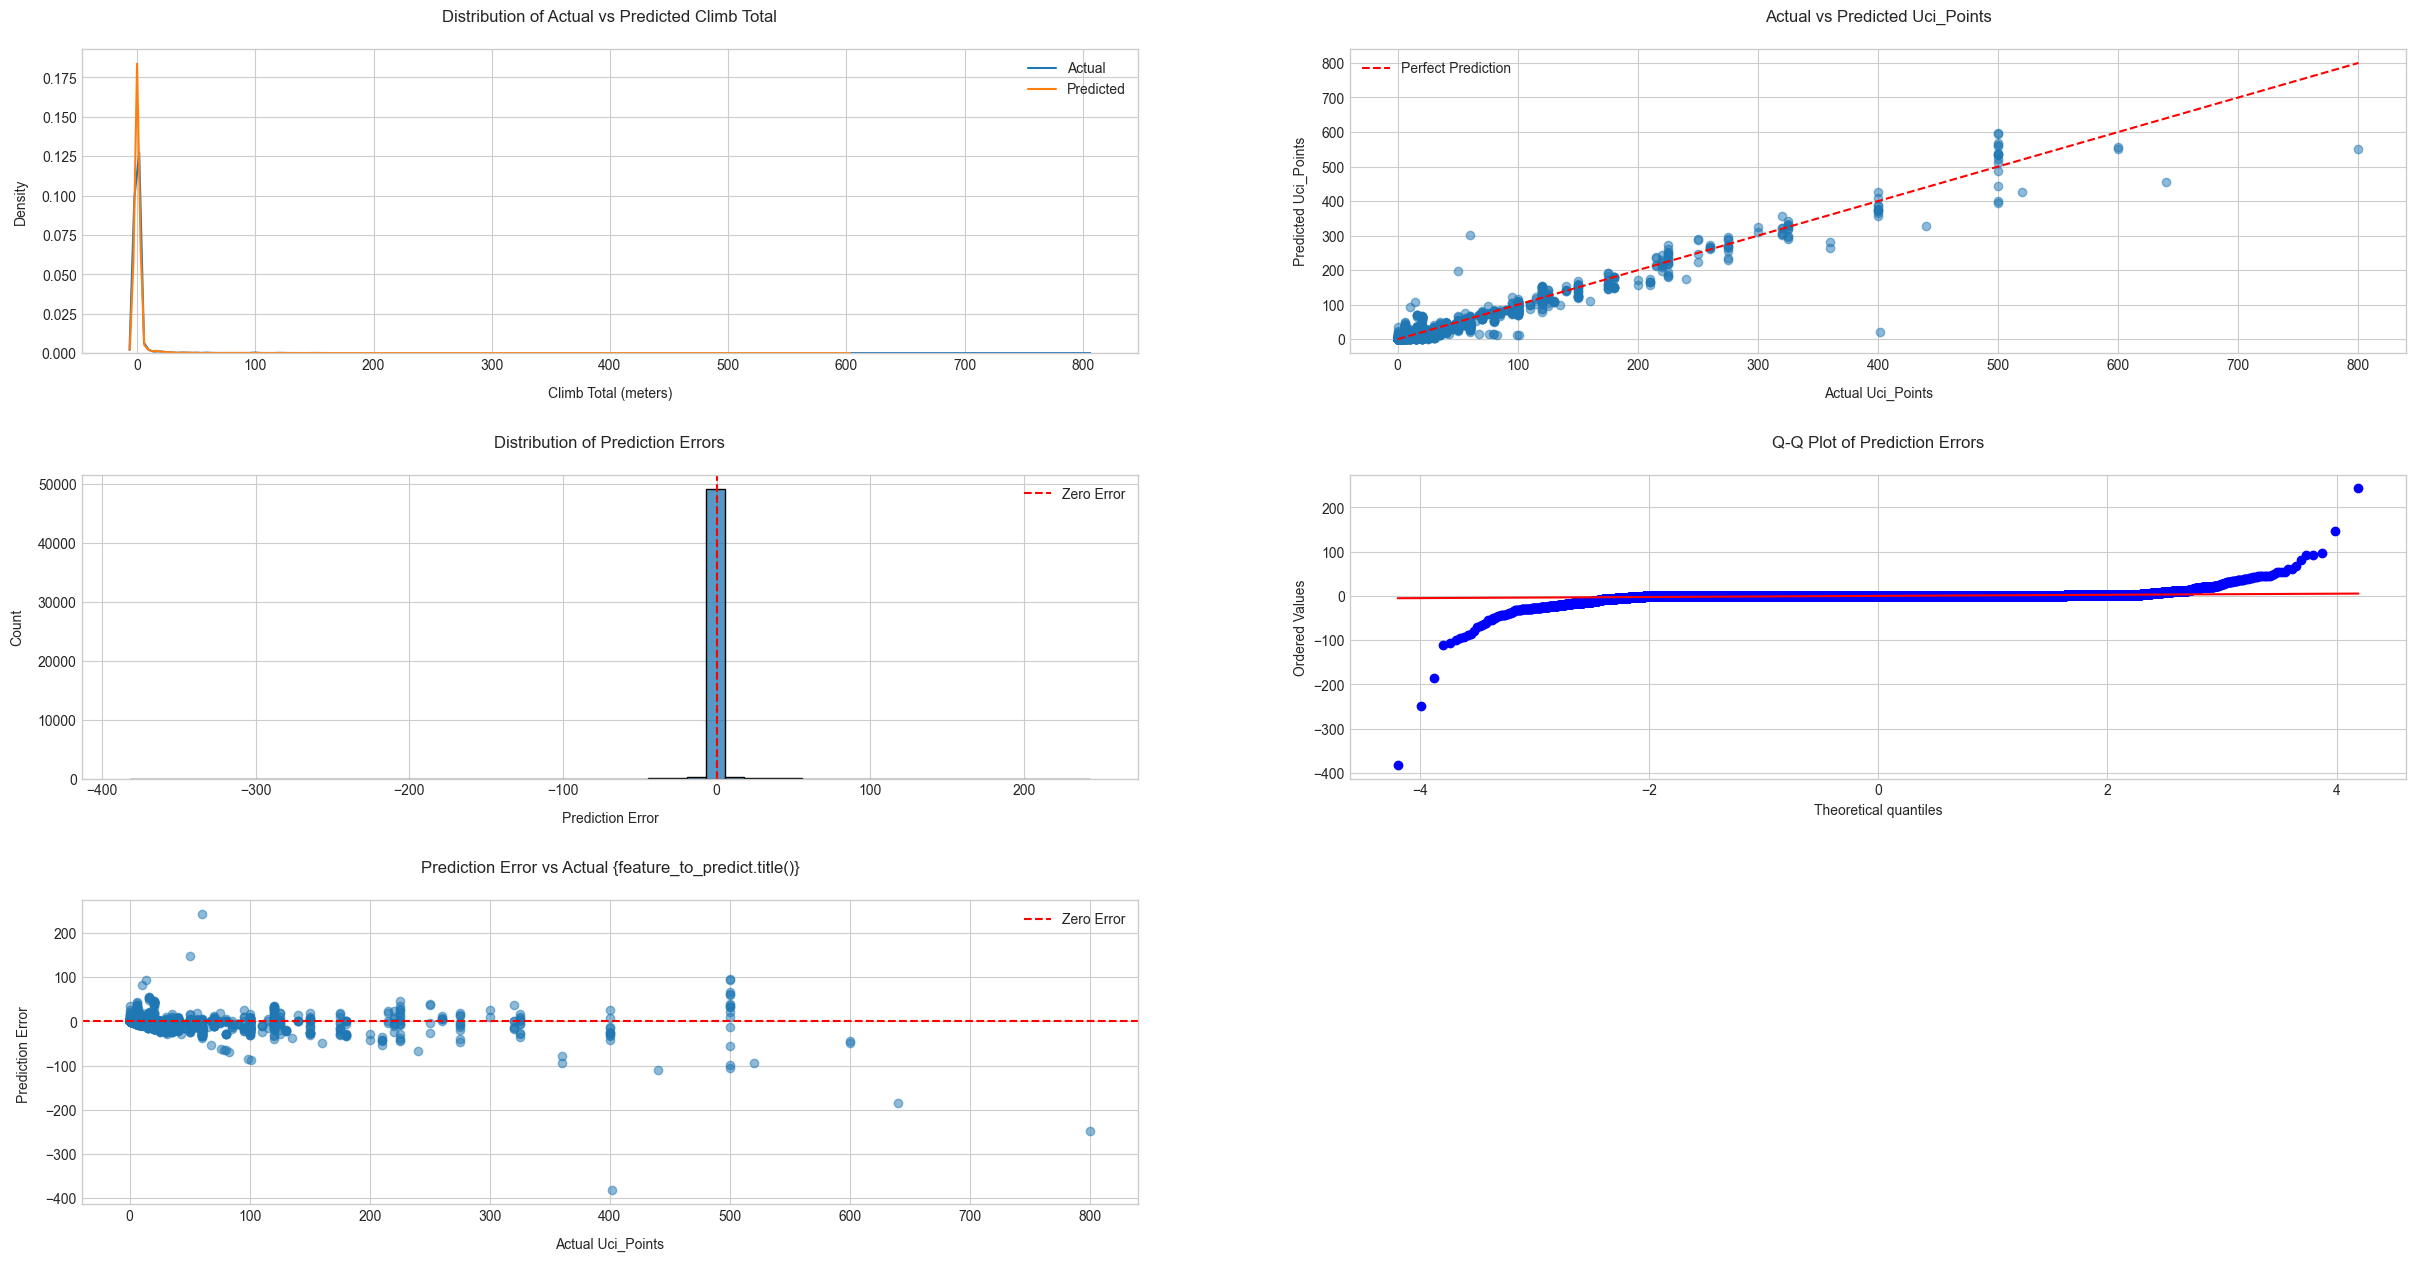

In [43]:
results_uci_points, summary_uci_points, uci_points_pred =  compare_regressors(DatasetRace_uci_points_groupd, "uci_points", features=pred_features_uci_points)

#### `uci_points` predictions substitution

In [44]:

uci_points_pred_v1 = uci_points_pred.apply(lambda x: round(x, 0))

temp_obj_uci_points = DatasetRace.loc[DatasetRace['uci_points'].isna(), ['_url', 'cyclist']].apply(lambda x: uci_points_pred_v1[x['_url'], x['cyclist']], axis=1)

# Update the 'uci_points' column
DatasetRace.loc[temp_obj_uci_points.index, 'uci_points'] = temp_obj_uci_points

print(f"Number of missing values in uci_points: {DatasetRace['uci_points'].isna().sum()}")



Number of missing values in uci_points: 0


### Fill data of cyclists_team columns

In [ ]:
for name in set(DatasetRace["cyclist"]):
    
    TotalDifferentTeams = len(set(DatasetRace[DatasetRace['cyclist'] == name]['cyclist_team']))
    
    print(f"Cyclist {name} è stato in {TotalDifferentTeams} team diversi")
    
    if(TotalDifferentTeams > 1): break

Cyclist armando-ceci è stato in 1 team diversi
Cyclist oscar-cabedo è stato in 4 team diversi


Questa colonna non verrà riempita, perchè qualche ciclista non sta nella stessa squadra in ogni gara.

### View final dataset cleaned

                     Total values  Missing values  Usable values
Elements                                                        
_url                       586982               0         586982
name                       586982               0         586982
points                     586982               0         586982
uci_points                 586982               0         586982
length                     586982               0         586982
climb_total                586982               0         586982
profile                    586982               0         586982
startlist_quality          586982               0         586982
average_temperature        586982          557121          29861
date                       586982               0         586982
position                   586982               0         586982
cyclist                    586982               0         586982
cyclist_age                586982               0         586982
is_tarmac                

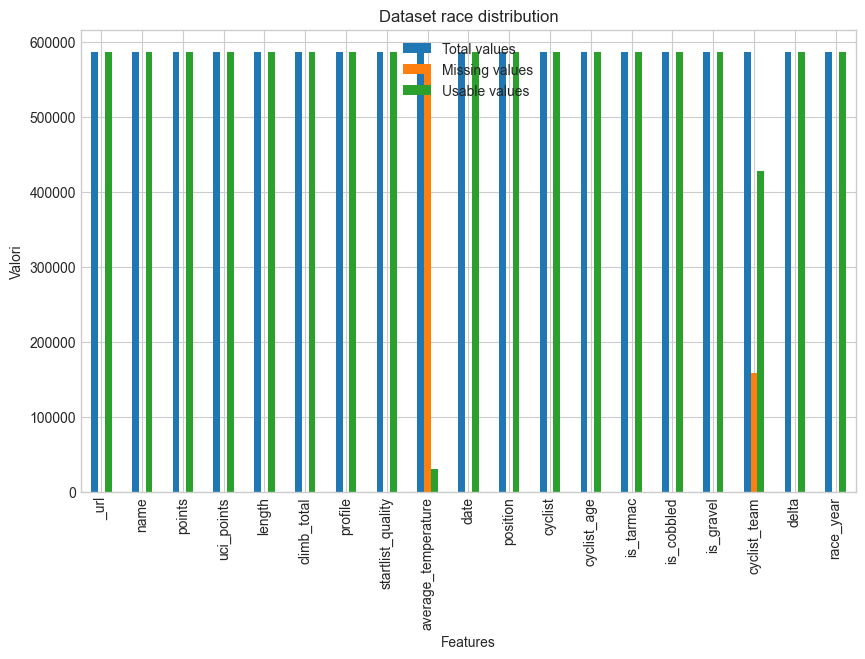

In [45]:
PlotMissingUsableData(DatasetRace, "race")

#### **Saving `cleaned races dataset and cleaned cyclist dataset**

In [ ]:
import shutil
from pathlib import Path
from datetime import datetime

def move_to_tmp(file_path, keep_original=False):
    """
    Check if file exists and move it to /tmp folder.
    
    Args:
        file_path (str): Path to the file to be moved
        keep_original (bool): If True, copy file instead of moving it
    
    Returns:
        str: Path to the new location if successful, None if file doesn't exist
    """
    try:
        # Convert to Path object for easier handling
        file_path = Path(file_path)
        
        # Check if file exists
        if not file_path.exists():
            print(f"File {file_path} does not exist")
            return None
            
        # Create a new filename with timestamp to avoid conflicts
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        new_filename = f"{file_path.stem}_{timestamp}{file_path.suffix}"
        tmp_path = Path('/tmp') / new_filename
        
        # Move or copy the file
        if keep_original:
            shutil.copy2(file_path, tmp_path)
            print(f"File copied to {tmp_path}")
        else:
            shutil.move(file_path, tmp_path)
            print(f"File moved to {tmp_path}")
            
        return str(tmp_path)
        
    except PermissionError:
        print(f"Permission denied: Cannot access {file_path}")
        return None
    except Exception as e:
        print(f"Error occurred: {str(e)}")
        return None


# But before we need to remove cyclist that are not present in the races dataset

DatasetCyclists = DatasetCyclists[DatasetCyclists['_url'].isin(DatasetRace['cyclist'].unique())]
print(len(DatasetCyclists))

# !WARNING! This operation will overwrite the original files
# !WARNING! Uncomment the following lines to save the filled datasets

# Now we can save the dataset to a csv file


# move_to_tmp('dataset/races_filled.csv')
# DatasetRace.to_csv('dataset/races_filled.csv', index=False)
# move_to_tmp('dataset/cyclists_filled.csv')
# DatasetCyclists.to_csv('dataset/cyclists_filled.csv', index=False)

# **Feature engineering**

Si fa il merge delle tabelle in un unica tabella, prendendo come chiavi di riferimento la colonna "_url" del dataset cyclists e la colonna "cyclists" del dataset race.

                     Total values  Missing values  Usable values
Elements                                                        
name_cyclist               586982               0         586982
birth_year                 586982             112         586870
weight                     586982          111112         475870
height                     586982          109797         477185
nationality                586982              52         586930
name_race                  586982               0         586982
points                     586982               0         586982
uci_points                 586982          336927         250055
length                     586982               0         586982
climb_total                586982          146447         440535
profile                    586982          147629         439353
startlist_quality          586982               0         586982
average_temperature        586982          557121          29861
date                     

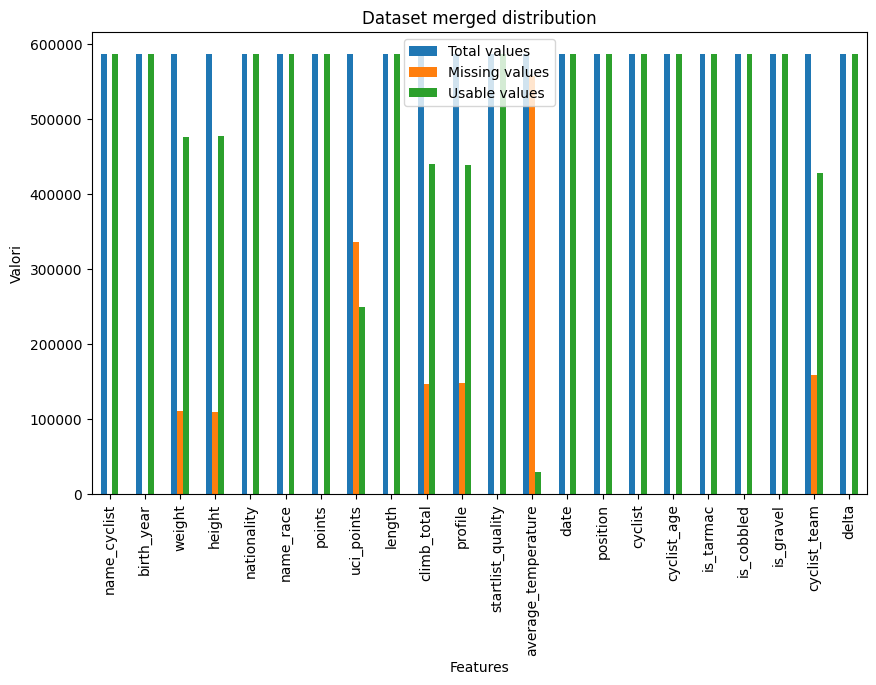

In [9]:
MergeDataset = pd.merge(DatasetCyclists, DatasetRace, left_on = "_url", right_on = "cyclist")

del MergeDataset["name_x"]
del MergeDataset["name_y"]

MergeDataset.rename(columns = {"_url_x": "name_cyclist"}, inplace = True)
MergeDataset.rename(columns = {"_url_y": "name_race"}, inplace = True)

PlotMissingUsableData(MergeDataset, "merged")

#### Feature `pca_race_points`

Since `cyclist_team` has NaN values, and it would be pointless to infer it, we will transform it into a column called `teams_count`. This new column will count the number of unique teams each cyclist has participated in.

In [3]:
DatasetRace = pd.read_csv("dataset/races_filled.csv")

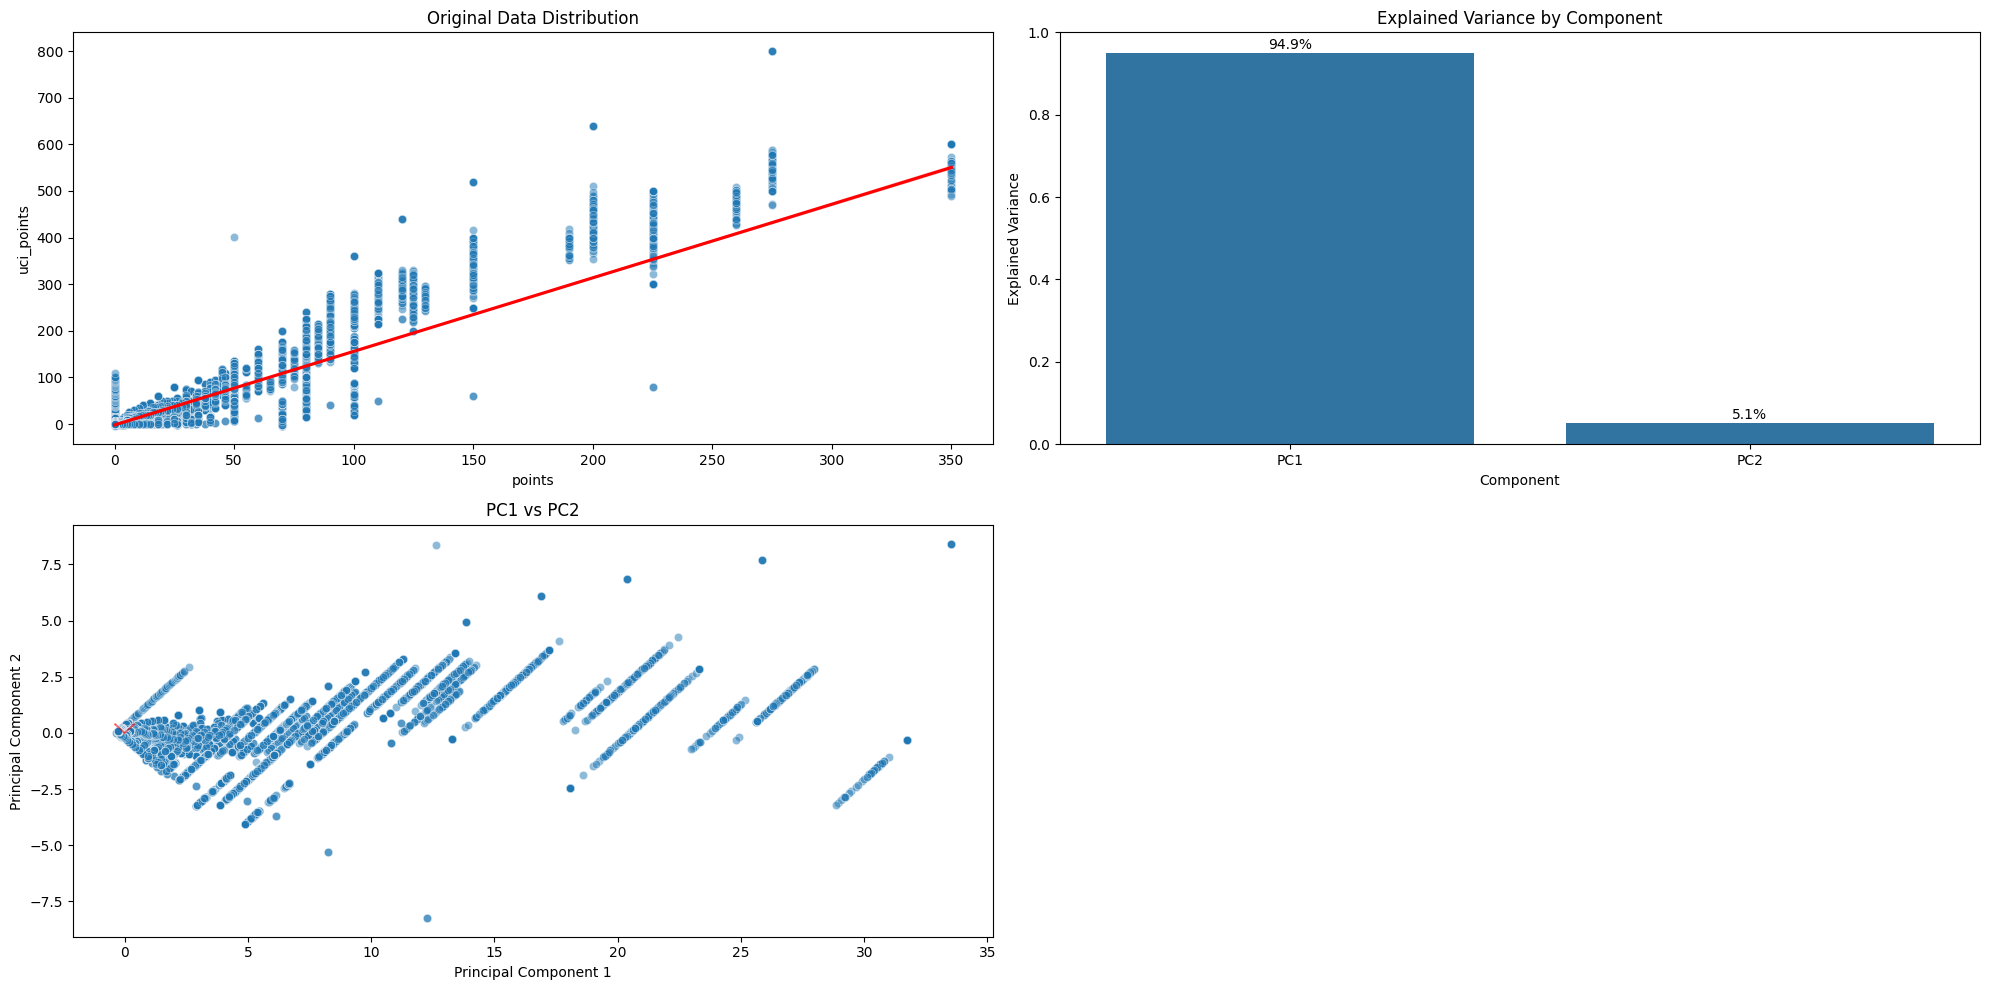


PCA Components Information:

Explained Variance Ratio:
PC1: 94.9% (Cumulative: 94.9%)
PC2: 5.1% (Cumulative: 100.0%)

Component Weights:

PC1:
  points: 0.707
  uci_points: 0.707

PC2:
  points: -0.707
  uci_points: 0.707

Transformed Data Statistics:
                PC1           PC2
count  5.869820e+05  5.869820e+05
mean   3.679925e-18  2.235191e-17
std    1.377907e+00  3.183959e-01
min   -3.469640e-01 -8.236708e+00
25%   -2.679049e-01  6.459218e-02
50%   -2.679049e-01  6.459218e-02
75%   -2.679049e-01  6.459218e-02
max    3.353728e+01  8.424229e+00


_url             name  points  uci_points  \
153091  tour-de-france/1981/stage-12a   Tour de France     0.0         0.0   
403431  vuelta-a-espana/2001/stage-19  Vuelta a España     0.0         0.0   
68712     tour-de-france/1982/stage-6   Tour de France     0.0         0.0   
457804   tour-de-france/2002/stage-11   Tour de France     0.0         0.0   
20575   vuelta-a-espana/1993/stage-12  Vuelta a España     0.0         0.0   

          length  climb_total  profile  startlist_quality  \
153091  105500.0       1052.0      1.0               1362   
403431  168000.0       1874.0      1.0                971   
68712   233000.0       1184.0      1.0               1492   
457804  158000.0       4000.0      5.0               1489   
20575   220700.0       1003.0      2.0                819   

        average_temperature                 date  position         cyclist  \
153091                  NaN  1981-07-08 02:25:48        17  jacques-bossis   
403431                  NaN  2001-09-28 04:05:01        82  jan-schaffrath   
68712                   NaN  1982-07-08 06:01:45        99  rene-bittinger   
457804                  NaN  2002-07-18 04:50:51       168     oscar-pozzi   
20575                   NaN  1993-05-07 05:58:52        21   willy-willems   

        cyclist_age  is_tarmac  is_cobbled  is_gravel cyclist_team   delta  \
153091         29.0       True       False      False          NaN     0.0   
403431         30.0       True       False      False          NaN   927.0   
68712          28.0       True       False      False          NaN   363.0   
457804         31.0       True       False      False          NaN  1734.0   
20575          30.0       True       False      False          NaN     0.0   

        race_year  pca_race_points  
153091       1981        -0.267905  
403431       2001        -0.267905  
68712        1982        -0.267905  
457804       2002        -0.267905  
20575        1993        -0.267905

In [ ]:
# Importing our custom functions
from outliers_code.pca_reducer import combine_race_points


DatasetRace = combine_race_points(DatasetRace, add_to_df=False)
DatasetRace.sample(5)

### Features `weight_height_ratio`, `race_difficulty`, `points_per_km`, `startlist_score_per_km`

Since we want to experiment with different clustering algorithms, and for some of them dimensionality plays a big role, we decided to define new features from the original data to retain most of the uncut information while reducing the dimensionality. We combined weight and height into weight_height_ratio. We also combined length, climb_total, and is_tarmac to obtain a new feature called race_difficulty. Also, `points` and `length` to obtain `points_per_km`. Lastly, `startlist` and `length` to derive `startlist_score_per_km` feature. 

In [ ]:
MergeDataset['weight_height_ratio'] = MergeDataset['weight'] / (MergeDataset['height'])
MergeDataset['race_difficulty'] = (
    MergeDataset['length'] * 0.3 +
    MergeDataset['climb_total'] * 0.5 +
    MergeDataset['is_tarmac'] * 0.1
) / 100

MergeDataset['points_per_km'] = MergeDataset['uci_points'] / (MergeDataset['length'] * 0.001)
MergeDataset['startlist_score_per_km'] = MergeDataset['startlist_quality'] / MergeDataset['length']

### Review about distribution data

In [ ]:
PlotMissingUsableData(MergeDataset, "Merge dataset")

In [ ]:
PlotDistributionFeatures(MergeDataset,
                         ['birth_year', 'weight', 'height', 'points', 'uci_points', 'length', 'climb_total', 'profile',
                          'startlist_quality', 'date', 'position', 'cyclist', 'cyclist_age', 'delta'])

# **Outliers Detection**

In [2]:
# Package required: torch, thus don't run if not installed
# Python lower than 3.13 is required (and probably lower than something, but I don't know what)

packages = [
    'thinc',
    'srsly',
    'fastai'
]

for package in packages:
    check_and_install(package)



### Importing the Dataset cleaned

In [3]:
DatasetRaces = pd.read_csv('dataset/races_filled.csv')

DatasetRaces.sample(3)

_url                   name  points  \
324847         dauphine/2017/stage-4  Critérium du Dauphiné     0.0   
142152   tour-de-suisse/1997/stage-9         Tour de Suisse     2.0   
40176   tour-de-suisse/2007/prologue         Tour de Suisse     0.0   

        uci_points    length  climb_total  profile  startlist_quality  \
324847         0.0   23500.0        321.0      1.0               1024   
142152         0.0  191300.0       2656.0      3.0               1161   
40176          0.0    3800.0        223.0      1.0               1089   

                       date  position           cyclist  cyclist_age  \
324847  2017-06-07 00:30:27        69      julien-duval         27.0   
142152  1997-06-26 04:09:59         9         lauri-aus         27.0   
40176   2007-06-16 00:04:55       161  thierry-marichal         34.0   

        is_tarmac  is_cobbled  is_gravel                     cyclist_team  \
324847       True       False      False  liberty-seguros-wurth-team-2005   
142152       True       False      False                              NaN   
40176        True       False      False                              NaN   

        delta  race_year  
324847  140.0       2017  
142152    8.0       1997  
40176    35.0       2007

In [4]:
DatasetCyclists = pd.read_csv('dataset/cyclists_filled.csv')
DatasetCyclists.sample(3)

_url                    name  birth_year     weight  \
4123       preben-van-hecke        Preben Van Hecke      1982.0  69.000000   
616   jean-francois-chaurin  Jean-François  Chaurin      1961.0  63.858539   
2949             luke-plapp             Luke  Plapp      2000.0  72.000000   

          height nationality  
4123  179.000000     Belgium  
616   175.471241      France  
2949  181.000000   Australia

#### Adding the features

In [ ]:
from outliers_code.pca_reducer import combine_race_points

MergedDataset = pd.merge(DatasetRaces, DatasetCyclists, left_on='cyclist', right_on='_url', how='inner', suffixes=('_race', '_cyclist'))
MergedDataset_outer = pd.merge(DatasetRaces, DatasetCyclists, left_on='cyclist', right_on='_url', how='outer', suffixes=('_race', '_cyclist'))
MergedDataset.drop(columns=["_url_cyclist", 'name_race', 'name_cyclist'], inplace=True)



DatasetRace = combine_race_points(MergedDataset, add_to_df=True, plot_analysis=False)

MergedDataset['weight_height_ratio'] = MergedDataset['weight'] / (MergedDataset['height'])
MergedDataset['race_difficulty'] = (
    MergedDataset['length'] * 0.3 +
    MergedDataset['climb_total'] * 0.5 +
    MergedDataset['is_tarmac'] * 0.1
) / 100

performance_features = ['pca_race_points', 'position', 'delta']

merged = MergedDataset.groupby('cyclist')
group_size = merged.size()
single_value_group = group_size[group_size == 1].index

std_dev = merged[performance_features].transform('std')
mean_std_dev = std_dev.mean(axis=1)

mean_std_dev[MergedDataset['cyclist'].isin(single_value_group)] = 0

MergedDataset['consistency_score'] = mean_std_dev
MergedDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586982 entries, 0 to 586981
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   _url_race            586982 non-null  object 
 1   points               586982 non-null  float64
 2   uci_points           586982 non-null  float64
 3   length               586982 non-null  float64
 4   climb_total          586982 non-null  float64
 5   profile              586982 non-null  float64
 6   startlist_quality    586982 non-null  int64  
 7   date                 586982 non-null  object 
 8   position             586982 non-null  int64  
 9   cyclist              586982 non-null  object 
 10  cyclist_age          586982 non-null  float64
 11  is_tarmac            586982 non-null  bool   
 12  is_cobbled           586982 non-null  bool   
 13  is_gravel            586982 non-null  bool   
 14  cyclist_team         428276 non-null  object 
 15  delta            

#### Firstly, we need to encode the categorical data

Is being encoded by the `TabularPandas` class from the `fastai` package.


In [6]:
from outliers_code.utils import encode_tabular_data

cont_features = ['pca_race_points', 'weight_height_ratio', 'race_difficulty', 'consistency_score', 'position', 'cyclist_age']
cat_features = ['nationality']

df_encoded = encode_tabular_data(MergedDataset, cat_features, cont_features)

### Local Outlier Factor (LOF) Algorithm

The first algorithm to detect races row outliers is LOF, which is great for datasets where the data density varies. It detects outliers by computing, for each point, the distance to its k-nearest neighbors. Afterwards, LOF computes a local reachability density (LRD). The LRD measures how densely packed its neighborhood is, based on the distance to its k-nearest neighbors. A point with sparse surroundings will have a high LOF score, and a point with dense surroundings will have a low LOF score. Thus, to identify outliers, it is sufficient to find those points that have a high LOF score.


Local Outlier Factor (LOF) Detection Results

Best Parameters:
  n_neighbors:  45
  leaf_size:    23
  metric:       minkowski
  p:            1
  Score:        0.7382

Detection Statistics:
  Total points:      586,982
  Outliers found:    5,870 (1.0%)
  Inliers retained:  581,112 (99.0%)
  Contamination:     1.0%

LOF Score Distribution:
  Min score:     0.93
  Max score:     5.34
  Mean score:    1.06
  Median score:  1.03

Score Percentiles:
  25th: 1.00
  75th: 1.08
  90th: 1.17
  95th: 1.24
  99th: 1.47

Visualization Controls:
  - Use mouse to rotate 3D plots
  - Scroll to zoom in/out
  - Right-click and drag to pan


Interactive Controls:
- Use arrow keys to rotate and tilt the plots
- Close the plot window to exit
Variance explained by 3 PCs: 99.1%


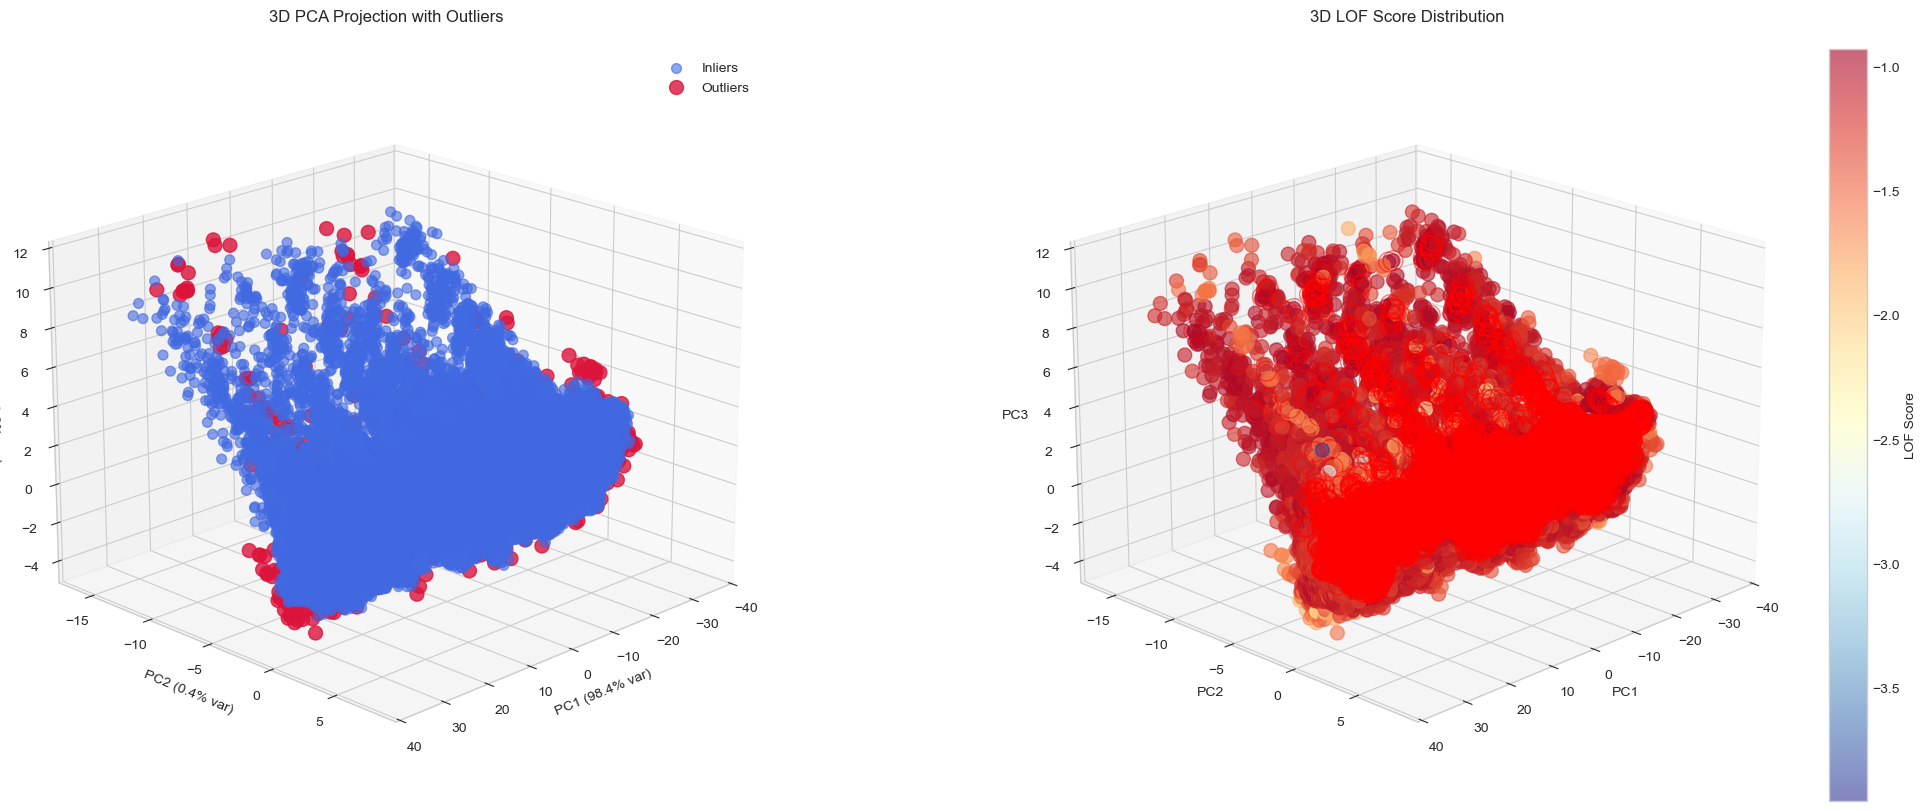

In [7]:
# import local class
from outliers_code.outliers_detection_lof import LOFOutliersDetector

detector = LOFOutliersDetector()

# outliers_lof = detector.fit_predict_with_search(df_encoded)
outliers_lof = detector.fit_predict_with_search(df_encoded)


Best parameters found:
n_estimators: 215
max_samples: 0.370
max_features: 0.969
contamination: 0.014
bootstrap: True
Best score: 0.6035

3D Isolation Forest Detection Summary:
Total points: 586982
Outliers detected: 8380 (1.4%)
Anomaly Score Range: -0.10 to 0.21
Variance explained by 3 PCs: 99.1%

Interactive Controls:
- Use arrow keys to rotate and tilt the plots
- Close the plot window to exit


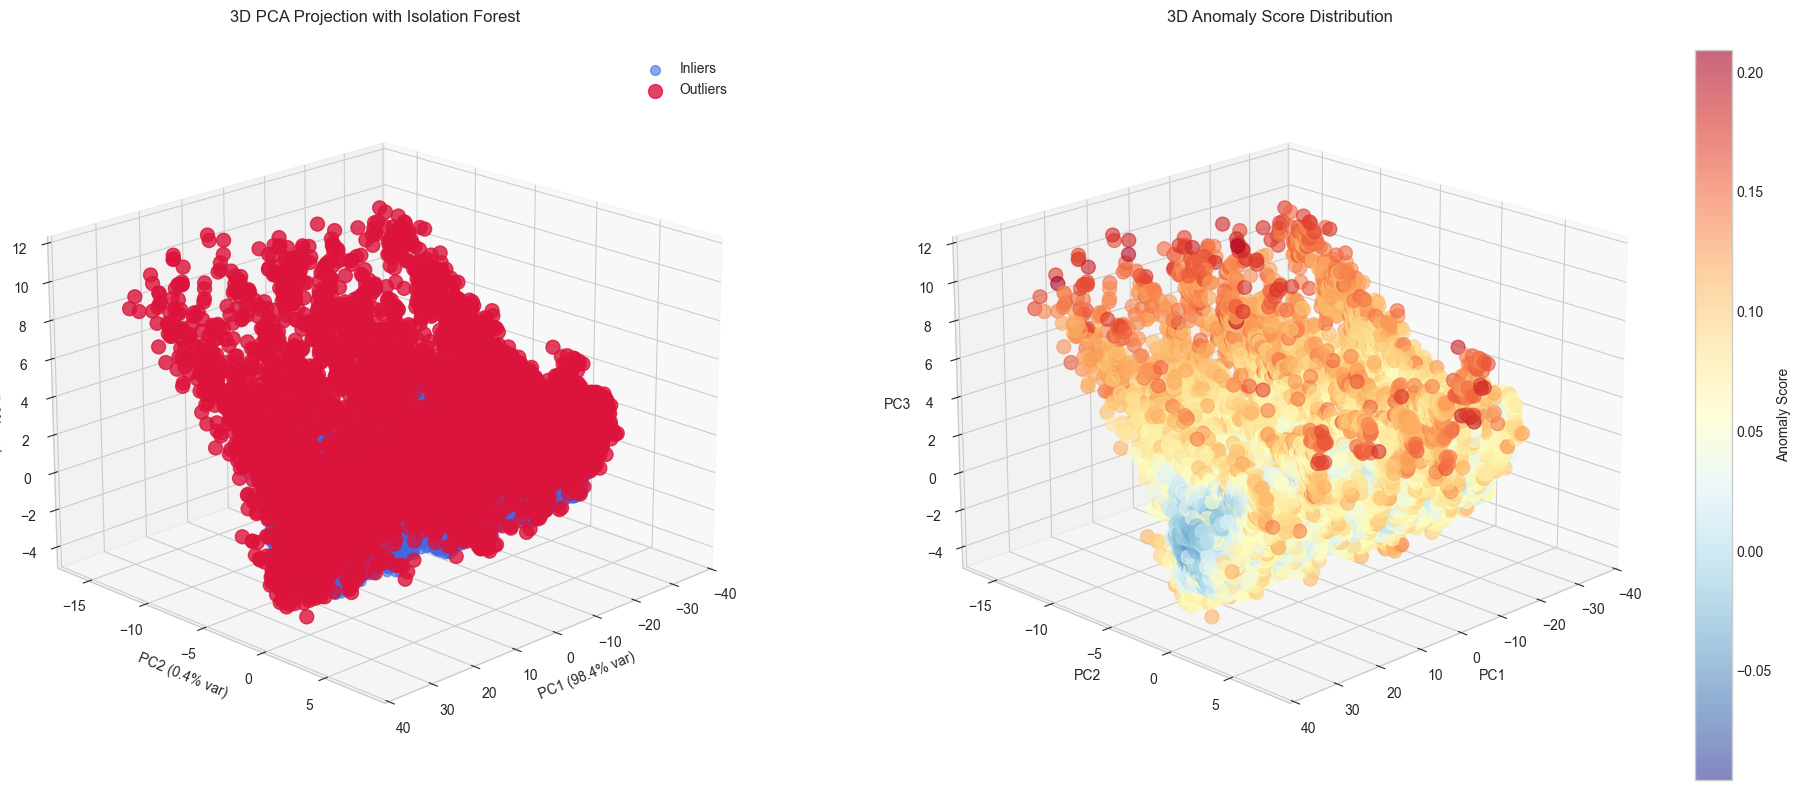

In [8]:
from outliers_code.outliers_detection_iso_for import IsolationForestDetector

detector = IsolationForestDetector()

outliers_iso_for =  detector.fit_predict_with_search(df_encoded)

In [ ]:
from outliers_code.outliers_detection_oc_svm import OneClassSVMDetector

detector = OneClassSVMDetector( nu=0.07, kernel='rbf', gamma='scale')

# detector.fit_predict_with_search(df_encoded, n_iter=20, cv=5, verbose=1)

outliers_oc_svm = detector.fit_predict(df_encoded)

#### **OneClassSVM** on GPU

**Note:** Run the code below with caution, especially in a virtual environment. The code will try to install all the CUDA packages necessary to run SVM on the GPU to speed up things.

13.3.0
Using GPU 0: NVIDIA GeForce RTX 4080 Laptop GPU
One-Class SVM Will Run ON GPU ID: 0


Parameter Search:   0%|          | 0/25 [00:00<?, ?it/s]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.007801564007847302, gamma=1.7824348398379324e-05)


Parameter Search:   4%|▍         | 1/25 [00:02<00:55,  2.31s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.006556954263676668, gamma=0.00018058621196731436)


Parameter Search:   8%|▊         | 2/25 [00:04<00:48,  2.09s/it]

Processing params: SVMParams(kernel=np.str_('sigmoid'), nu=0.01309089576430468, gamma=0.0005793533623243597)


Parameter Search:  12%|█▏        | 3/25 [00:11<01:35,  4.36s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.01427540633815668, gamma=0.00010293686428672767)


Parameter Search:  16%|█▌        | 4/25 [00:14<01:20,  3.86s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.011771495044271845, gamma=9.164797513102401e-05)


Parameter Search:  20%|██        | 5/25 [00:16<01:08,  3.40s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.01378878067742308, gamma=0.0008932374078113255)


Parameter Search:  24%|██▍       | 6/25 [00:20<01:02,  3.27s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.007152439464369786, gamma=2.1393078446967336e-05)


Parameter Search:  28%|██▊       | 7/25 [00:22<00:53,  2.95s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.010753220968204523, gamma=0.00037056187279792946)


Parameter Search:  32%|███▏      | 8/25 [00:25<00:50,  2.97s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.006859105217085102, gamma=0.0036949871317863334)


Parameter Search:  36%|███▌      | 9/25 [00:28<00:49,  3.09s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.007422508506100645, gamma=0.03544870087554142)


Parameter Search:  40%|████      | 10/25 [00:30<00:41,  2.79s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.010112300238988937, gamma=0.000688524482440472)


Parameter Search:  44%|████▍     | 11/25 [00:33<00:37,  2.69s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.005073963134967203, gamma=2.2767055088936296e-05)


Parameter Search:  48%|████▊     | 12/25 [00:34<00:30,  2.35s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.012409567897632498, gamma=0.659434273997881)


Parameter Search:  52%|█████▏    | 13/25 [00:39<00:36,  3.03s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.00654899797410138, gamma=0.48137150384960964)


Parameter Search:  56%|█████▌    | 14/25 [00:42<00:32,  3.00s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.012452882091548139, gamma=0.05783666726570085)


Parameter Search:  60%|██████    | 15/25 [00:45<00:29,  2.94s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.013261269755398514, gamma=0.2600555436270048)


Parameter Search:  64%|██████▍   | 16/25 [00:48<00:26,  2.95s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.010506777975967503, gamma=0.4909781686860873)


Parameter Search:  68%|██████▊   | 17/25 [00:52<00:26,  3.34s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.014727832506866621, gamma=2.9570774862406186e-05)


Parameter Search:  72%|███████▏  | 18/25 [00:56<00:25,  3.60s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.014855550234115104, gamma=3.7204237594019584e-05)


Parameter Search:  76%|███████▌  | 19/25 [00:59<00:21,  3.54s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.009874958974999428, gamma=5.555466421542023e-05)


Parameter Search:  80%|████████  | 20/25 [01:02<00:15,  3.18s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.006870130119050086, gamma=0.138395128997656)


Parameter Search:  84%|████████▍ | 21/25 [01:04<00:11,  2.82s/it]

Processing params: SVMParams(kernel=np.str_('sigmoid'), nu=0.011478690119962871, gamma=0.01103413532459065)


Parameter Search:  88%|████████▊ | 22/25 [01:07<00:08,  2.81s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.014461459085920843, gamma=0.10053087043593356)


Parameter Search:  92%|█████████▏| 23/25 [01:10<00:05,  2.90s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.010085534587269688, gamma=0.00286238603040399)


Parameter Search:  96%|█████████▌| 24/25 [01:12<00:02,  2.74s/it]

Processing params: SVMParams(kernel=np.str_('rbf'), nu=0.010416601773799355, gamma=0.0002824580336376231)


Parameter Search: 100%|██████████| 25/25 [01:14<00:00,  3.00s/it]



GPU One-Class SVM Detection Results

Best Parameters:
  Kernel:     rbf
  Nu:         0.007
  Gamma:      0.0002
  Score:      1.0000

Detection Statistics:
  Total points:      586,982
  Outliers found:    3,849 (0.7%)
  Inliers retained:  583,133 (99.3%)

Anomaly Score Distribution:
  Min score:     -24.03
  Max score:     2279.38
  Mean score:    887.01
  Median score:  735.31

Score Percentiles:
  25th: 389.73
  75th: 1703.51
  90th: 1831.97
  95th: 1914.95
  99th: 2079.85

Visualization Controls:
  - Use mouse to rotate 3D plots
  - Scroll to zoom in/out
  - Right-click and drag to pan



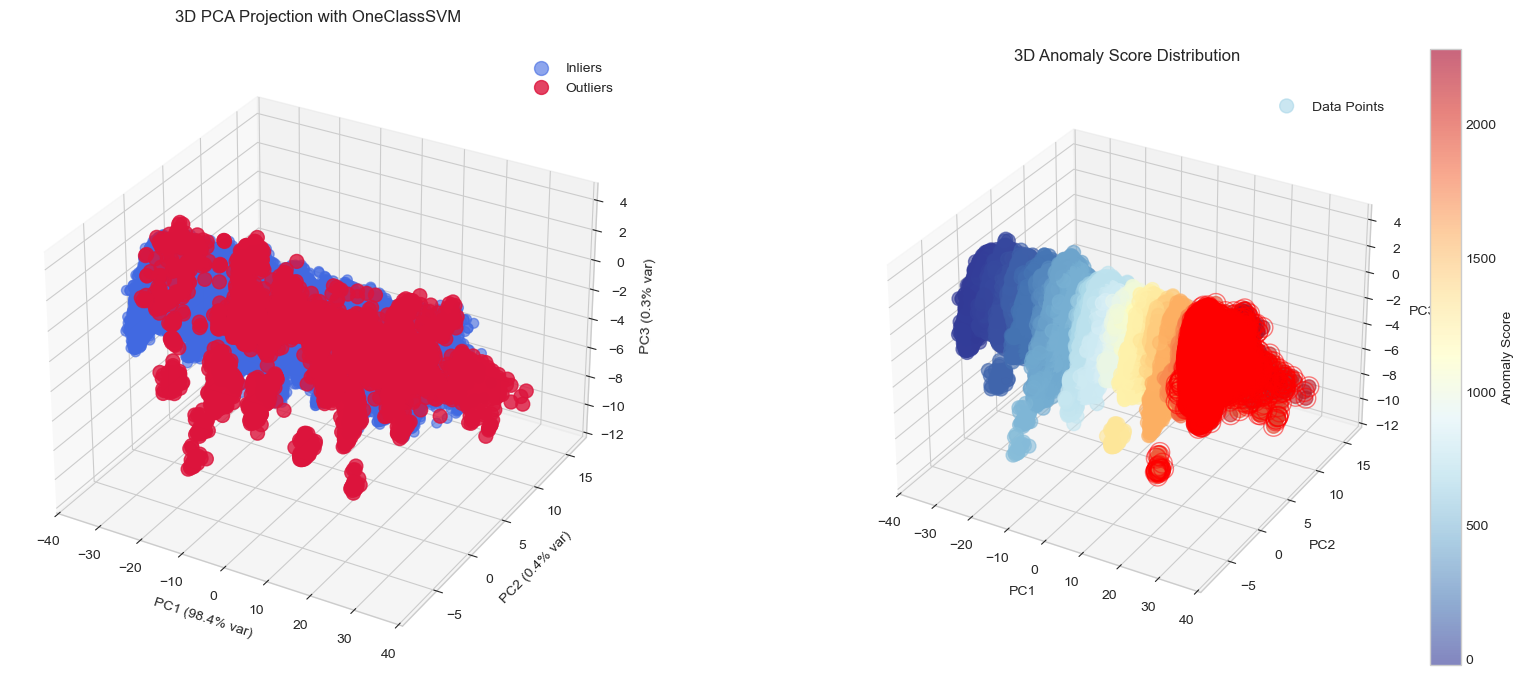

Variance explained by 3 PCs: 99.1%

Interactive Controls:
- Use arrow keys to rotate and tilt the plots
- Close the plot window to exit


In [7]:
# Warning: installing gpu libraries
# An installation requirement for cuML is that your system must be Linux-like. Support for Windows is possible in the near future.

# We need to install the rapidsai library, which is a GPU-accelerated version of pandas and scikit-learn.
# # Go here to get the command to run based on your system: https://docs.rapids.ai/install/#selector
# E.g. mine was:
# conda create -n rapids-24.10 -c rapidsai -c conda-forge -c nvidia  \
#    rapids=24.10 python=3.12 'cuda-version>=12.0,<=12.5'
# conda activate rapids-24.10
# conda install jupyterlab ipykernel
# 
# Unfortunatelly, rapidsai 24.10 does not have OnveClassSVM implemented, thus I found one in thunderSVM.
# But it needs to be cloned and compiled to get to work with cuda above cuda-9.0, which is default.
# git clone https://github.com/Xtra-Computing/thundersvm/tree/master
# cd thundersvm
# mkdir build
# cd build
# cmake .. -DUSE_CUDA=ON -DUSE_DOUBLE=ON 
# make -j4
# cd ../python
# pip install . (ensure you are in rapids-24.10 environment)

import cupy as cp
print(cp.__version__)

from outliers_code.outliers_detection_oc_svm_gpu import GPUOneClassSVMDetector

# detector = GPUOneClassSVMDetector(nu=0.07, kernel='rbf', gamma='scale')
detector = GPUOneClassSVMDetector()

outliers_oc_svm_gpu = detector.fit_predict_with_search(df_encoded, n_iter=25)
# outliers_oc_svm_gpu = detector.fit_predict(df_encoded)

